In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque

from pyswarm import pso

In [2]:
#### functions to transform 1-array into triangular inf matrix  and vice versa ####

def i2j_to_k(i, j):
    return i*(i-1)/2 + j

def k_to_i2j(k):
    i = int((1+math.sqrt(1+8*k))/2)
    j = int(k - i*(i-1)/2)
    return (i,j)
    

def d1_2_mat(d):
    l = len(d)
    (n, _) = k_to_i2j(l)
    #print(n)
    mat = np.zeros([n,n])
    for k in range(l):
            (i,j) = k_to_i2j(k)
            mat[i,j] = d[k]
            mat[j,i] = -d[k]
    return mat

def mat_2_d1(mat):
    
    (n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    liste = []
    for k in range(k_max):
        (i,j) = k_to_i2j(k)
        liste.append(mat[k_to_i2j(k)])
        
    return np.array(liste)



def d1_2_mat_list(d, n_Item):
    
    item_list = np.reshape(np.array(d), (n_Item, -1))
    l = len(item_list[0])
    
    (n, _) = k_to_i2j(l)

    mat = np.zeros([n_Item,n,n])
    
    for it in range(n_Item):

        for k in range(l):
                (i,j) = k_to_i2j(k)
                mat[it,i,j] = item_list[it,k]
                mat[it,j,i] = -item_list[it,k]
    return mat

def mat_2_d1_list(mat):
    
    liste_totale = []
    (n_item, n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    for it in range(n_item):
        liste = []
        for k in range(k_max):
            (i,j) = k_to_i2j(k)
            liste.append(mat[it,i,j])
            
        liste_totale+= liste

    return np.array(liste_totale)


    

In [3]:
def detection_cooperation_A(env, id_agent_source, last_offer): #ratio other agent gave / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        #print(history[-2])
        last_trans = history[-2].sum(1) #what each agent gave
        #last_offer = agent.last_offers[-1]
        my_offer_max = np.sum(np.maximum(last_offer,0))
        
        #print("last_trans", last_trans)
        
        coop_degrees = np.clip(last_trans/my_offer_max,0,1)
    
        return coop_degrees
        
        

In [4]:
def detection_cooperation_B(env, id_agent_source, last_offer): #ratio other agent gave ME * (N_agent-1) / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        #print(history[-2])
        last_trans = history[-2][:,id_agent_source]*(n_agents-1) #what each agent gave
        #last_offer = agent.last_offers[-1]
        my_offer_max = np.sum(np.maximum(last_offer,0))
        
        #print("last_trans", last_trans)
        
        coop_degrees = np.clip(last_trans/my_offer_max,0,1)
    
        return coop_degrees

In [6]:
def TFT(alpha, r, beta=0):
    def function(old_coop_degrees, detected_coop_degrees, r):
        delta = detected_coop_degrees - old_coop_degrees
        r = np.maximum(r + beta*delta,0)
        output = alpha*old_coop_degrees + (1-alpha)*(r + (1-r)*detected_coop_degrees)        
        return output, r
        
    return function, r
        

In [7]:
algo2 = TFT(0.1,0.2,0.7)
algo1 = TFT(0.2,0.1,0.6)
egoist = TFT(1,0,0.5)

In [1950]:
class Agent:
    def __init__(self, id_agent, n_agents, n_items, neg_algo=0):
        self.n_agents = n_agents
        self.n_items = n_items
        self.id_agent = id_agent
        self.old_coop_degrees = np.zeros(self.n_agents)
        self.ut_function = []
        self.last_offers = []
        tft_algo, r = neg_algo
        self.negociation_algo =  tft_algo
        self.r = r*np.ones(self.n_agents)
        
    def coop_detection(self, env):
        n_agents = env.n_agents
        id_agent_source = self.id_agent
        if len(self.last_offers) == 0:
            return np.zeros(n_agents)
            #print("non last offers")
        else:
            #print("presence last offers")
            last_offer = self.last_offers[-1]
            output = detection_cooperation_B(env, id_agent_source, last_offer)
            return output 
        
    def offer(self, env):
        tran= env.optimize_localy(self.id_agent)
        self.last_offers.append(tran)
        return tran
    
    def negociation(self, detected_coop_degrees):
        output, r_new = self.negociation_algo(self.old_coop_degrees, detected_coop_degrees, self.r)
        self.r = r_new
        self.old_coop_degrees = output
        return output
        
        

In [1951]:
algo2 = DTFT(0.1,0.2,0.7)
algo1 = DTFT(0.2,0.1,0.6)
egoist = DTFT(1,0,0.5)

n_A = 3
n_I = 3
a1 = Agent(0, n_A, n_I, algo1)
a2 = Agent(1, n_A, n_I, algo1)
a3 = Agent(2, n_A, n_I, algo1)
#a4 = Agent(3, n_A, n_I, algo1)

liste_agents_A = [a1, a2, a3]


In [1953]:
class Environment:
    def __init__(self, n_agents, n_items, list_agents = []):
        self.n_agents = n_agents
        self.agents = list_agents
        self.n_items = n_items
        self.t = 0 #step 
        self.state = np.zeros([n_agents, n_items])
        self.states_history = [] #history of states
        self.transactions_history = []
        self.transactions_history_numpy = []
        
        self.optimal_SW = 0 #optimal social welfare 
        self.hist_SW = [] #evolution of social welfare
        self.hist_ut_agents = [[] for _ in range(self.n_agents)] #evolution of utilities of agents 
        
        self.hist_coop_degrees = [] #evolution of cooperation degrees
        
        
    def init_state(self, state):
        s = np.copy(state)
        self.state = s
        self.t = 0
        
    def next_round(self):
        self.t += 1
        self.transactions_history.append([])
        self.transactions_history_numpy.append(np.zeros([env.n_agents, env.n_agents]))
        
    def replace_agents(self, list_agents):
        self.agents = list_agents
        
    def clip_state(self, lb, ub):
        self.state = np.clip(self.state, lb, ub)
    
    def random_init(self, mean=0, std=1):
        self.state = np.random.normal(mean, std, size = [self.n_agents, self.n_items])
        
    def transaction(self, id_agent_source, id_agent_target, id_item, quantity):
        self.state[id_agent_target, id_item] += quantity
        self.state[id_agent_source, id_item] -= quantity
        
        self.transactions_history[-1].append((env.t, id_agent_source, id_agent_target, id_item, quantity))
        
        #update quantities shared between agents (independently of items)
        self.transactions_history_numpy[-1][id_agent_source, id_agent_target] += quantity
        
        
        
    def add_transactions_np(self, state, transactions):
        #state : array nA x nI
        #transactions : array nI x nA x nA

        (nA, nI) = np.shape(state)
        new_s = state.copy()
        for item in range(nI):
            for agent in range(nA):
                new_s[agent, item] -= transactions[item, agent, : ].sum()

        return new_s
    
    def add_transactions_var(self, state, trans_var):
        #state : array nA x nI
        #trans_var : variable for optimisation, liste
        transactions = d1_2_mat_list(trans_var, self.n_items)
        return self.add_transactions_np(state, transactions)
    

    def global_utility(self, state, lb =-2.0, ub = 100.0):
        s = np.copy(state)
        s = np.clip(s, lb, ub)
        return -np.log(s+2+1e-8).sum()
    
    def local_utility(self, state, id_agent):
        s = np.copy(state)
        s = s[id_agent,:]
        s = np.clip(s, -2, 100)
        return -np.log(s+2+1e-8).sum()
    
    def optimize_localy(self, id_agent, lb = -4, ub = 4, min_cons = -1):
        (nA, nI) = self.n_agents, self.n_items
        size_var = nI #size of variable 
        lb_list = lb*np.ones(size_var) #lower bounds
        ub_list = ub*np.ones(size_var) #upper bounds
        
        s_tmp = np.copy(self.state)
        
        def f_opt(dx): #utility function for pso
            s = np.copy(s_tmp)
            s[id_agent, :] += dx
            return self.local_utility(s, id_agent) + 0.01 * np.linalg.norm(dx)
            
        def constraint(dx):
            s = np.copy(s_tmp)
            s[id_agent, :] += dx       
            s = s[id_agent]        
            const_out1 = s-min_cons
            const_out2 = np.array([-dx.sum()])
            const_out = np.concatenate((const_out1,const_out2))

            return const_out
        
        xopt, fopt = pso(f_opt, f_ieqcons= constraint, lb=lb_list, ub=ub_list, maxiter=200, swarmsize=200)
        
        return(xopt)
    
    
    def optimize_globably(self, lb = -2.0, ub = 2.0):
        (nA, nI) = self.n_agents, self.n_items
        k_max = nI * ( int((nA-1)*(nA-2)/2 + nA-1)  )
        d_var = np.zeros(k_max)
        lb_list = lb*np.ones(k_max)
        ub_list = ub*np.ones(k_max)
        
        s = self.state.copy()
        
        def f_opt(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            fusion_items = trans_var_np.sum(0)
            received_agents = fusion_items.sum(1)
            
            return self.global_utility(new_s_tmp) + 0.1*np.linalg.norm(received_agents) + 0.1 * np.linalg.norm(dx) 
    
        def constraint(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            const_out = new_s_tmp - min_cons
            #const_out2 = np.array([-dx.sum()])
            #const_out = np.concatenate((const_out1,const_out2))

            return const_out
    
    
        xopt, fopt = pso(f_opt, lb_list, ub_list, maxiter=300, swarmsize=300)
        
        transactions = d1_2_mat_list(xopt, self.n_items)
        new_s = self.add_transactions_np(s, transactions)
        #print(new_s)
        
        return(transactions, new_s, env.global_utility(new_s))
        
    def optimal_social_welfare(self):
        (transactions, new_s, fopt) = self.optimize_globably()
        self.optimal_SW = fopt
        return f_opt
        
    def get_observation(self, id_agent):
        return self.state[id_agent, :]
    
    
    def allocation(self, coop_degrees, demands):
        
        demands_agents = np.maximum(demands,0)
        offers_agents = -np.minimum(demands,0)
        
        for it in range(self.n_items):
            for agent_source in range(self.n_agents):
                of_source = offers_agents[agent_source, it]
                
                if of_source > 0: #agent_source can give of_source for item it

                    demands_targets = np.zeros([self.n_agents])
                    parts_targets = np.zeros([self.n_agents])  
                    
                    for agent_target in range(self.n_agents):
                        dem_target = demands_agents[agent_target, it] #demand of agent_target if < 0
                        dem_target_clip = min(dem_target, of_source)
                        demands_targets[agent_target] = dem_target_clip
                        parts_targets[agent_target] = dem_target_clip
                        
                    total_demand = demands_targets.sum()

                    for agent_target in range(self.n_agents):
                        alloc = demands_targets[agent_target]*coop_degrees[agent_source, agent_target]*of_source 
                        
                        if total_demand != 0:
                            alloc/= total_demand
                        alloc = min(alloc,of_source)
                        
                        self.transaction(agent_source, agent_target, it, alloc)
                    
    
    def show(self):
        fig, axs = plt.subplots(1,self.n_agents)
        for i in range(self.n_agents):
            axs[i].bar(np.arange(self.n_items),self.get_observation(i), orientation = 'vertical')
            axs[i].axis('equal')
            axs[i].set_title("Agent "+str(i+1))
            axs[i].set_ylim([-1,1])
            
           
    
env = Environment(3,4, liste_agents_A)     

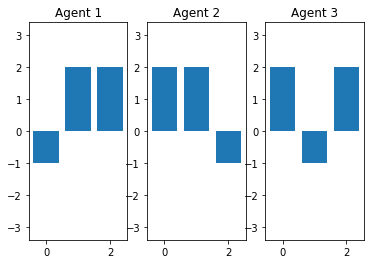

In [1954]:
env = Environment(3,3, liste_agents_A) 
env.init_state(state_E)
env.show()

In [1956]:
transactions , new_state, max_sw_op = env.optimize_globably()

Stopping search: Swarm best objective change less than 1e-08


In [1662]:
state_B = np.array([
    [-1.0,2.0,0.0,1.0],
    [3.0,1.0,-1.0,1.0],
    [1.0,-1.0,3.0,1.0],
    
])


state_C = np.array([
    [0.0,2.0,0.0,1.0,-1.0,1.0],
    [2.0,2.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,2.0,1.0],
    
])


state_D = np.array([
    [-1.0,1.0,0.0,1.0,-1.0,1.0],
    [-1.0,1.0,-1.0,1.0,-1.0,0.0],
    [1.0,-1.0,1.0,-1.0,1.0,1.0],
    [-1.0,0,1.0,-1.0,-1.0,1.0],
    
])

state_E = np.array([[-1.,  2.,  2.],
       [ 2.,  2., -1.],
       [ 2., -1.,  2.]])

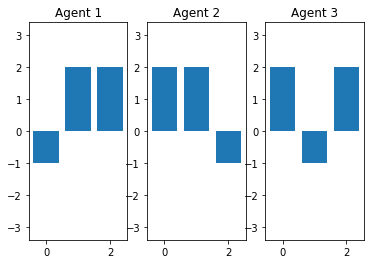

In [1856]:
env = Environment(3,3, liste_agents_A) 
env.init_state(state_E)

#env.init_state(new_s)
env.show()
#for t in env.history_transaction:
 #   print(t)

In [551]:
def utility(s, tran_var, lb=-1, ub=10):
    ns = np.copy(s)
    (nA, nI) = np.shape(ns)
    trans_np = d1_2_mat_list(tran_var, nI)
    ns = add_transactions(ns, trans_np)
    #ns = np.clip(ns, lb, ub)
    return np.log(ns+1+1e-8).sum()

def constraint(s, tran_var, lb=-1, ub=10):
    ns = np.copy(s)
    (nA, nI) = np.shape(ns)
    trans_np = d1_2_mat_list(tran_var, nI)
    ns = add_transactions(ns, trans_np)
    #ns = np.clip(ns, lb, ub)
    return np.log(ns+1+1e-8).sum()

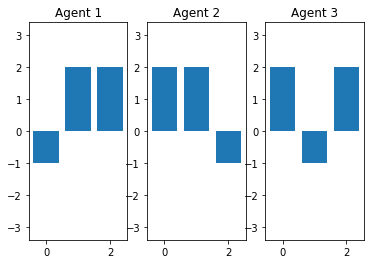

In [1569]:
env.show()

In [1958]:
env = Environment(3,3, liste_agents_A)
env.init_state(state_E)

[]


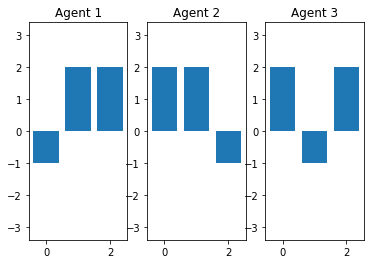

In [1959]:
#env.init_state(new_s)
env.show()
print(env.hist_SW)

In [1423]:
transa, new_s, opt = env.optimize_globably()

Stopping search: Swarm best objective change less than 1e-08


In [1960]:
def episode(env):
    n_agents = env.n_agents
    n_items = env.n_items
    opt_sw = env.optimal_social_welfare()
    env.next_round()
    
    env.states_history.append(env.state)
    current_SW = env.global_utility(env.state)
    env.hist_SW.append(current_SW)
    
    for i_A in range(n_agents):
        uti_agent = env.local_utility(env.state, i_A)
        env.hist_ut_agents[i_A].append(uti_agent)
    
    env.show()

        
    
    demands = np.zeros([n_agents, n_items])
    
    
    coop_degrees = np.zeros([n_agents, n_agents])
    
    for i_agent in range(n_agents):
        transa = env.agents[i_agent].offer(env)
        env.agents[i_agent].last_offers.append(transa)
        #print(transa)
        
        print("Agent ",i_agent)
        coop_deg_detected = env.agents[i_agent].coop_detection(env)
        print("coop deg detected ", coop_deg_detected)
        
        coop_deg_i = env.agents[i_agent].negociation(coop_deg_detected)
        print("coop deg negociated ", coop_deg_i)
        print()
        
        
        demands[i_agent, : ] = transa
        coop_degrees[i_agent,:] = coop_deg_i
        
    coop_degrees = np.clip(coop_degrees,0,1)
    
    print(coop_degrees)
    env.hist_coop_degrees.append(coop_degrees)
    
    
    env.allocation(coop_degrees, demands)
    #print(np.sum(env.state, axis=1))



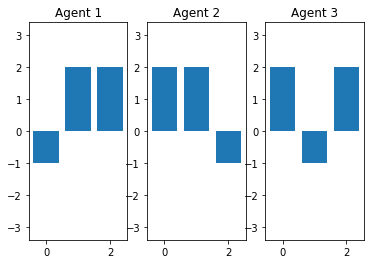

In [1747]:
env.show()

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.08 0.08 0.08]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.08 0.08 0.08]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.08 0.08 0.08]

[[0.08 0.08 0.08]
 [0.08 0.08 0.08]
 [0.08 0.08 0.08]]
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.082791   0.08038432]
coop deg negociated  [0.0576     0.15683828 0.15404635]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.08785088 0.         0.09017014]
coop deg negociated  [0.16268999 0.0576     0.16536398]

Stopping search: Swarm best objective change

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01109145 0.03784587 0.        ]
coop deg negociated  [2.08870034e-01 2.27745624e-01 1.74587904e-08]

[[1.74587904e-08 3.77036276e-01 5.08867512e-02]
 [8.96480871e-01 1.74587904e-08 5.91852562e-02]
 [2.08870034e-01 2.27745624e-01 1.74587904e-08]]
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         1.         0.40559698]
coop deg negociated  [3.49175808e-09 8.75407255e-01 4.35858535e-01]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1.         0.         0.05113892]
coop deg negociated  [9.79296174e-01 3.49175808e-09 5.27481862e-02]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.         0.00737213 0.        ]
coop deg negociated  [4.17740069e-02 5.14468305e-02 3.49175808e-09]

[[3.49175808e-09 8.754

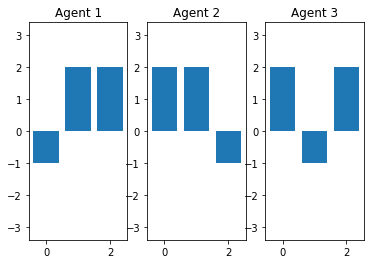

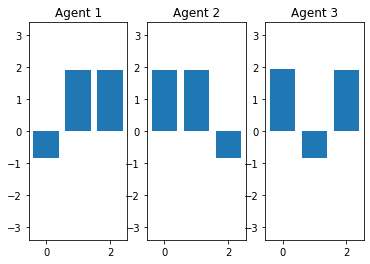

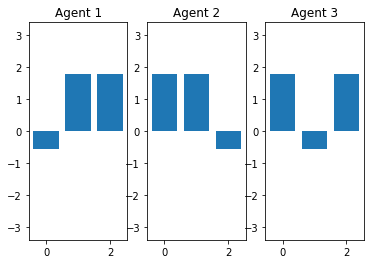

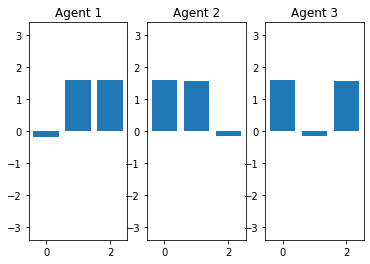

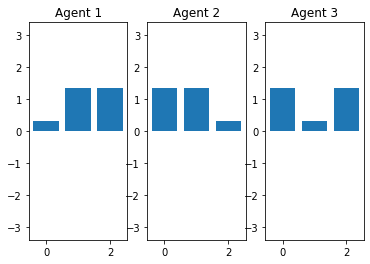

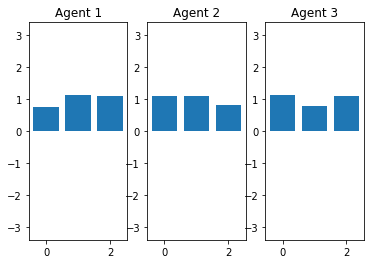

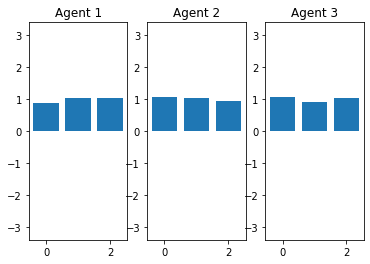

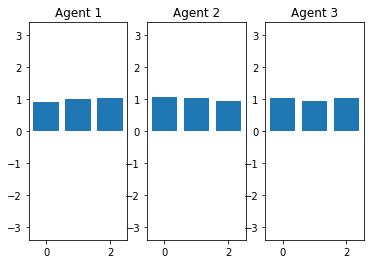

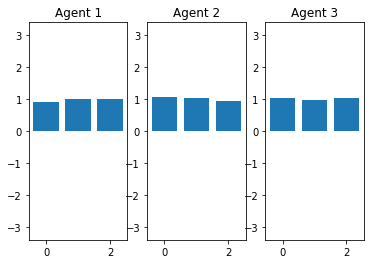

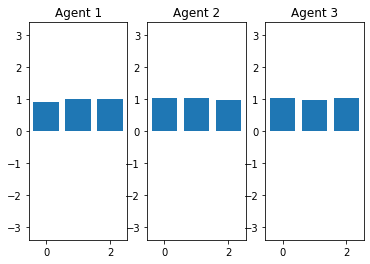

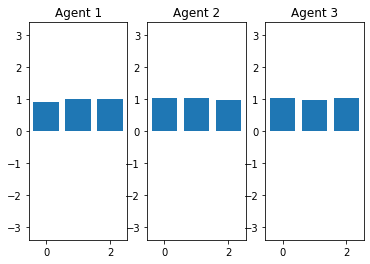

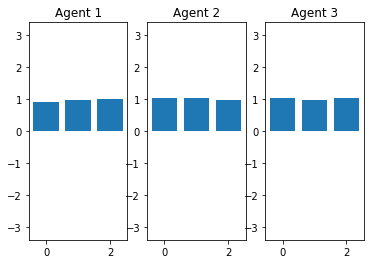

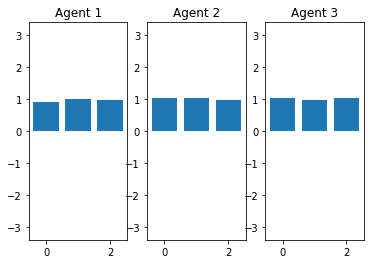

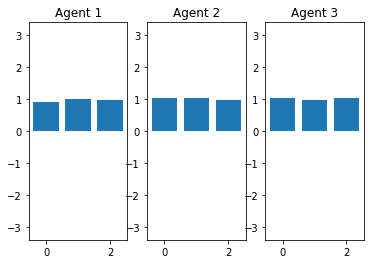

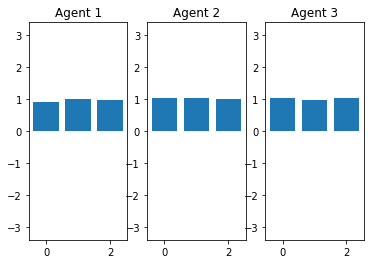

In [1961]:
for i in range(15):
    episode(env)

In [1962]:
yA = env.hist_ut_agents[0]
yB = env.hist_ut_agents[1]
yC = env.hist_ut_agents[2]
#yD = env.hist_ut_agents[3]
y = env.hist_SW

yA = [-x for x in yA]
yB = [-x for x in yB]
yC = [-x for x in yC]
#yD = [-x for x in yD]
y = [-x for x in y]

In [1194]:
env.hist_SW

[]

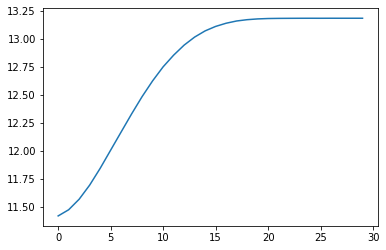

In [1256]:
plt.plot(np.arange(len(yA)),[-x for x in y])
plt.show()

In [1963]:
def mean_coop_degrees(matrix_list):
    if matrix_list == []:
        return []
    else:
        (n_A,_) = np.shape(matrix_list[0])
        output = [ [[] for _ in range(n_A)], [[] for _ in range(n_A)] ]  #curves for mean receiving AND sending coop degree 
        for coop_degrees_mat in matrix_list:
            rece_coop = coop_degrees_mat.sum(0)
            send_coop = coop_degrees_mat.sum(1)
            for i_A in range(n_A):
                mean_rece = (rece_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[0][i_A].append(mean_rece)    #receiving coop degree mean for agent i_A

                mean_send = (send_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[1][i_A].append(mean_send)    #receiving coop degree mean for agent i_A

        return output

In [2043]:
def affiche(env, output,lu,uu,lc,uc):
    yA = env.hist_ut_agents[0]
    yB = env.hist_ut_agents[1]
    yC = env.hist_ut_agents[2]
    #yD = env.hist_ut_agents[3]
    y = env.hist_SW

    yA = [-x for x in yA]
    yB = [-x for x in yB]
    yC = [-x for x in yC]
    #yD = [-x for x in yD]
    y = [-x for x in y]
    
    mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)
    
    figure_utilities(y, [yA,yB,yC],'evolution_utilities_'+output+'.svg',10, lu, uu)
    
    figure_coop_degrees_mean(mean_coop_degrees_expe, 'evolution_cooperation_'+output+'.svg',10, lc, uc)
    

In [1964]:
mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)

In [2044]:
def figure_utilities(sw, list_ut, output_fig, max_t,lu,uu):
    colors = ['b','m','c','r']
    t_max = min(len(sw), max_t)
    t = np.arange(t_max)
    
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize = 14)
    ax1.set_ylabel('Social Welfare', color='g', fontsize = 14)
    ax1.plot(t, sw[:t_max], color='g', label="Social Welfare")
    ax1.tick_params(axis='y', labelcolor='g', labelsize = 14)
    plt.legend(loc=2, fontsize=13)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Individual Utility', color=color, fontsize = 14) 
    ax2.set_ylim(lu, uu)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)



    for i_A in range(len(list_ut)):
        color = colors[i_A]
        label = "Agent "+str(i_A+1)
        if i_A == 5:
            label = "Egoist"
        ax2.plot(t, list_ut[i_A][:t_max], color=color, label=label)
    
    plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

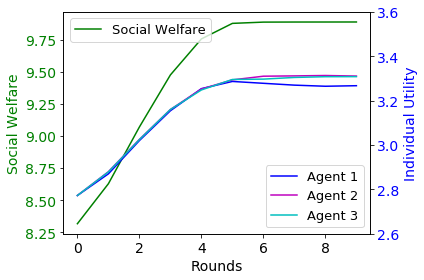

In [1982]:
figure_utilities(y, [yA,yB,yC],'evolution_utilities_3items-allNices.svg',10)

In [2041]:
def figure_coop_degrees_mean(list_coop, output_fig, max_t,lc,uc):
    colors = ['b','m','c','g','r']
    
    t_max = min(len(list_coop[0][0]), max_t)
    t = np.arange(t_max)

    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize=14)
    ax1.set_ylabel('Mean Cooperation Degree',fontsize=14)

    ax1.set_ylim(lc, uc)

    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    


    for i_A in range(len(list_coop[0])):
        color = colors[i_A]
        if i_A != 5:
            label = "Agent "+str(i_A+1)
        else:
            label = "Egoist"
        ax1.plot(t, list_coop[0][i_A][:t_max], color, label = label + " : receiving")
        ax1.plot(t, list_coop[1][i_A][:t_max], color+"--", label = label + " : sending")
        plt.legend(loc=4,fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

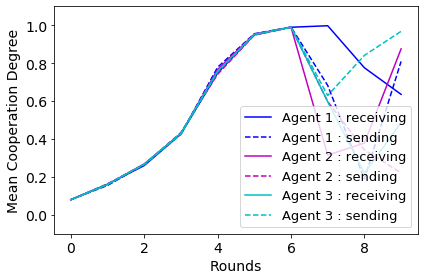

In [1985]:
figure_coop_degrees_mean(mean_coop_degrees_expe, "coop_deg_3items_allNices.svg",10)

In [2042]:
env = Environment(3,3, liste_agents_A)
env.init_state(state_E)


In [2009]:
def effiency(list_SW, SWopt):
    SW0 = list_SW[0]
    output = []
    
    for sw in list_SW:
        e = min((-sw+SW0)/(-SWopt+SW0),1)
        output.append(e)
        
    return output
    

In [2010]:
from sklearn import metrics

def speed(list_eff, T):
    final_efficiency = list_eff[-1]
    x = np.arange(T)    
    return metrics.auc(x, list_eff[:T])/(T*final_efficiency)

In [2087]:
def analyse(state, beta, r, alpha, N_iter=10):
    algo = DTFT(beta,r,alpha)
    egoist = DTFT(1,0,0.5)

    n_A, n_I = np.shape(state)
    
    T_speed = 10
    
    T_speed = min(T_speed, N_iter)

    
    a1 = Agent(0, n_A, n_I, algo)
    a2 = Agent(1, n_A, n_I, algo)
    a3 = Agent(2, n_A, n_I, algo)

    b1 = Agent(0, n_A, n_I, algo)
    b2 = Agent(1, n_A, n_I, algo)
    b3 = Agent(2, n_A, n_I, egoist)
    
    c1 = Agent(0, n_A, n_I, algo)
    c2 = Agent(1, n_A, n_I, egoist)
    c3 = Agent(2, n_A, n_I, egoist)

    liste_agents_A = [a1, a2, a3]
    liste_agents_B = [b1, b2, b3]
    liste_agents_C = [c1, c2, c3]
    
    envA = Environment(nA,nI, liste_agents_A)
    envA.init_state(state_E)
    
    envB = Environment(nA,nI, liste_agents_B)
    envB.init_state(state_E)
    
    envC = Environment(nA,nI, liste_agents_C)
    envC.init_state(state_E)
    
    tra, ns, swopt = envA.optimize_globably()
    
    
    for i_ep in range(N_iter):
        print("Env A, episode ", i_ep)
        iteration2(envA)
        
    for i_ep in range(N_iter):
        print("Env B, episode ", i_ep)
        iteration2(envB)
        
    for i_ep in range(N_iter):
        print("Env C, episode ", i_ep)
        iteration2(envC)
        
    
    effic = effiency(envA.hist_SW, swopt)
    
    ef = effic[-1]

    sp = speed(effic, T_speed)
    
    ut_max_pers_nices = -1*envA.hist_ut_agents[2][-1] #positive
    ut_pers_3egoist = -1*envA.hist_ut_agents[0][0] #positive  
    ut_pers_1egoist = -1*envB.hist_ut_agents[2][-1] #positive
    ut_pers_2egoist = -1*envC.hist_ut_agents[0][-1] #positive

    
    print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)
    
    ic = (ut_max_pers_nices-ut_pers_1egoist)/ut_max_pers_nices
    sf = (ut_pers_2egoist-ut_pers_3egoist)
    
    
    
    return [[beta, r, alpha],[envA, envB, envC], ef, sp, ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist]
    
    
    
    

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

[[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
Env B, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best obj

ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1

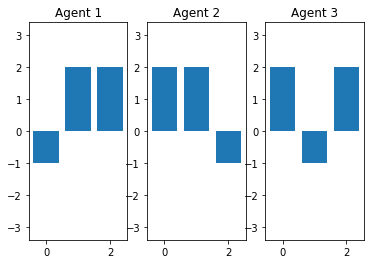

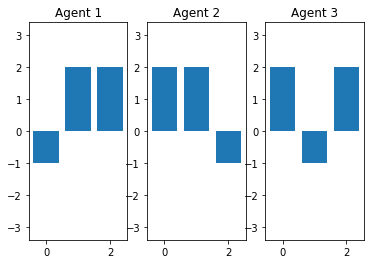

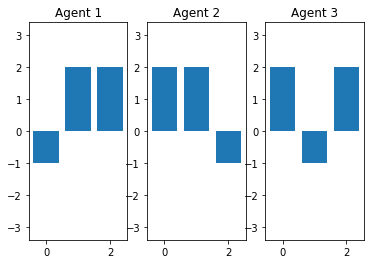

In [2088]:
beta = 0.1
r = 0.1
alpha = 0
N_iter = 1
a = analyse(state_E, beta, r, alpha, N_iter)

In [2085]:
envD = a[0]
envE = a[1]
envF = a[2]



ut_max_pers_nices = -1*envD.hist_ut_agents[2][-1] #positive
ut_pers_3egoist = -1*envD.hist_ut_agents[0][0] #positive  
ut_pers_1egoist = -1*envE.hist_ut_agents[2][-1] #positive
ut_pers_2egoist = -1*envF.hist_ut_agents[0][-1] #positive

ic = ut_max_pers_nices-ut_pers_1egoist
sf = ut_pers_2egoist - ut_pers_3egoist

print(ic, sf)

print(ut_max_pers_nices, ut_pers_1egoist, ut_pers_2egoist, ut_pers_3egoist)

-0.49221771575462503 -0.6434922428700678
3.2962472721683795 3.7884649879230046 2.1290964943697133 2.772588737239781


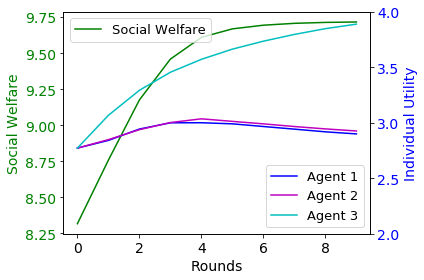

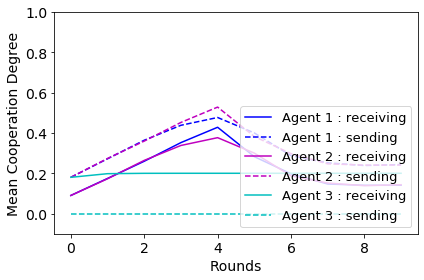

In [2081]:
affiche(envE,'One_egoist',2,4,-0.1,1)

In [2089]:
def all_expe(liste_bra):
    output = []
    for x in liste_bra:
        beta, r, alpha = x
        N_iter = 15
        a = analyse(state_E, beta, r, alpha, N_iter)
        output.append(a)
    
    return output

In [2092]:
liste_exp = [(0.1,0.05,0),(0.1,0.02,0),(0.3,0.1,0),(0.5,0.1,0),(0.7,0.1,0),(0.1,0.1,0.3),(0.1,0.1,0.5),(0.1,0.1,0.7)]

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.045 0.045 0.045]

[[0.045 0.045 0.045]
 [0.045 0.045 0.045]
 [0.045 0.045 0.045]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.04834141 0.04796609]
coop deg negociated  [0.0495     0.09083191 0.09051101]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.04872648 0.       

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.78673811 1.         0.        ]
coop deg negociated  [0.81053305 0.99581108 0.05      ]

[[0.05       0.24232794 0.9270862 ]
 [0.73739486 0.05       0.97247691]
 [0.81053305 0.99581108 0.05      ]]
Env A, episode  12
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.05       0.92423279 0.99270862]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.11873949 0.05       0.14224769]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.98105331 0.99958111 0.05      ]

[[0.05       0.92423279 0.99270862]
 [0.11873949 0.05       0.14224769]
 [0.98105331 0.99958111 0.05      ]]
Env A, episode  13
Stopping search: Swarm best obj

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.22237232 0.        ]
coop deg negociated  [0.04999995 0.25752592 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.22055029 0.         0.        ]
coop deg negociated  [0.25597841 0.04999995 0.04999995]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0519088 0.0497995 0.       ]
coop deg negociated  [0. 0. 0.]

[[0.04999995 0.25752592 0.04999995]
 [0.25597841 0.04999995 0.04999995]
 [0.         0.         0.        ]]
Env B, episode  6
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21997643 0.        ]
coop deg negociated  [0.05       0.25883244 0.05      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.22328687 0.         0. 

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.04995 0.04995 0.04995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.0517294 0.        0.       ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05062722 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.04995 0.04995 0.04995]
 [0.      0.      0.     ]
 [0.      0.      0.     ]]
Env C, episode  3
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.049995 0.049995 0.049995]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.04976676 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
co

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.018 0.018 0.018]

[[0.018 0.018 0.018]
 [0.018 0.018 0.018]
 [0.018 0.018 0.018]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.01938609 0.01983597]
coop deg negociated  [0.0198     0.03689853 0.03729532]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.01852581 0.         0.01735703]
coop deg negociated  [0.03613976 0.0198     0.0351089 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01853376 0.01792269 0.        ]
coop deg negociated  [0.03614677 0.03560781 0.0198    ]

[[0.0198     0.03689853 0.03729532]
 [0.03613976 0.0198     0.0351089 ]
 [0.03614677 0.03560781 0.0198    ]]
Env A, episode  2
Stopping search: Swarm best objective change 

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.02       0.98257786 0.98749216]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.9952245  0.02       0.99504355]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.98415979 0.99422292 0.02      ]

[[0.02       0.98257786 0.98749216]
 [0.9952245  0.02       0.99504355]
 [0.98415979 0.99422292 0.02      ]]
Env A, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.68996599 1.        ]
coop deg negociated  [0.02       0.72480779 0.99874922]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.692580

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.10499054 0.        ]
coop deg negociated  [0.02       0.12327308 0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10230468 0.         0.        ]
coop deg negociated  [0.12086264 0.02       0.02      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01981613 0.01971567 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.02       0.12327308 0.02      ]
 [0.12086264 0.02       0.02      ]
 [0.         0.         0.        ]]
Env B, episode  10
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09157297 0.        ]
coop deg negociated  [0.02       0.11109467 0.02      ]

Stopping search: Swarm best objective change less 

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.02064435 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
Env C, episode  7
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.02 0.02 0.02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.02046016 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01967982 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.02 0.02 0.02]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
Env C, episode  8
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.45233868 0.41082344 0.        ]
coop deg negociated  [0.4452504  0.42190118 0.099757  ]

[[0.099757   0.44958078 0.42386609]
 [0.41881686 0.099757   0.44716704]
 [0.4452504  0.42190118 0.099757  ]]
Env A, episode  5
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.7417709 0.8016629]
coop deg negociated  [0.0999271  0.6721899  0.70220745]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.75364173 0.         0.66381567]
coop deg negociated  [0.67043935 0.0999271  0.62235399]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.76876317 0.82750489 0.        ]
coop deg negociated  [0.68789592 0.71789844 0.0999271 ]

[[0.0999271  0.6721899  0.70220745]
 [0.67043935 0.0999271  0.62235399]
 [0.68789592 0.7178

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.07344145 0.07363172 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.091      0.13758332 0.091     ]
 [0.13727254 0.091      0.091     ]
 [0.         0.         0.        ]]
Env B, episode  2
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.15515268 0.        ]
coop deg negociated  [0.0973     0.20902119 0.0973    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.14461829 0.         0.        ]
coop deg negociated  [0.20229129 0.0973     0.0973    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.09789589 0.09636438 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0973     0.20902119 0.0973    ]
 [0.20229129 0.0973     0.0973    ]
 [0.         0.         0.        ]]
Env B, episode  3
Stopping 

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.07484308 0.         0.        ]
coop deg negociated  [0.16659787 0.1        0.1       ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10897847 0.10012201 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.1        0.16827503 0.1       ]
 [0.16659787 0.1        0.1       ]
 [0.         0.         0.        ]]
Env B, episode  14
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.06676572 0.        ]
coop deg negociated  [0.1        0.16254491 0.1       ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.07174514 0.         0.        ]
coop deg negociated  [0.1651788 0.1       0.1      ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.08854882 0.09917436 0.

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.1099481 0.        0.       ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.1036458 0.        0.       ]
coop deg negociated  [0. 0. 0.]

[[0.09999995 0.09999995 0.09999995]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Env C, episode  12
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09999998 0.09999998 0.09999998]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.10056237 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10907693 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.09999998 0.09999998 0.099999

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.84690818 0.09980469 0.82093749]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1. 1. 0.]
coop deg negociated  [0.82265975 0.83580426 0.09980469]

[[0.09980469 0.81540955 0.84522291]
 [0.84690818 0.09980469 0.82093749]
 [0.82265975 0.83580426 0.09980469]]
Env A, episode  9
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.09990234 0.90770478 0.92261145]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [0.92345409 0.09990234 0.91046874]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.81004148 1.         0.        ]
coop deg negociated  [0.82584854 0.91790213 0.09990234]

[[0

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10355412 0.10755799 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0984375  0.27521462 0.0984375 ]
 [0.28312994 0.0984375  0.0984375 ]
 [0.         0.         0.        ]]
Env B, episode  6
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.27417454 0.        ]
coop deg negociated  [0.09921875 0.31098585 0.09921875]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.2545405 0.        0.       ]
coop deg negociated  [0.3061082  0.09921875 0.09921875]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10851668 0.10418801 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.09921875 0.31098585 0.09921875]
 [0.3061082  0.09921875 0.09921875]
 [0.         0.         0.        ]]
Env B, episode  7
Stopping sea

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09375 0.09375 0.09375]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.0916294 0.        0.       ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0913408 0.        0.       ]
coop deg negociated  [0. 0. 0.]

[[0.09375 0.09375 0.09375]
 [0.      0.      0.     ]
 [0.      0.      0.     ]]
Env C, episode  4
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.096875 0.096875 0.096875]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.0959113 0.        0.       ]
coop deg negociated  [0. 0. 0.]

Stopping search: 

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.03 0.03 0.03]

[[0.03 0.03 0.03]
 [0.03 0.03 0.03]
 [0.03 0.03 0.03]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.03193229 0.03166979]
coop deg negociated  [0.051      0.05962172 0.05955084]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.03144658 0.         0.03016304]
coop deg negociated  [0.05949058 0.051      0.05914402]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.03106821 0.03021646 0.        ]
coop deg negociated  [0.05938842 0.05915845 0.051     ]

[[0.051      0.05962172 0.05955084]
 [0.05949058 0.051      0.05914402]
 [0.05938842 0.05915845 0.051     ]]
Env A, episode  2
Stopping search: Swarm best objective change less than 1e

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.09903111 0.72199817 0.71860837]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.82851504 0.         1.        ]
coop deg negociated  [0.66876403 0.09903111 0.66331316]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.86428179 0.9157425  0.        ]
coop deg negociated  [0.60031158 0.61902746 0.09903111]

[[0.09903111 0.72199817 0.71860837]
 [0.66876403 0.09903111 0.66331316]
 [0.60031158 0.61902746 0.09903111]]
Env A, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.09932178 0.80539872 0.80302586]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21027491 0.        ]
coop deg negociated  [0.09717525 0.25492918 0.09717525]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.20494416 0.         0.        ]
coop deg negociated  [0.25379577 0.09717525 0.09717525]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.10427583 0.10236696 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.09717525 0.25492918 0.09717525]
 [0.25379577 0.09717525 0.09717525]
 [0.         0.         0.        ]]
Env B, episode  10
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.21188811 0.        ]
coop deg negociated  [0.09802267 0.26566021 0.09802267]

Stopping search: Swarm best objective change less 

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0889854 0.        0.       ]
coop deg negociated  [0. 0. 0.]

[[0.09176457 0.09176457 0.09176457]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Env C, episode  7
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.0942352 0.0942352 0.0942352]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09831753 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.09450344 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0942352 0.0942352 0.0942352]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
Env C, episode  8
Stopping search: Swarm best objective change less than 1e-08
Stopping se

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.90353164 0.88217084]
coop deg negociated  [0.02501219 0.88572013 0.87630054]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.99178141 0.         0.98126077]
coop deg negociated  [0.94263088 0.02501219 0.93411911]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.98977057 0.94169444 0.        ]
coop deg negociated  [0.94191497 0.90949682 0.02501219]

[[0.02501219 0.88572013 0.87630054]
 [0.94263088 0.02501219 0.93411911]
 [0.94191497 0.90949682 0.02501219]]
Env A, episode  5
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.01710803 0.98857201 0.98763005]

Stopping search: Swarm best objective change less t

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09408157 0.        ]
coop deg negociated  [0.0747     0.17620442 0.0747    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09941328 0.         0.        ]
coop deg negociated  [0.18181368 0.0747     0.0747    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.09129097 0.09749719 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0747     0.17620442 0.0747    ]
 [0.18181368 0.0747     0.0747    ]
 [0.         0.         0.        ]]
Env B, episode  2
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.2014559 0.       ]
coop deg negociated  [0.053001   0.27712413 0.053001  ]

Stopping search: Swarm best objective change less than

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.00170369 0.0016646  0.        ]
coop deg negociated  [0. 0. 0.]

[[0.00119539 0.00036649 0.00119539]
 [0.00035413 0.00119539 0.00119539]
 [0.         0.         0.        ]]
Env B, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.00000000e+00 9.24962769e-05 0.00000000e+00]
coop deg negociated  [0.00081735 0.0001199  0.00081735]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [8.96269984e-05 0.00000000e+00 0.00000000e+00]
coop deg negociated  [0.00011608 0.00081735 0.00081735]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0011746  0.00120262 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.00081735 0.0001199  0.00081735]
 [0.00011608 0.00081735 0.00081735]
 [0.         0.         0.        ]]
En

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.00255693 0.00255693 0.00255693]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.00377751 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.00377139 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.00255693 0.00255693 0.00255693]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Env C, episode  11
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.00174829 0.00174829 0.00174829]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.00263372 0.         0.        

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [3.84060727e-04 9.29738383e-01 9.82431309e-01]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1. 0. 1.]
coop deg negociated  [9.99949420e-01 3.84060727e-04 9.99948793e-01]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.9540597  0.08342806 0.        ]
coop deg negociated  [9.40627127e-01 9.77717826e-02 3.84060727e-04]

[[3.84060727e-04 9.29738383e-01 9.82431309e-01]
 [9.99949420e-01 3.84060727e-04 9.99948793e-01]
 [9.40627127e-01 9.77717826e-02 3.84060727e-04]]
Env A, episode  8
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.1933977 1.       ]
coop deg negociated  [1.54997582e-04 2.90060469e-01 9.98243131e

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.29946618 0.        ]
coop deg negociated  [0.01301625 0.37527521 0.01301625]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.29979333 0.         0.        ]
coop deg negociated  [0.37578641 0.01301625 0.01301625]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0303193  0.03003648 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.01301625 0.37527521 0.01301625]
 [0.37578641 0.01301625 0.01301625]
 [0.         0.         0.        ]]
Env B, episode  4
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.36314951 0.        ]
coop deg negociated  [0.00555806 0.43222195 0.00555806]

Stopping search: Swarm best objective change less t

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.00000000e+00 6.65559554e-06 0.00000000e+00]
coop deg negociated  [6.43686301e-07 9.02110758e-06 6.43686301e-07]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [5.90424357e-06 0.00000000e+00 0.00000000e+00]
coop deg negociated  [8.95932419e-06 6.43686301e-07 6.43686301e-07]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1.57060379e-06 1.58147979e-06 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

[[6.43686301e-07 9.02110758e-06 6.43686301e-07]
 [8.95932419e-06 6.43686301e-07 6.43686301e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Env C, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [2.53093088e-05 0.00000000e+00 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

[[1.00305668e-05 1.00305668e-05 1.00305668e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Env C, episode  12
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [4.01759114e-06 4.01759114e-06 4.01759114e-06]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [9.99093211e-06 0.00000000e+00 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1.04565332e-05 0.00000000e+00 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

[[4.01759114e-06 4.01759114e-06 4.01759114e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.02862939 0.0148628 ]
coop deg negociated  [1.08810000e-08 3.61438762e-02 1.74184178e-02]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.3481392 0.        1.       ]
coop deg negociated  [4.25224388e-01 1.08810000e-08 9.99995315e-01]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01337584 0.41474065 0.        ]
coop deg negociated  [2.20695952e-02 5.63212388e-01 1.08810000e-08]

[[1.08810000e-08 3.61438762e-02 1.74184178e-02]
 [4.25224388e-01 1.08810000e-08 9.99995315e-01]
 [2.20695952e-02 5.63212388e-01 1.08810000e-08]]
Env A, episode  9
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.0317031 0.       ]
coop deg negociate

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.33188683 0.        ]
coop deg negociated  [1.08810000e-04 3.94078968e-01 1.08810000e-04]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.33767228 0.         0.        ]
coop deg negociated  [4.02242607e-01 1.08810000e-04 1.08810000e-04]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.00107152 0.00115466 0.        ]
coop deg negociated  [0. 0. 0.]

[[1.08810000e-04 3.94078968e-01 1.08810000e-04]
 [4.02242607e-01 1.08810000e-04 1.08810000e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Env B, episode  5
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.25533884 0.        ]
coop deg negociated  [1.08810000e-05 2.69212851e

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1.02603275e-13 1.06994836e-13 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

[[1.08810000e-14 2.93938769e-05 1.08810000e-14]
 [3.33307233e-05 1.08810000e-14 1.08810000e-14]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Env C, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

[[0.09 0.09 0.09]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
Env C, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [1.0881e-12 1.0881e-12 1.0881e-12]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1.10789595e-11 0.00000000e+00 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1.10052775e-11 0.00000000e+00 0.00000000e+00]
coop deg negociated  [0. 0. 0.]

[[1.0881e-12 1.0881e-12 1.0881e-12]
 [0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00]]
Env C, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [1.0881e-13 1.0881e-13 1.0881e-13]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [1.1013061e-12 0.0000000e+00 0.0000000e+00]
coop deg negociated  [0. 0

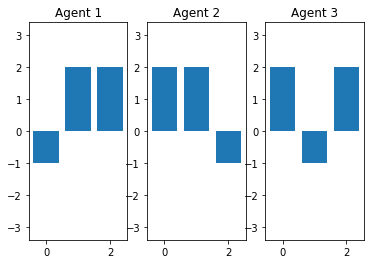

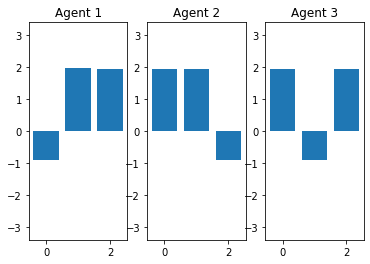

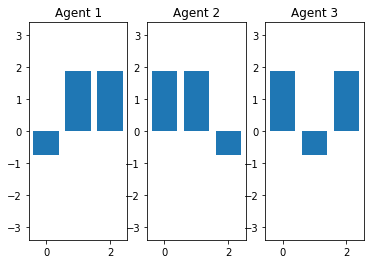

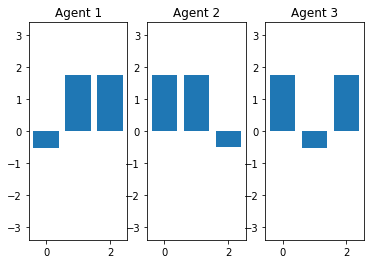

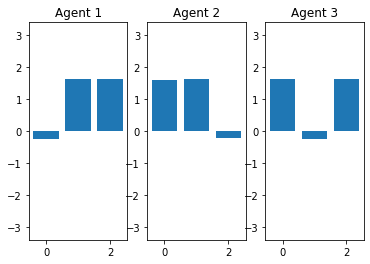

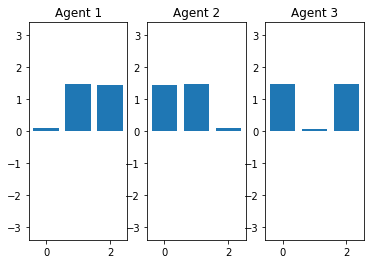

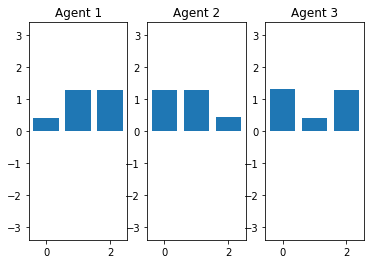

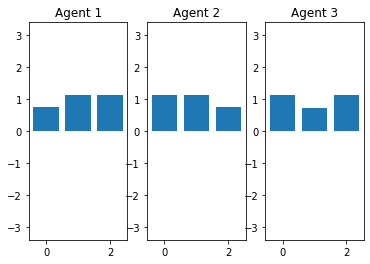

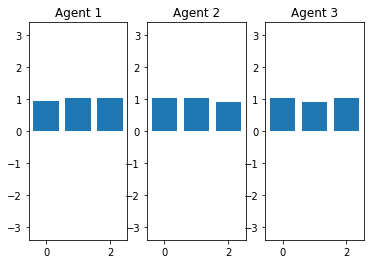

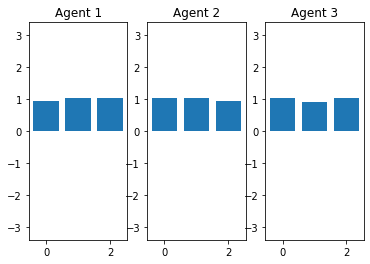

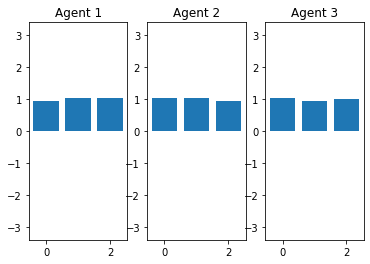

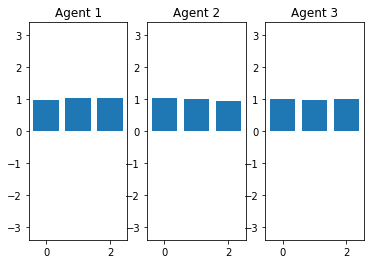

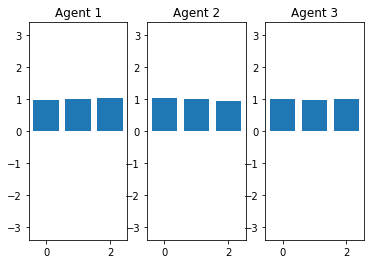

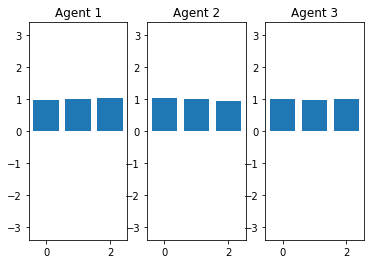

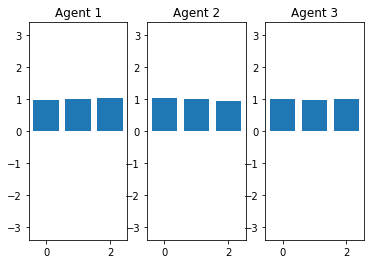

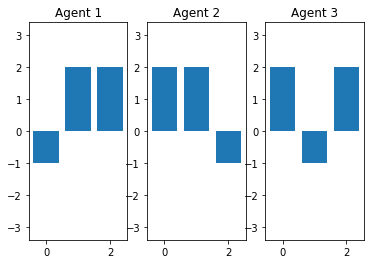

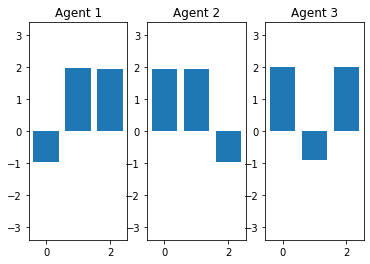

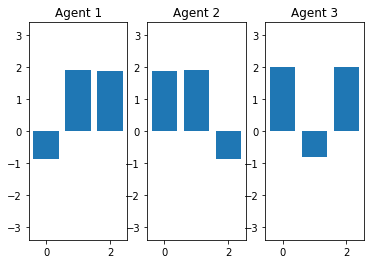

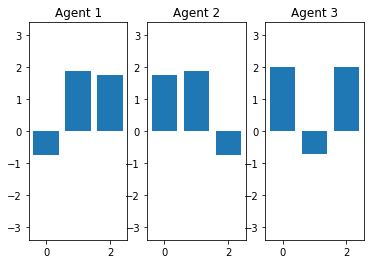

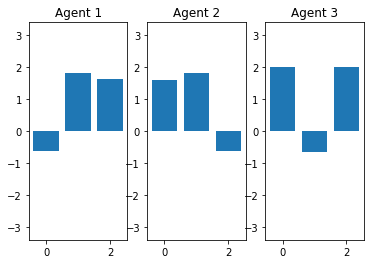

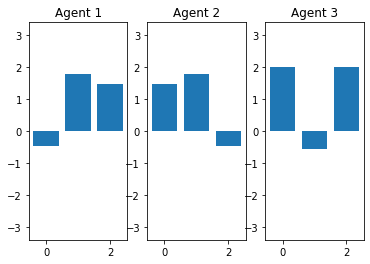

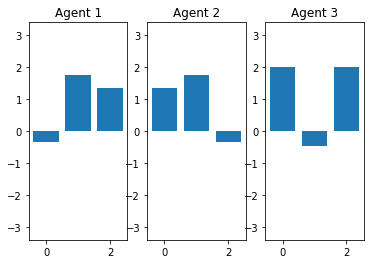

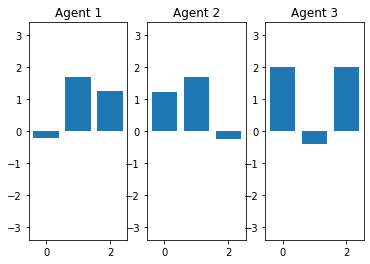

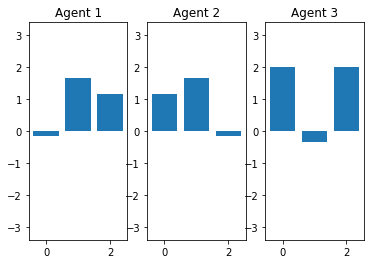

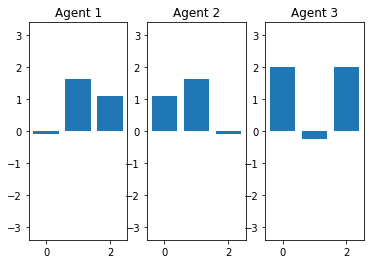

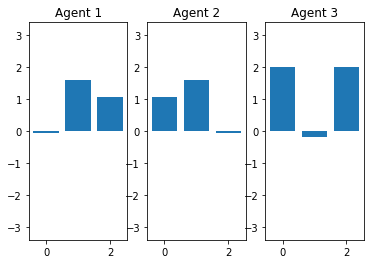

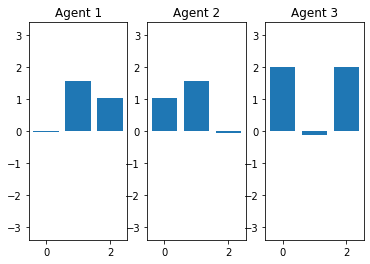

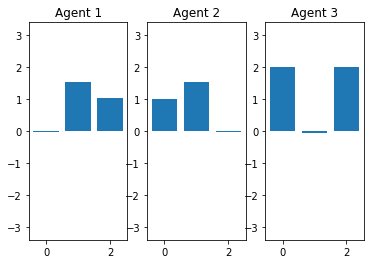

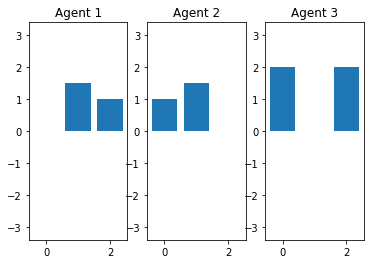

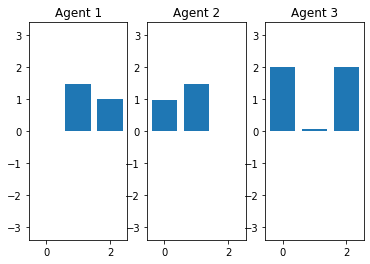

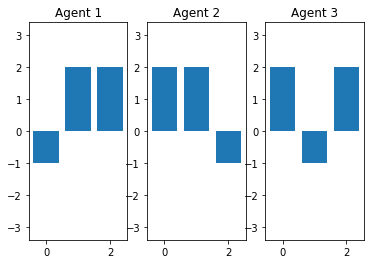

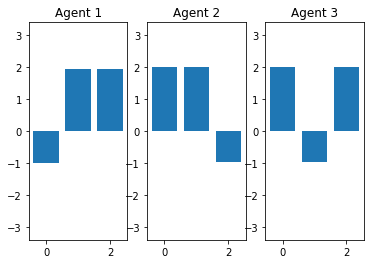

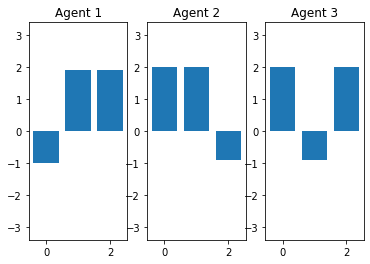

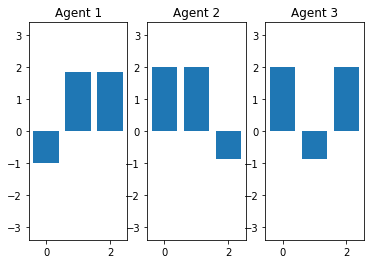

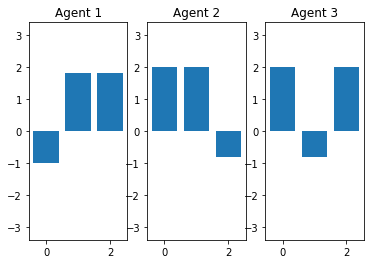

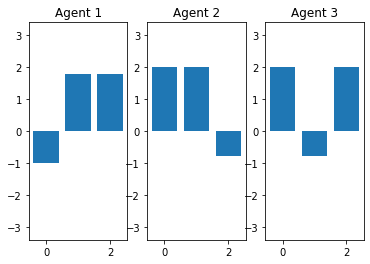

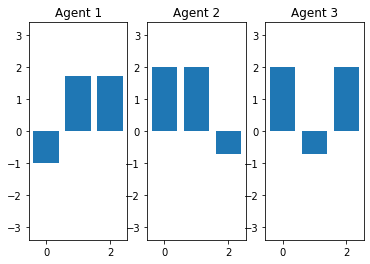

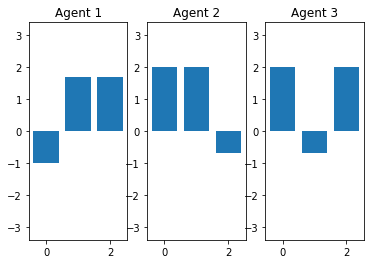

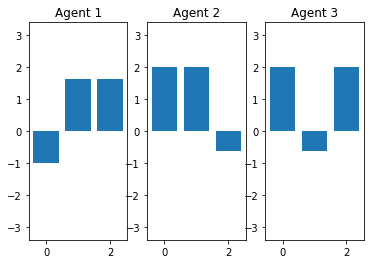

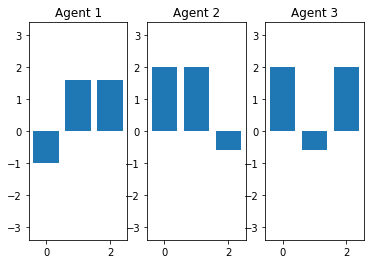

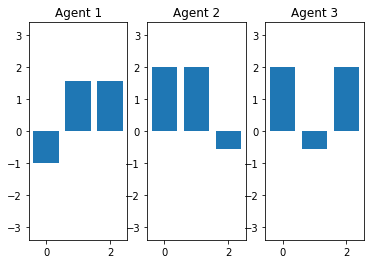

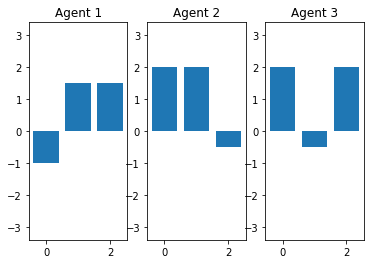

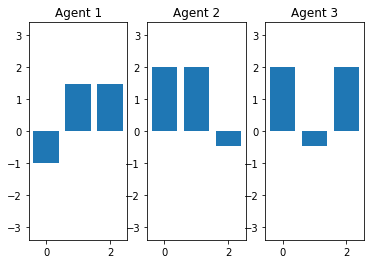

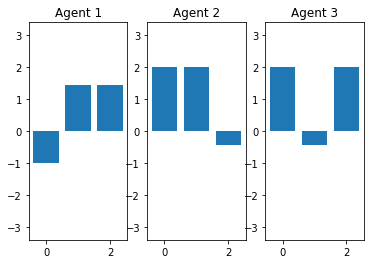

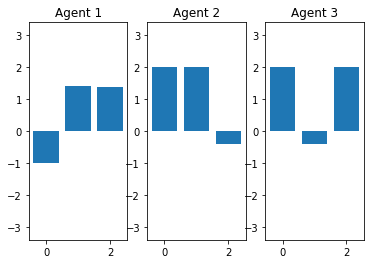

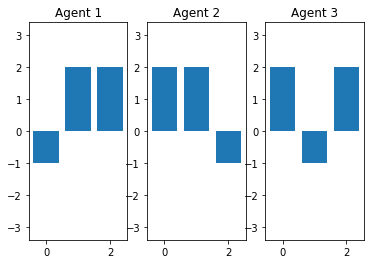

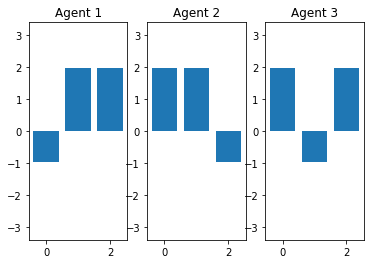

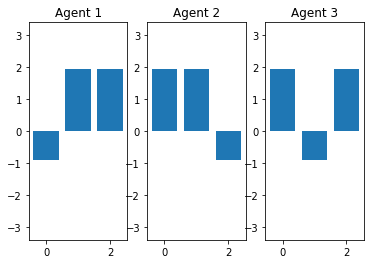

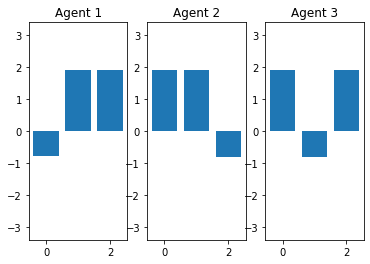

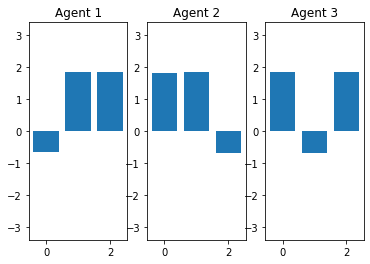

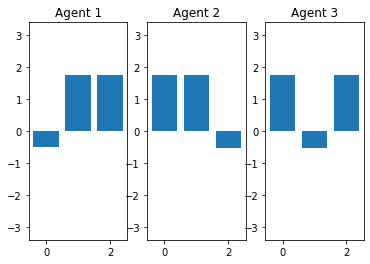

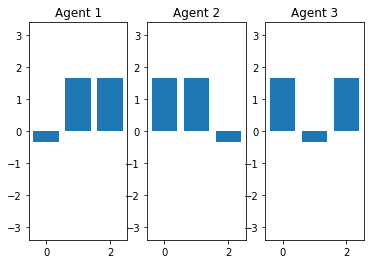

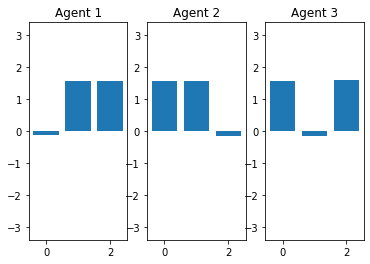

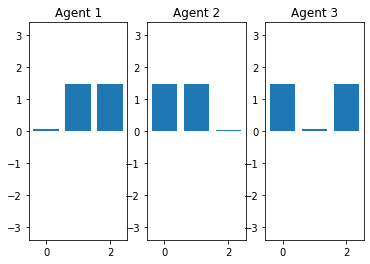

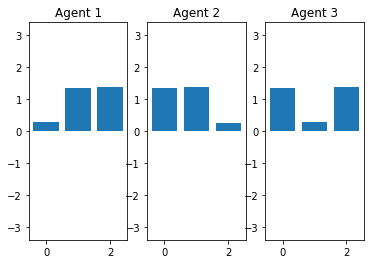

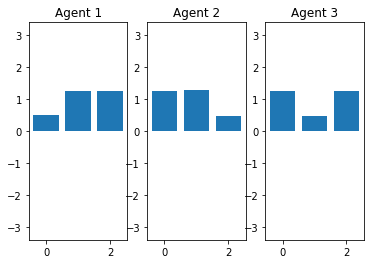

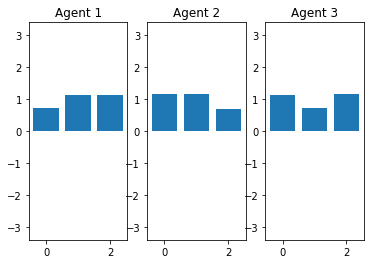

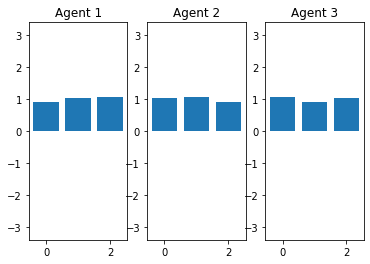

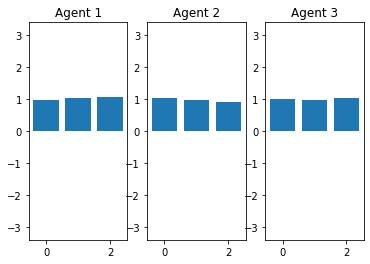

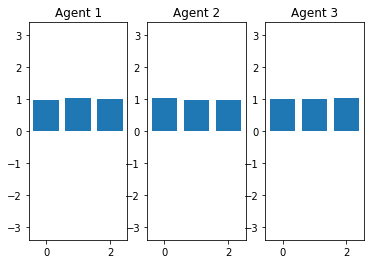

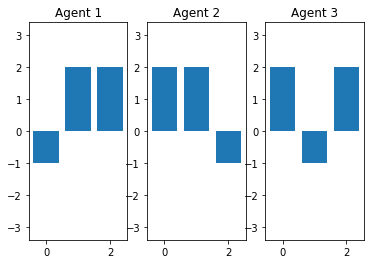

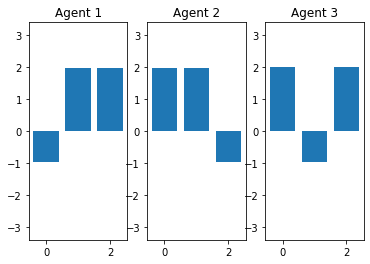

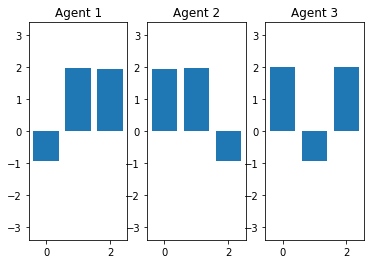

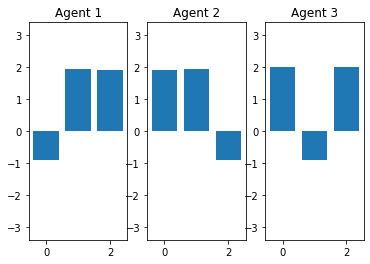

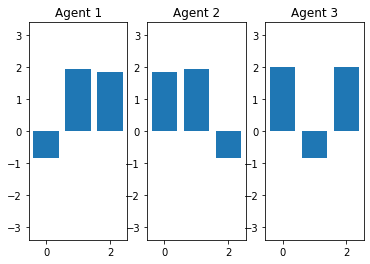

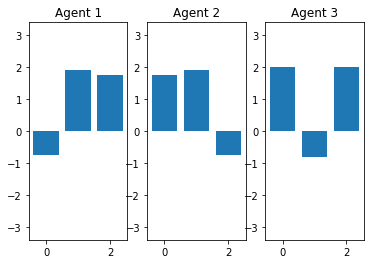

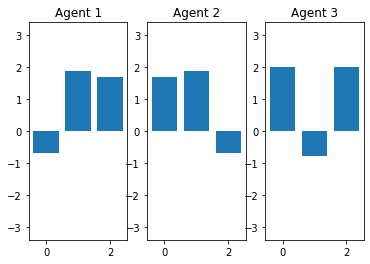

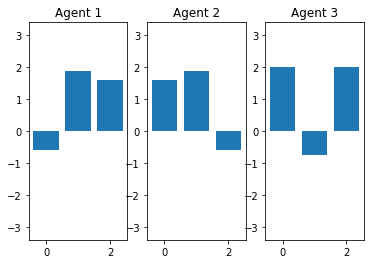

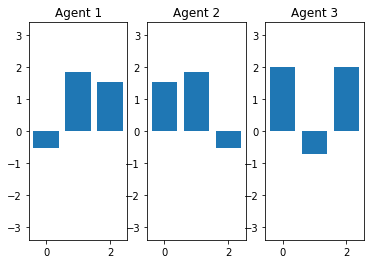

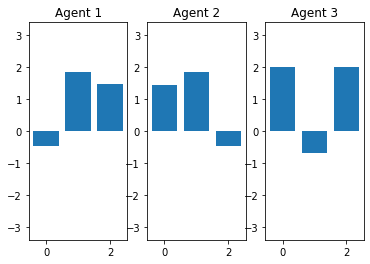

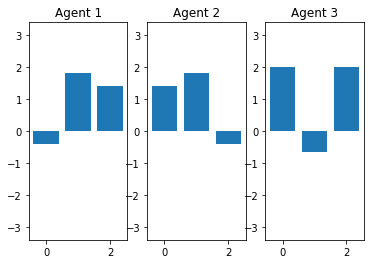

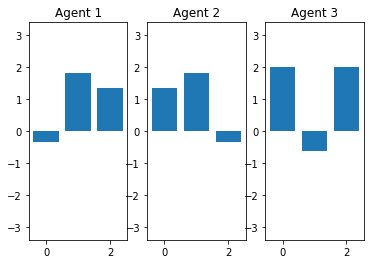

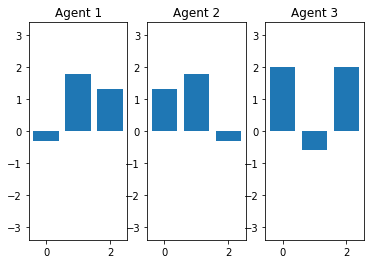

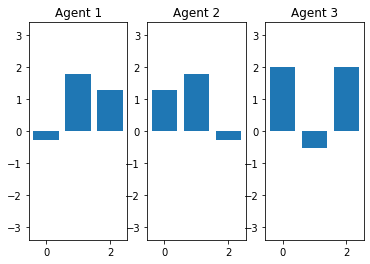

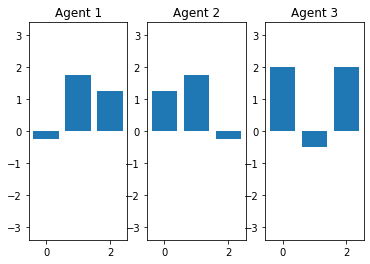

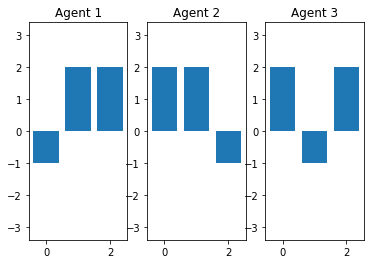

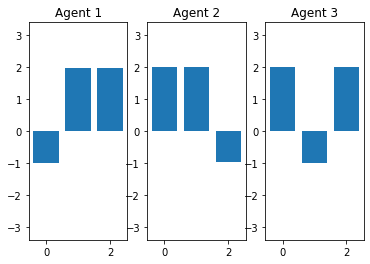

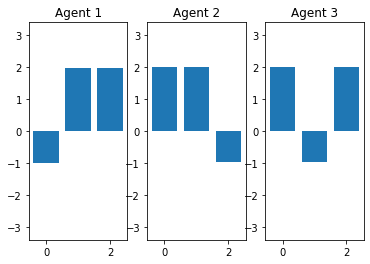

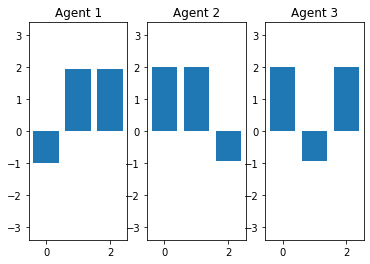

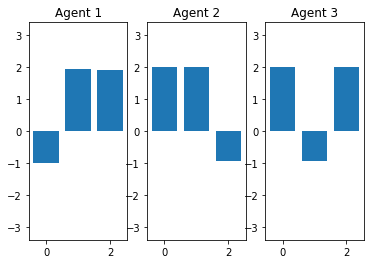

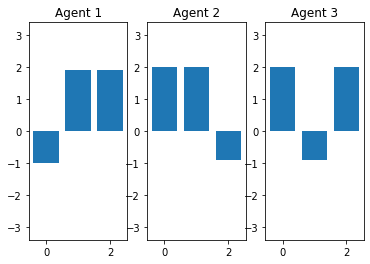

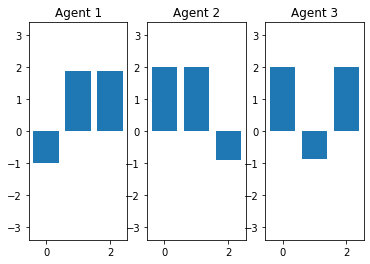

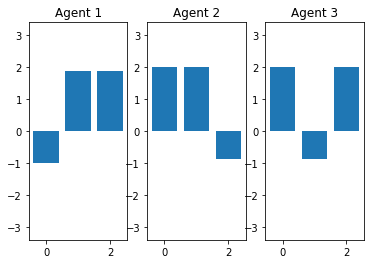

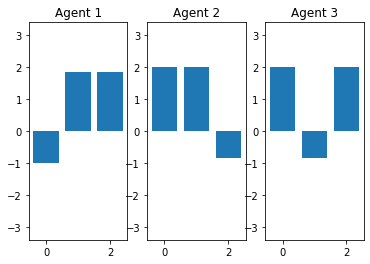

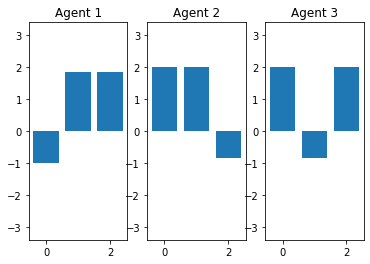

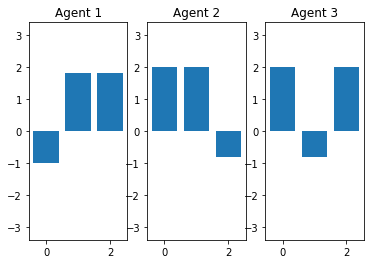

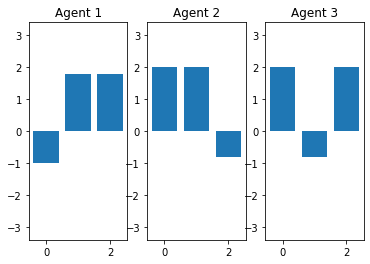

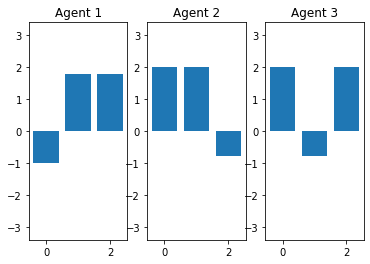

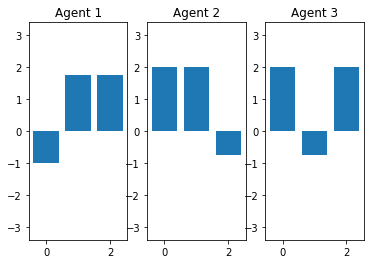

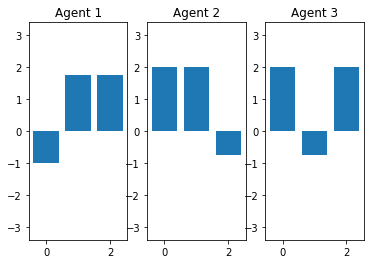

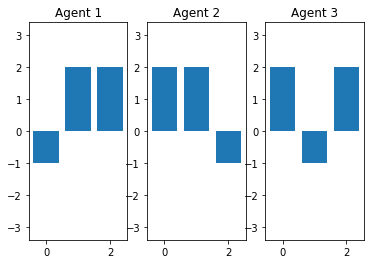

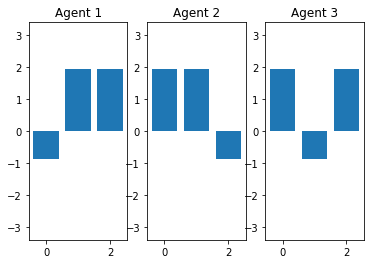

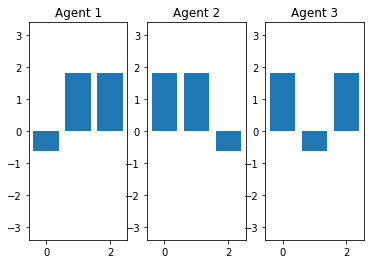

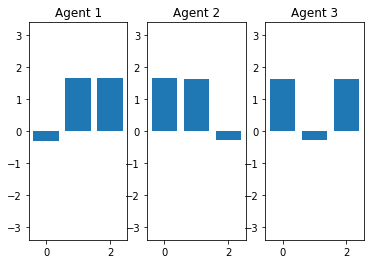

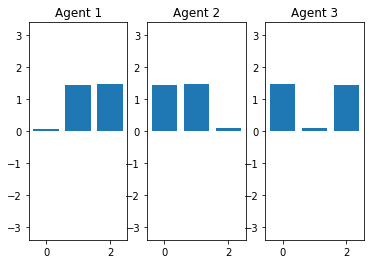

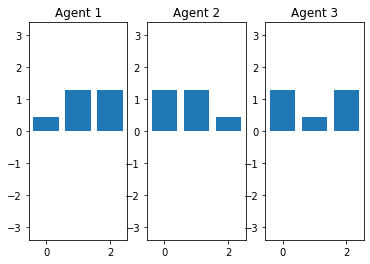

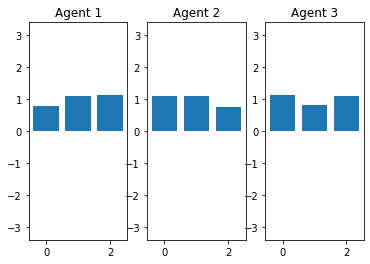

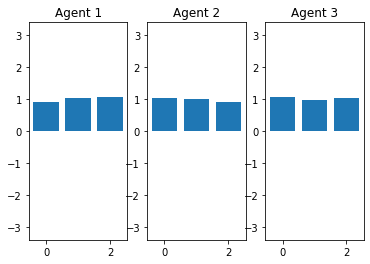

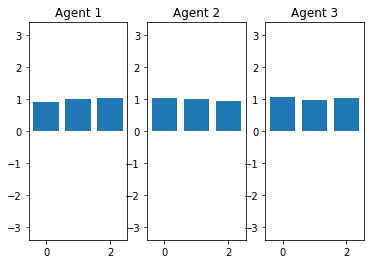

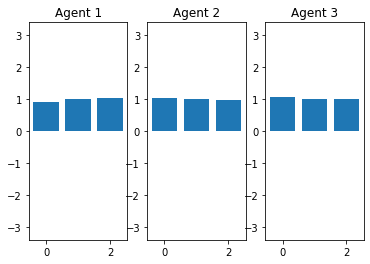

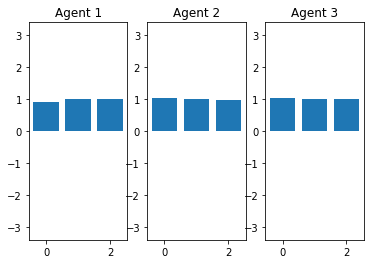

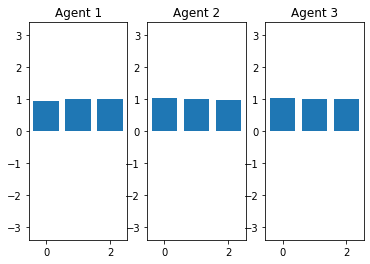

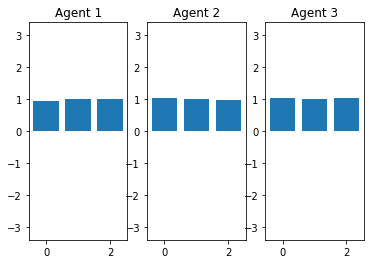

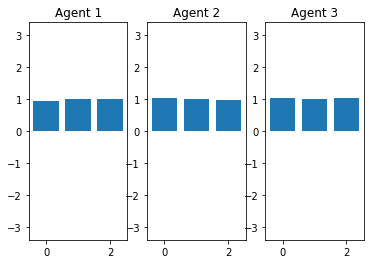

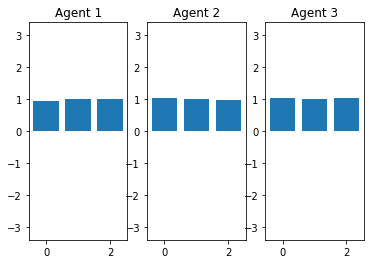

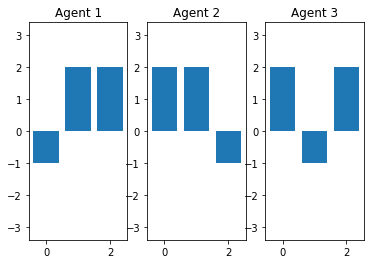

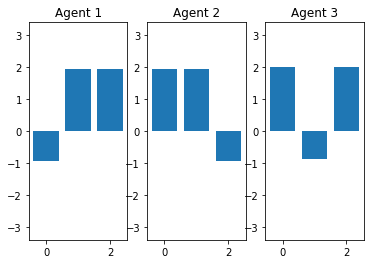

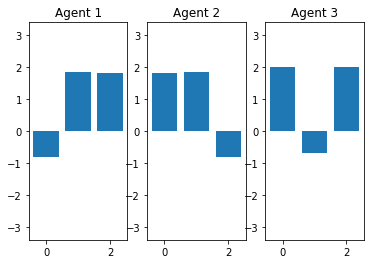

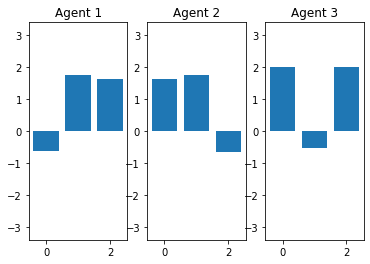

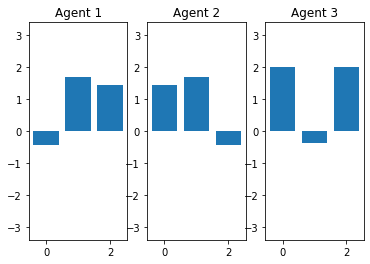

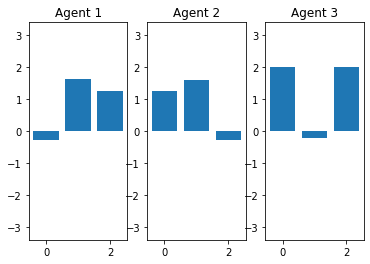

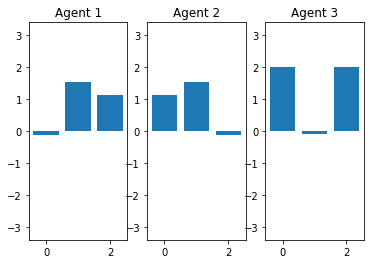

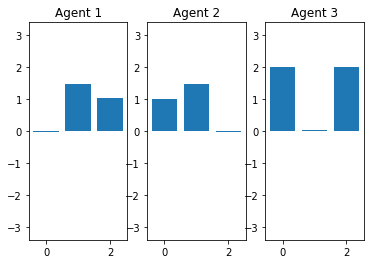

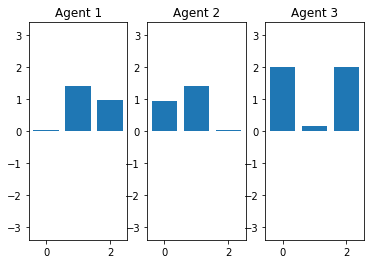

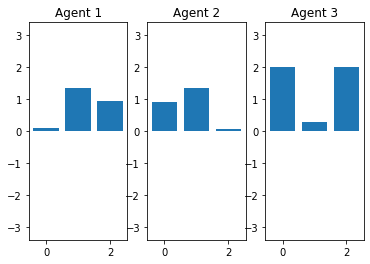

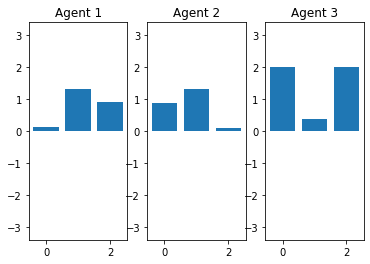

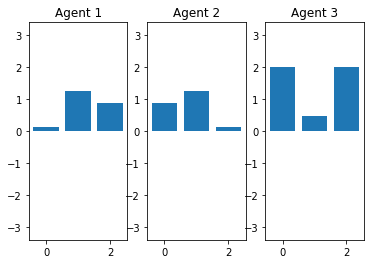

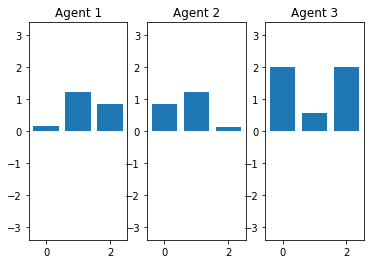

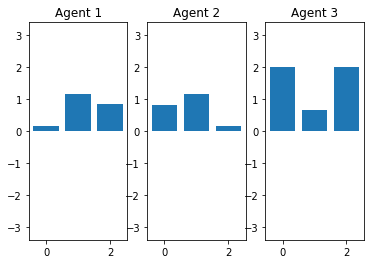

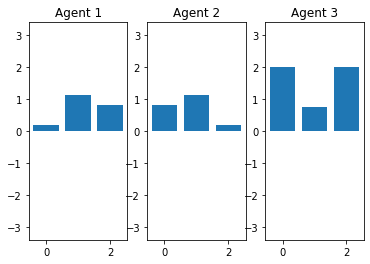

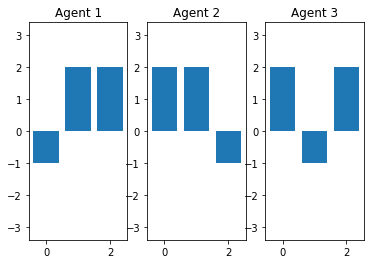

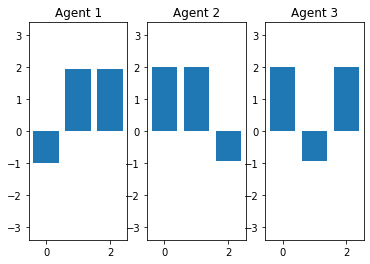

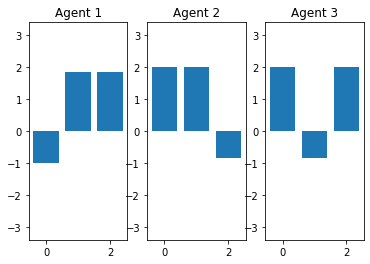

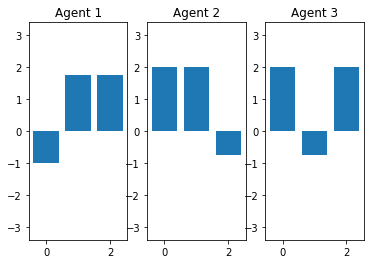

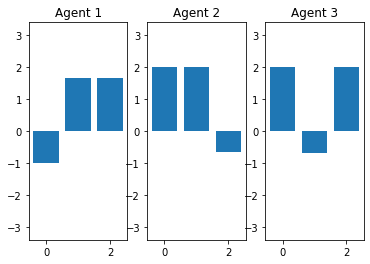

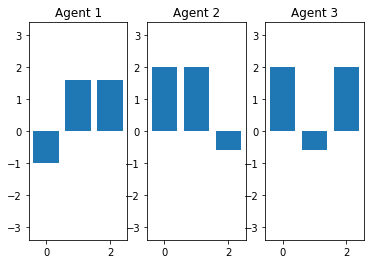

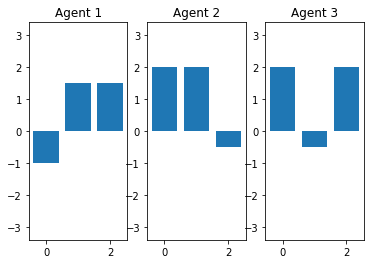

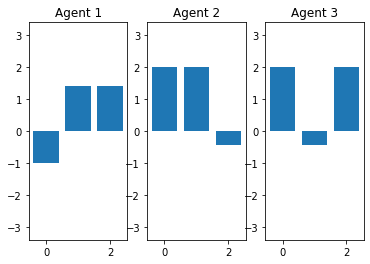

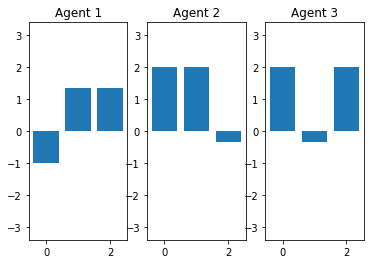

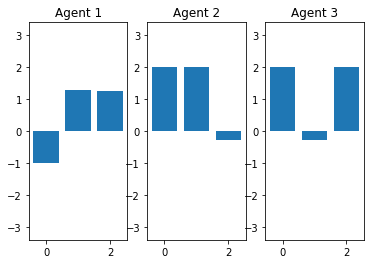

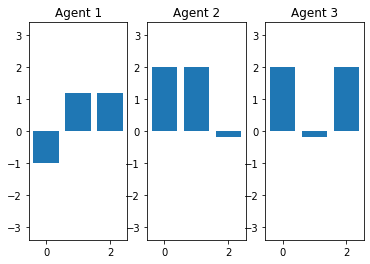

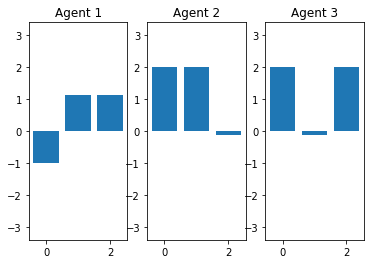

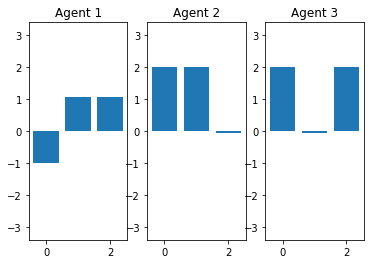

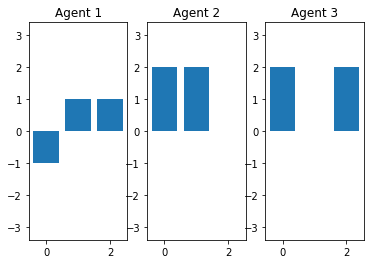

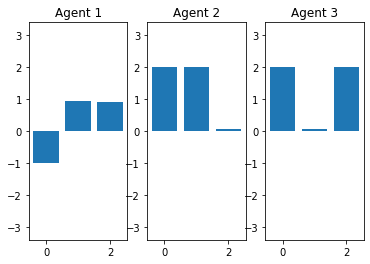

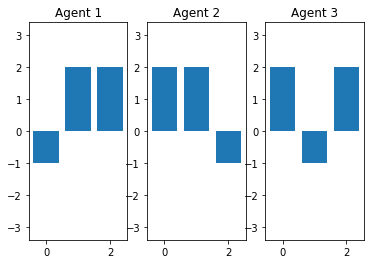

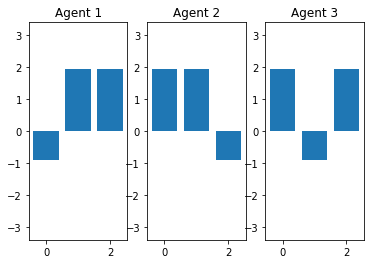

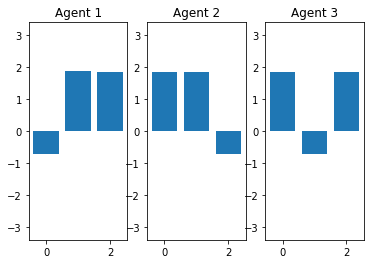

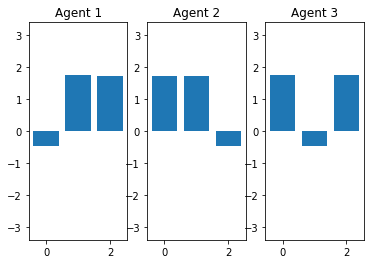

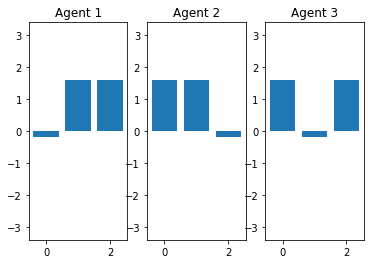

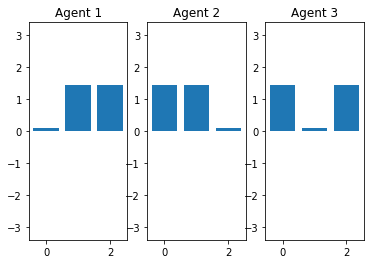

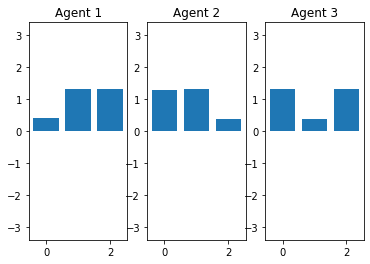

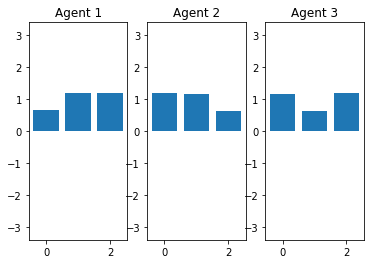

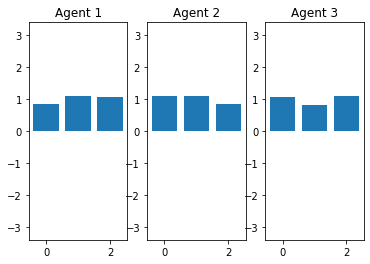

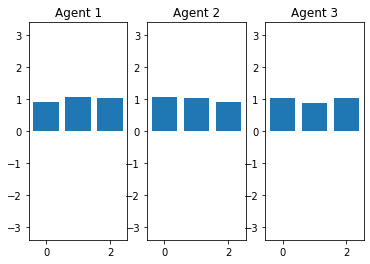

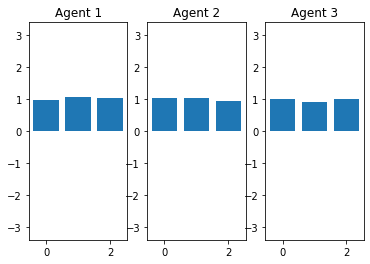

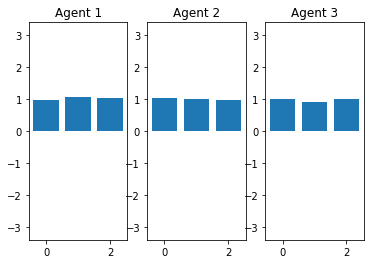

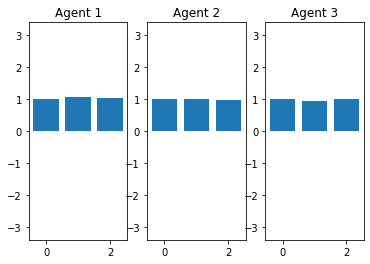

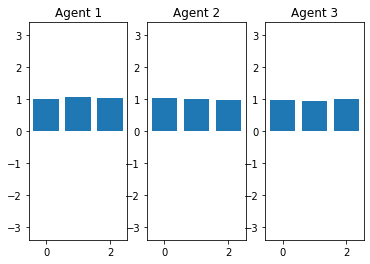

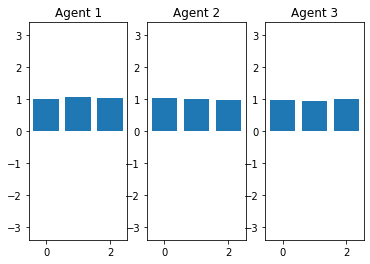

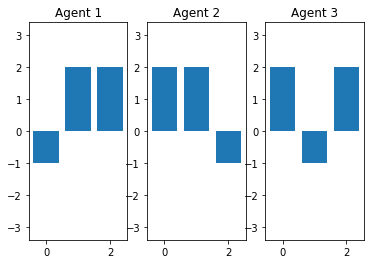

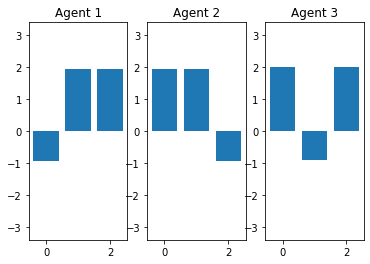

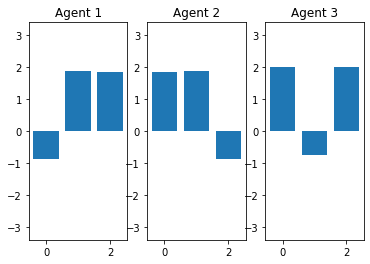

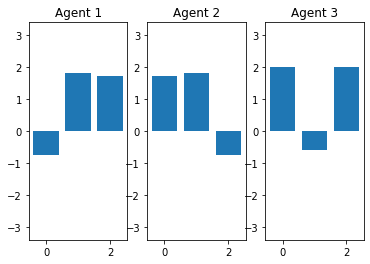

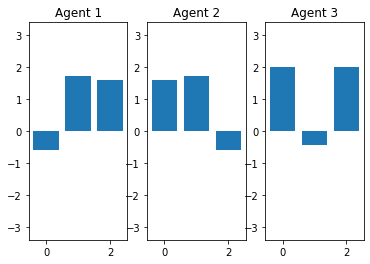

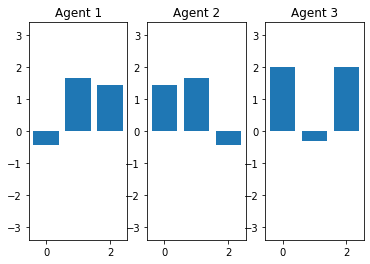

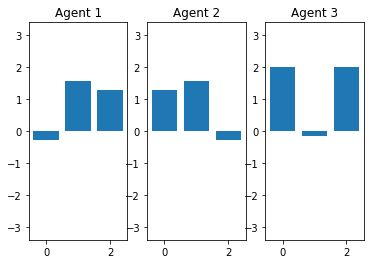

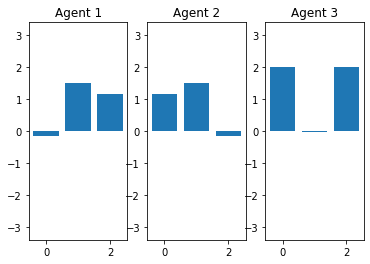

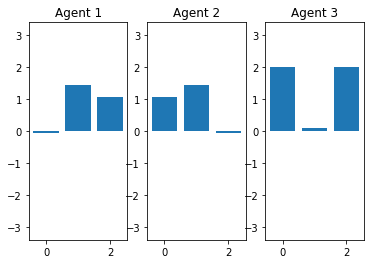

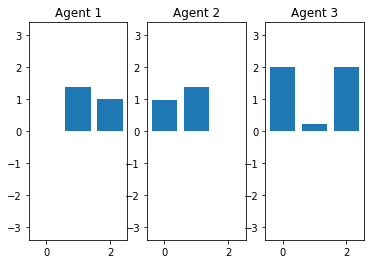

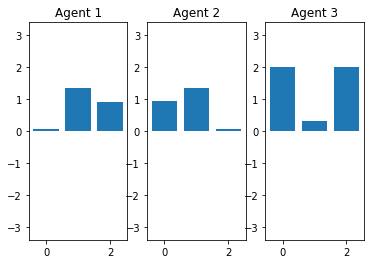

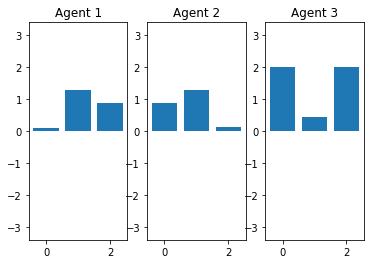

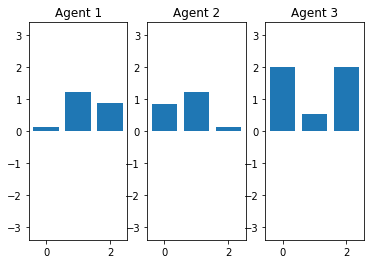

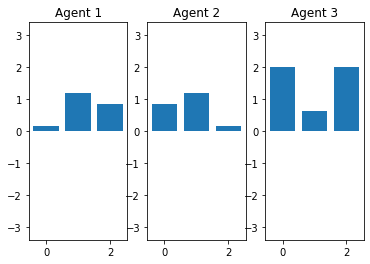

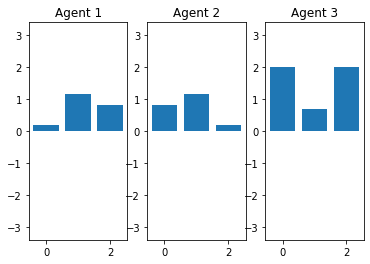

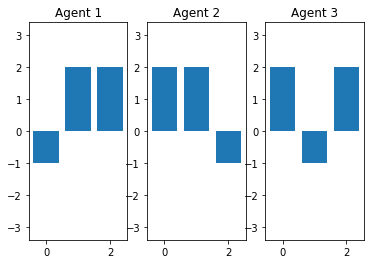

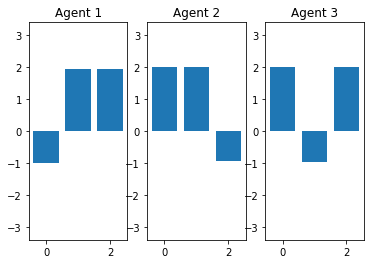

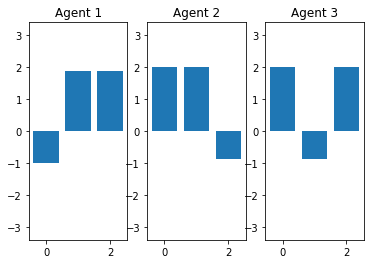

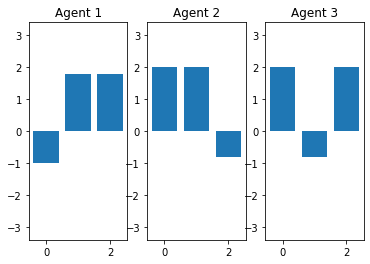

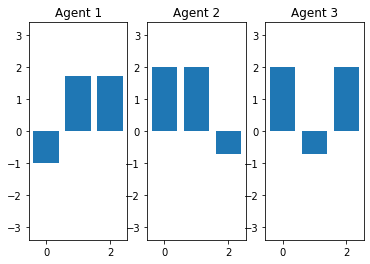

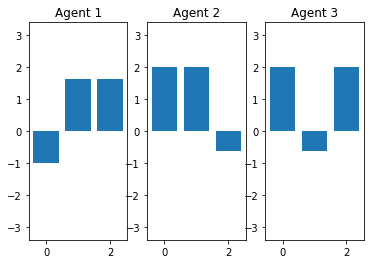

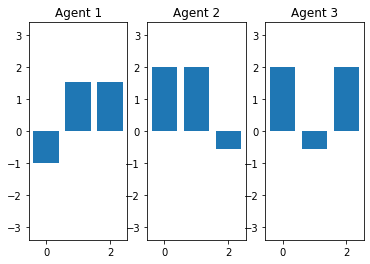

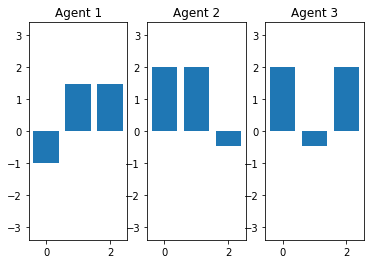

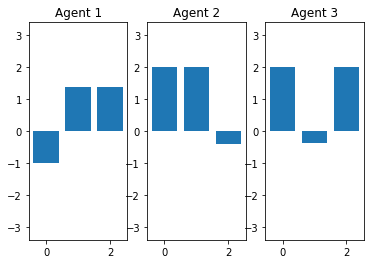

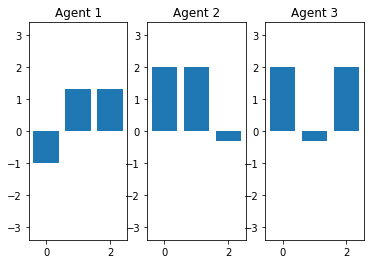

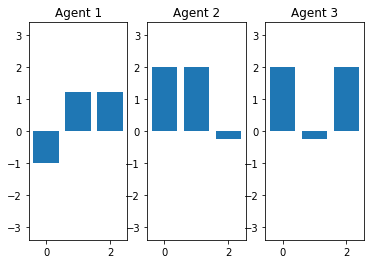

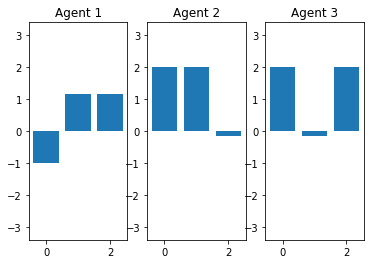

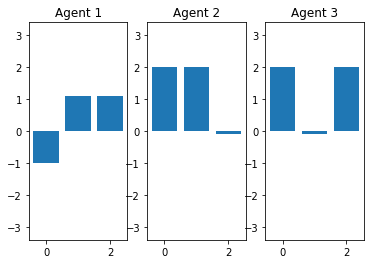

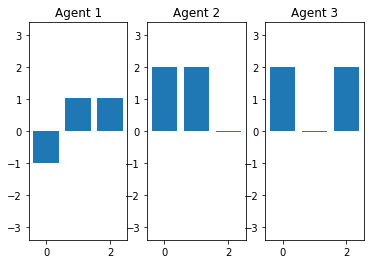

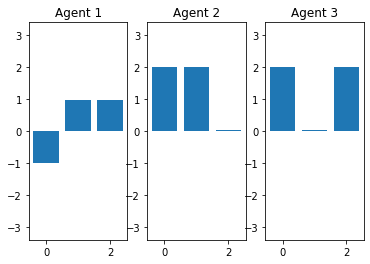

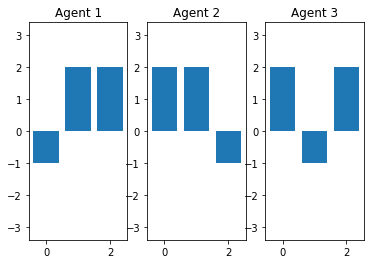

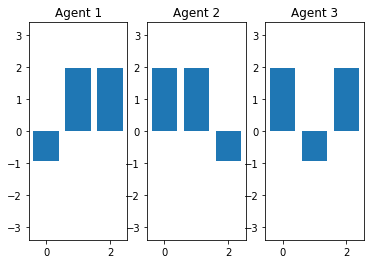

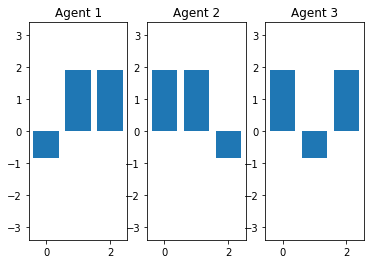

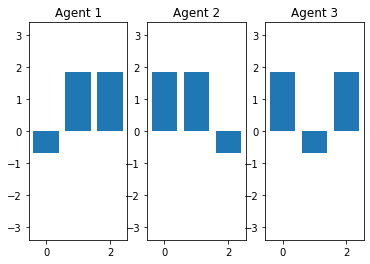

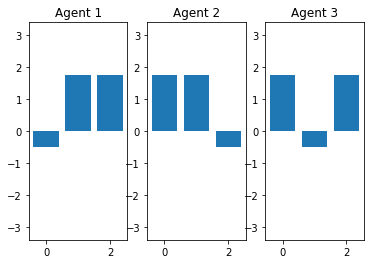

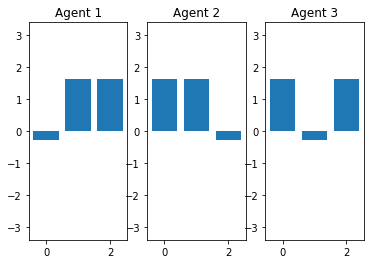

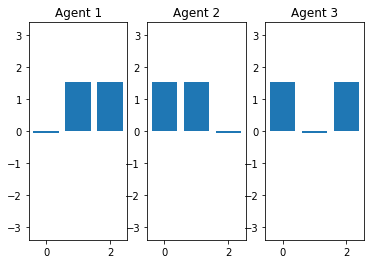

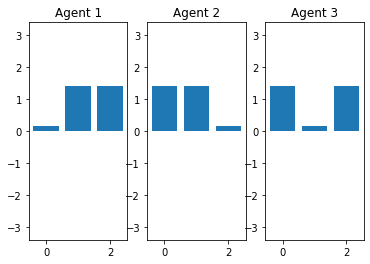

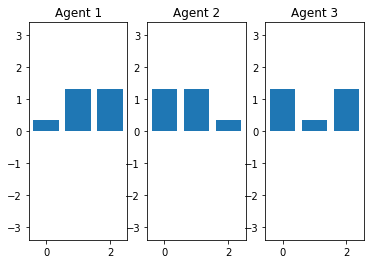

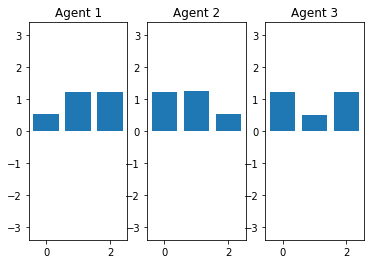

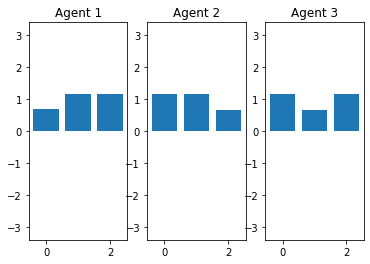

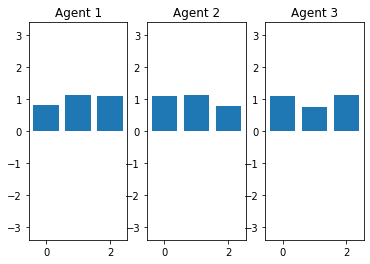

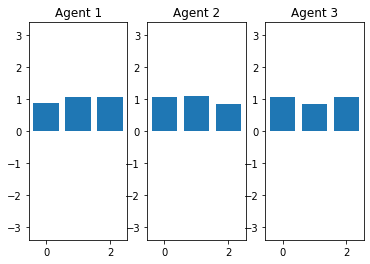

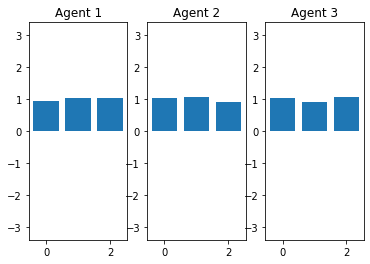

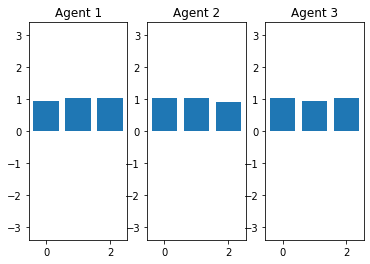

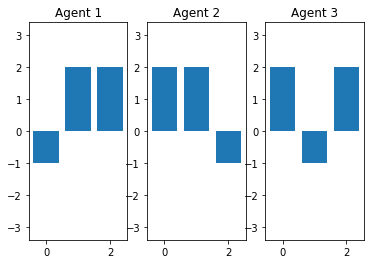

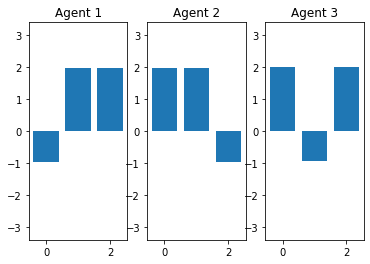

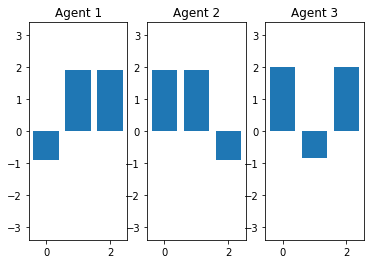

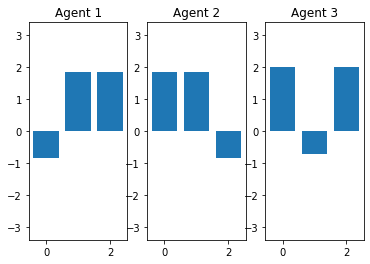

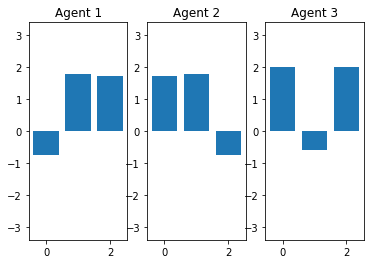

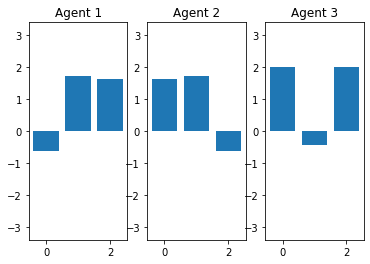

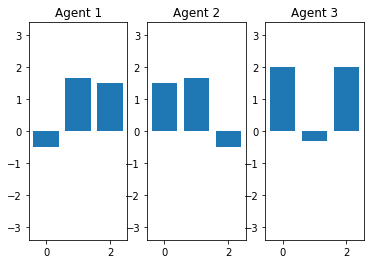

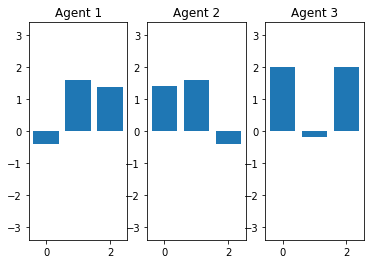

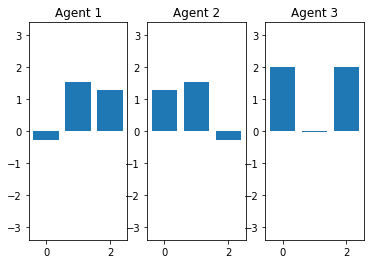

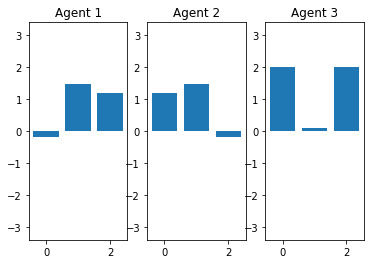

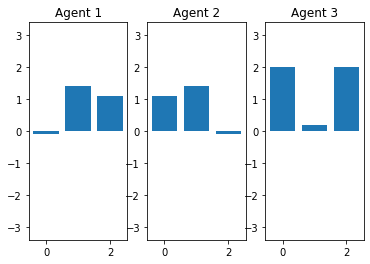

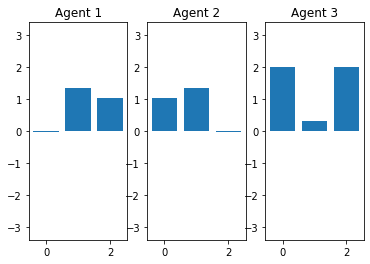

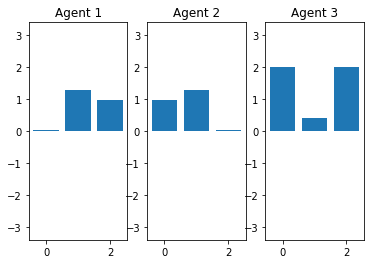

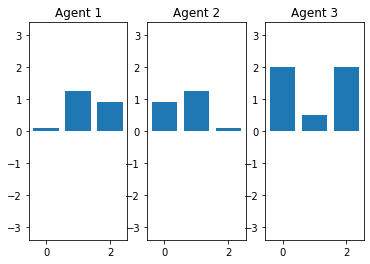

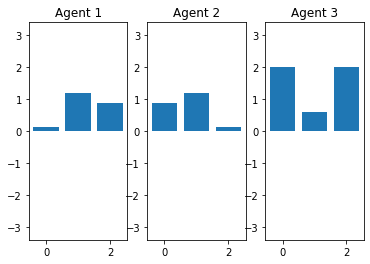

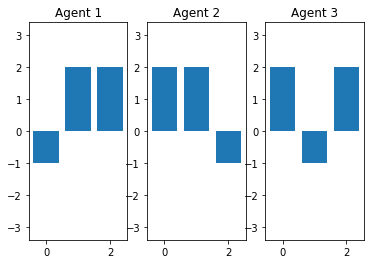

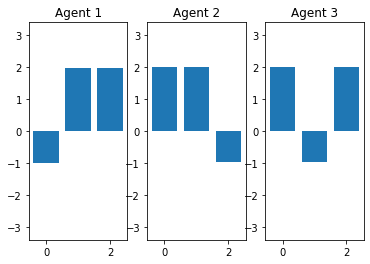

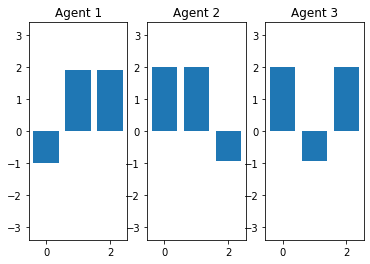

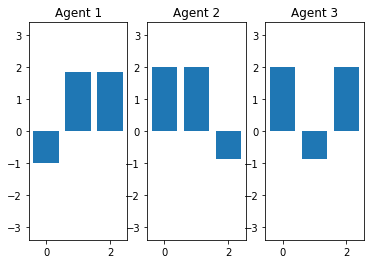

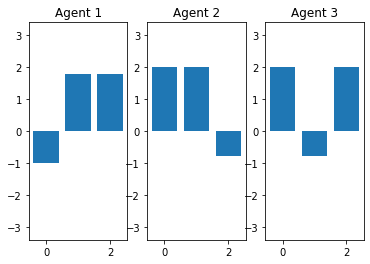

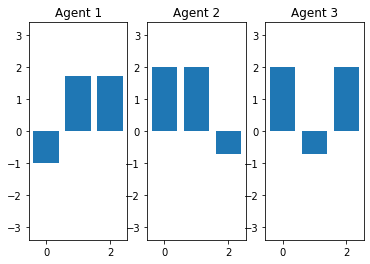

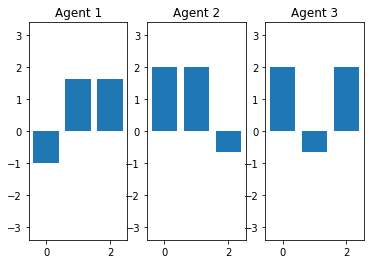

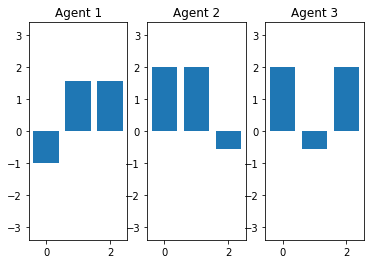

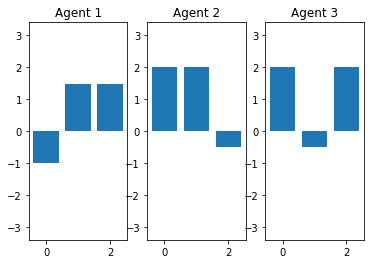

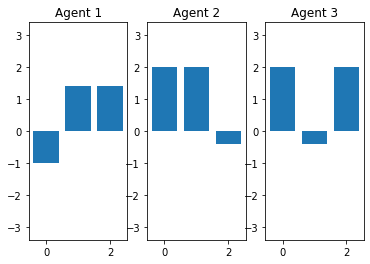

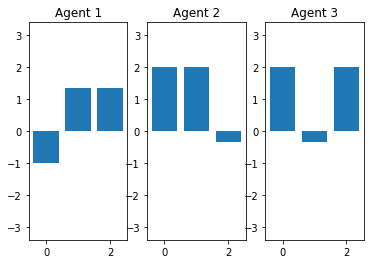

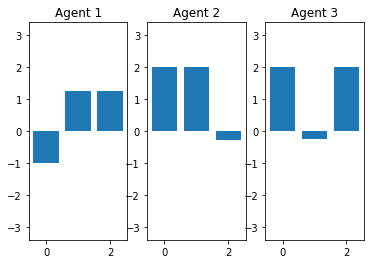

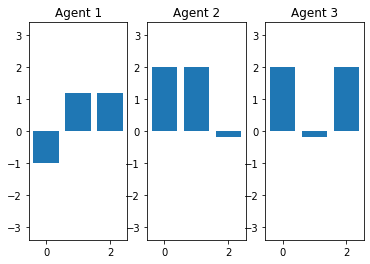

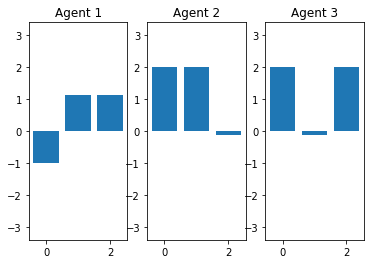

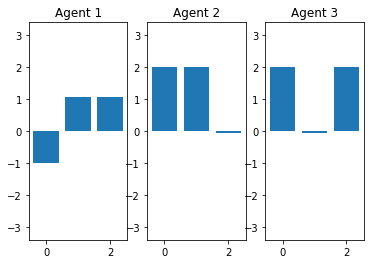

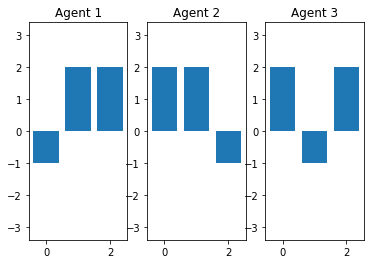

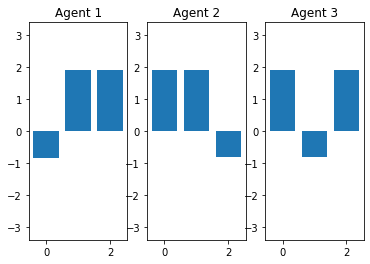

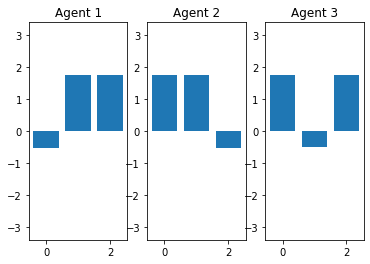

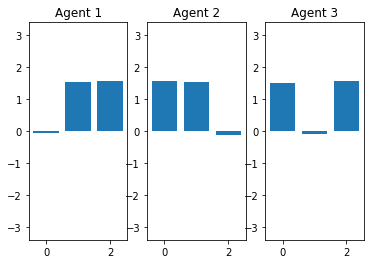

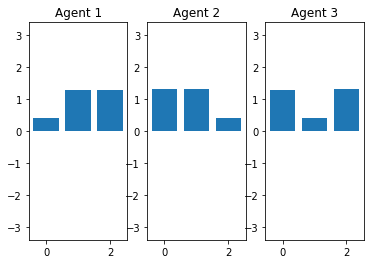

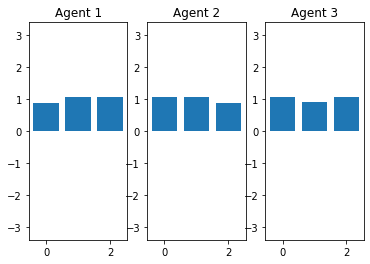

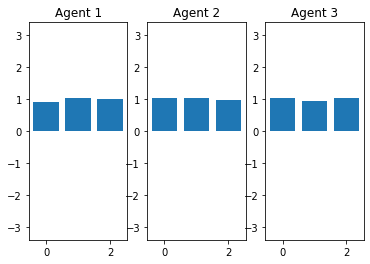

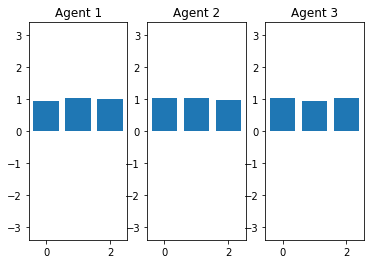

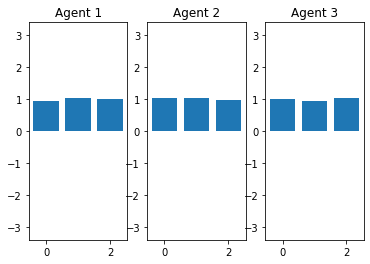

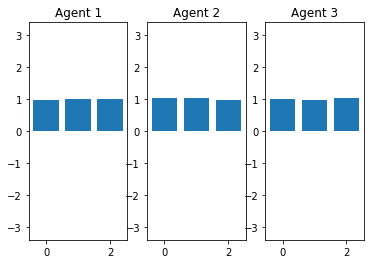

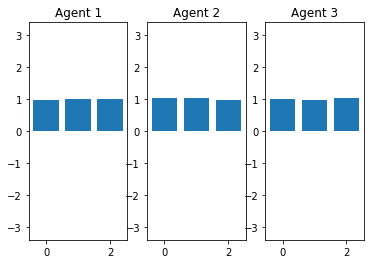

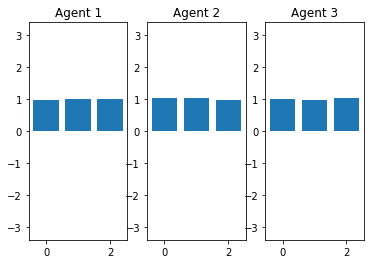

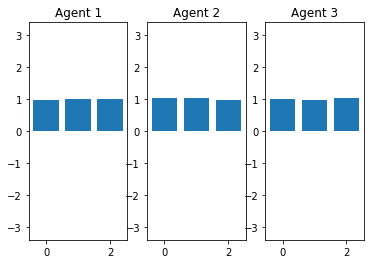

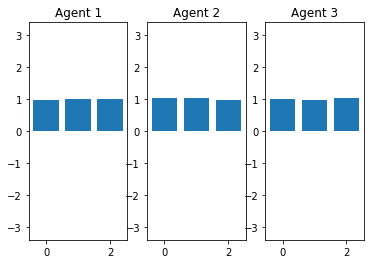

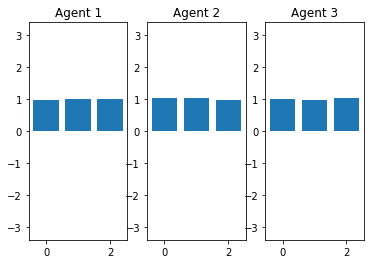

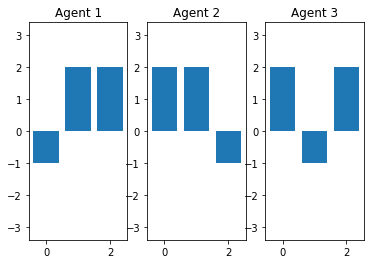

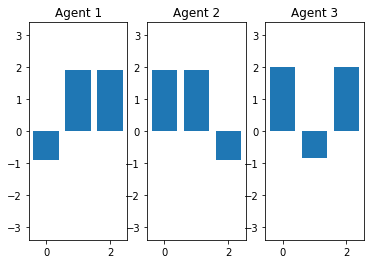

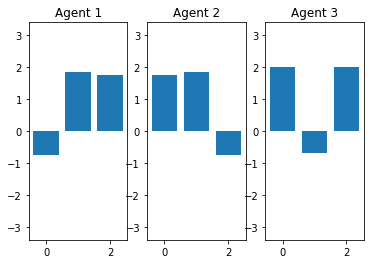

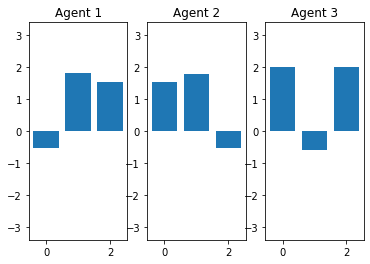

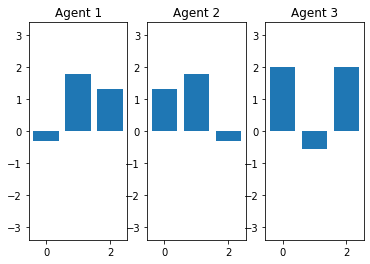

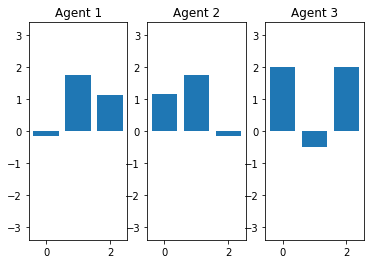

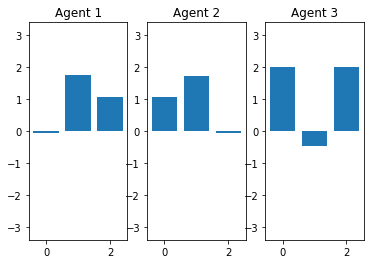

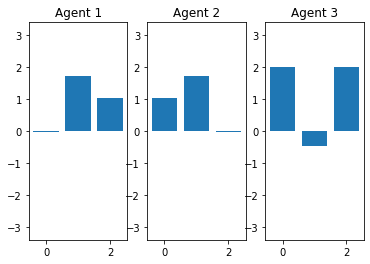

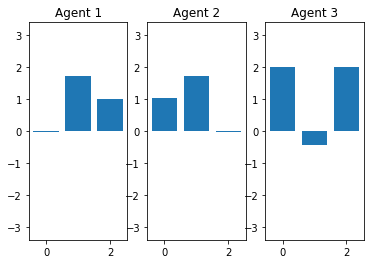

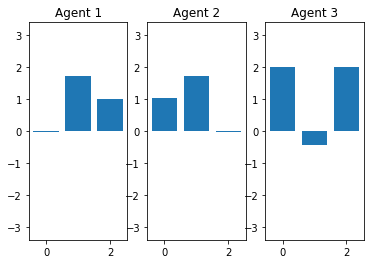

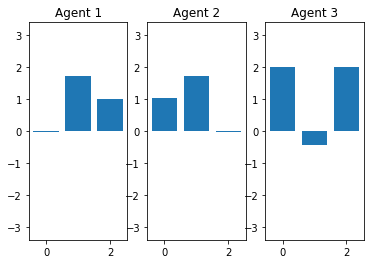

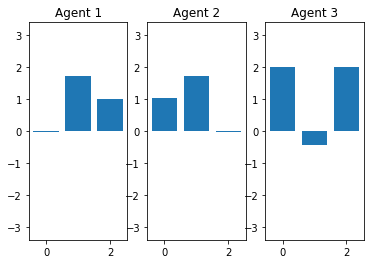

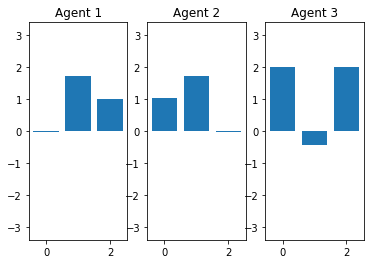

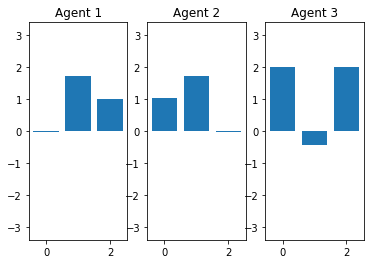

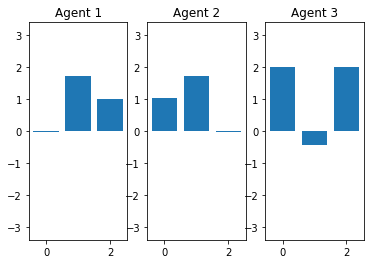

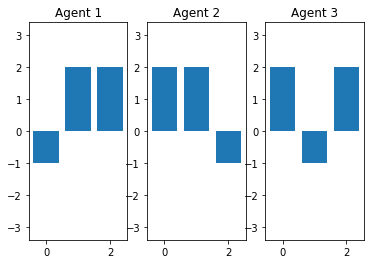

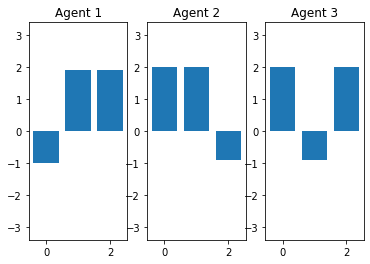

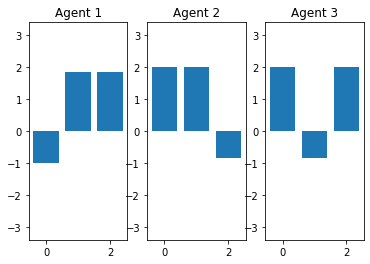

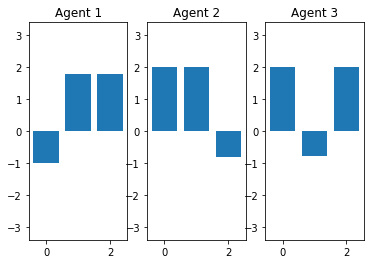

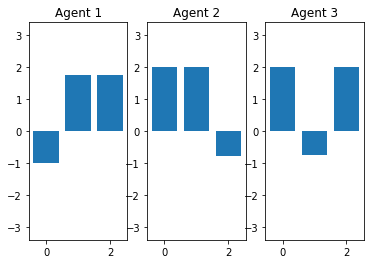

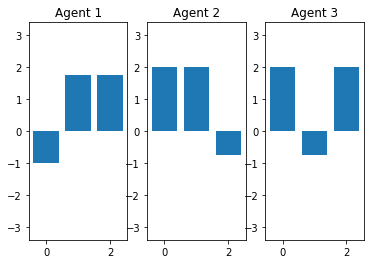

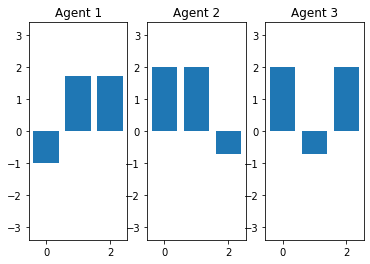

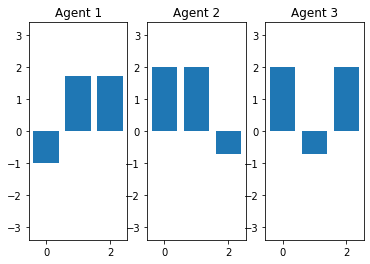

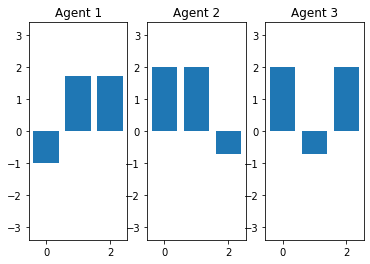

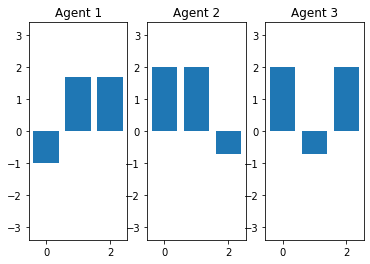

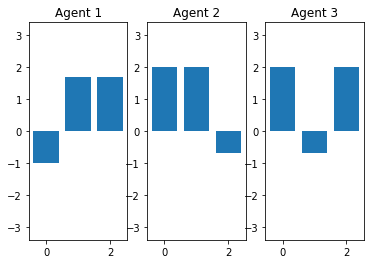

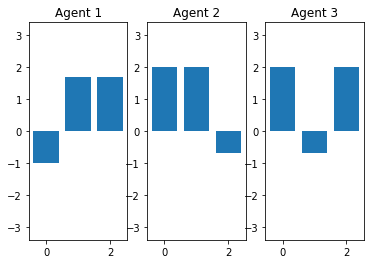

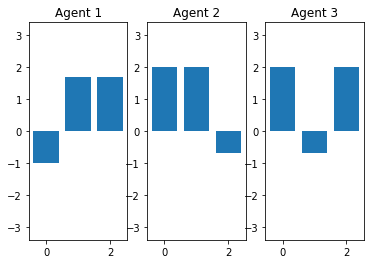

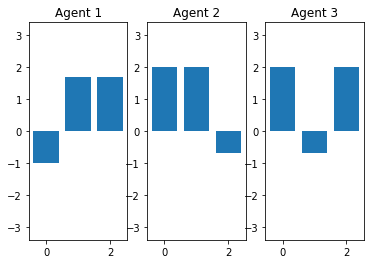

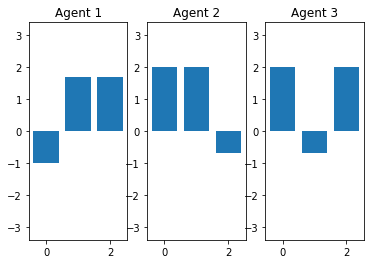

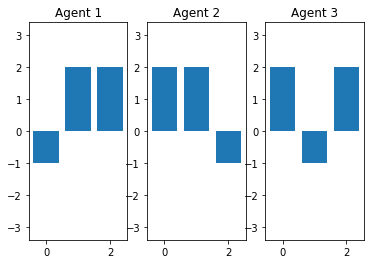

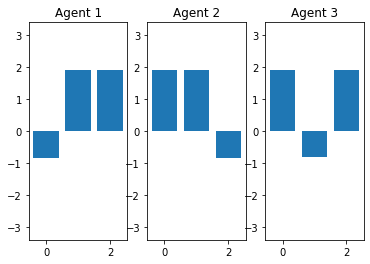

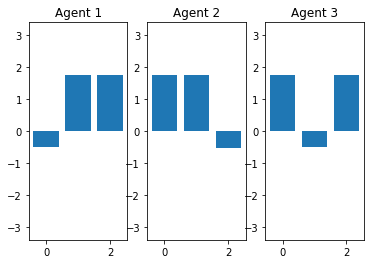

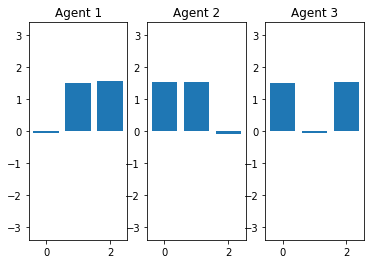

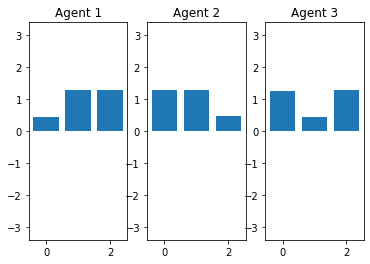

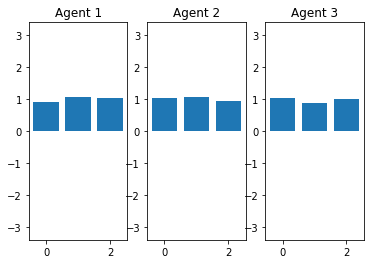

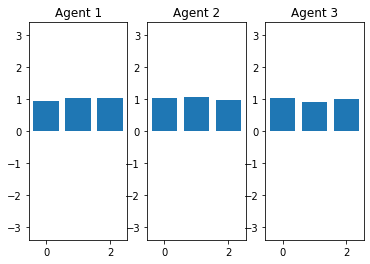

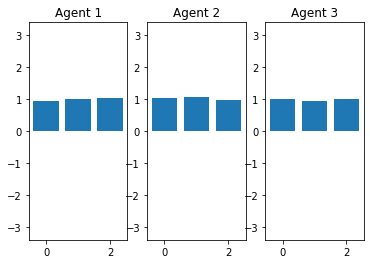

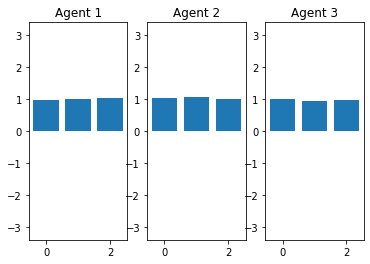

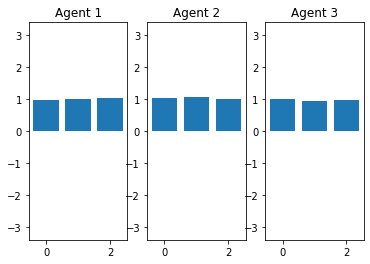

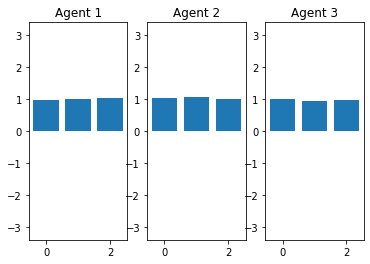

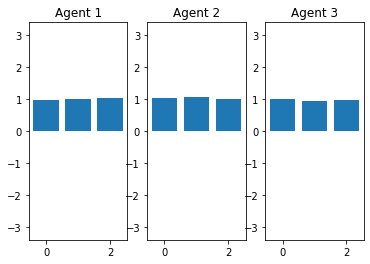

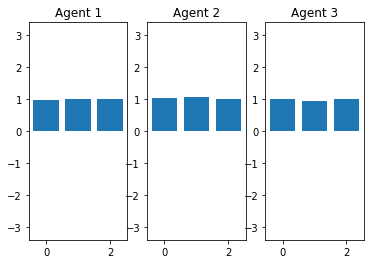

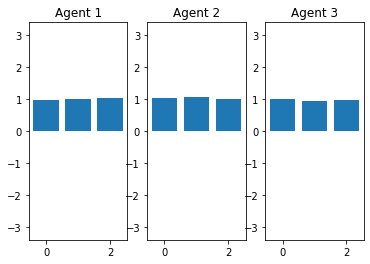

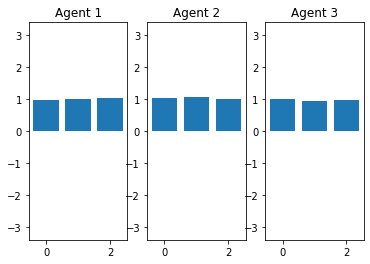

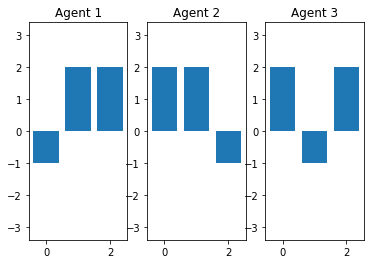

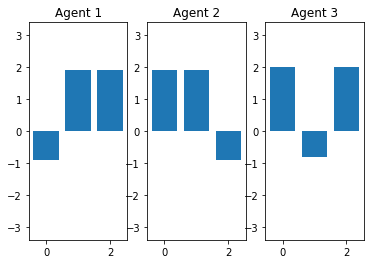

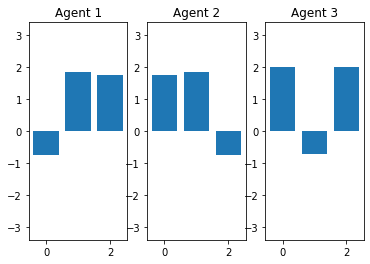

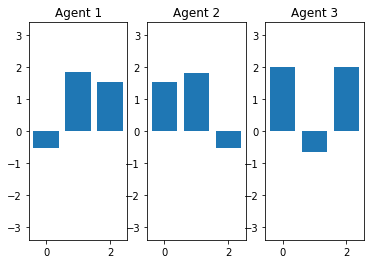

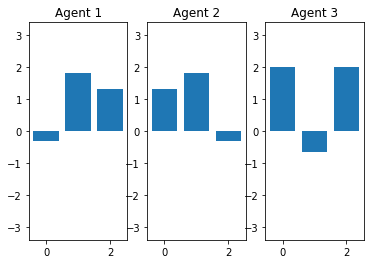

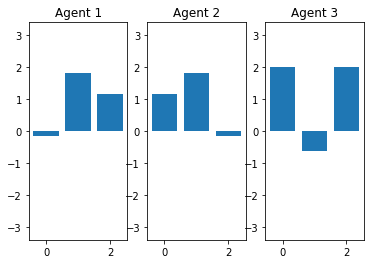

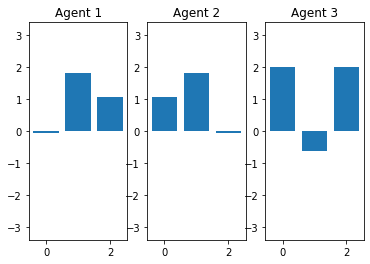

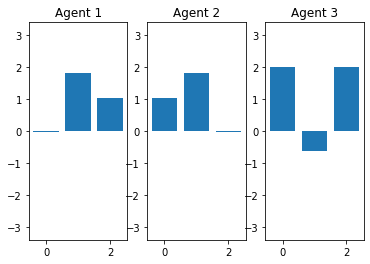

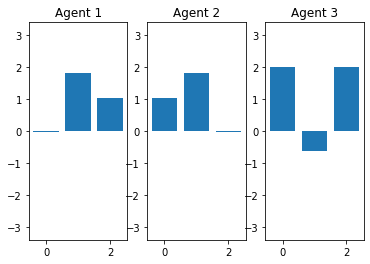

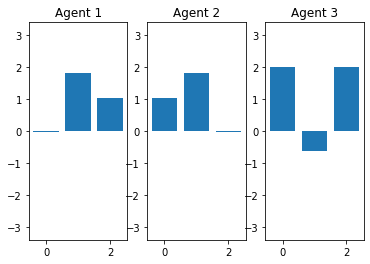

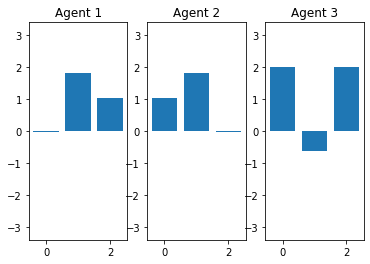

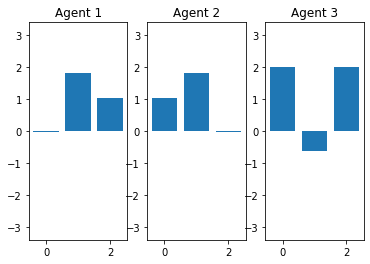

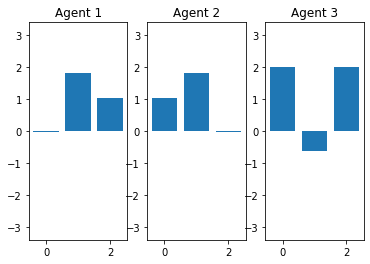

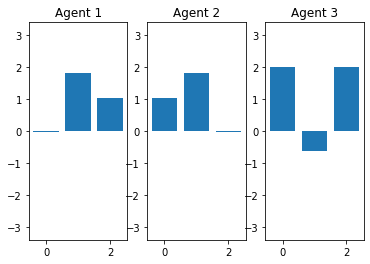

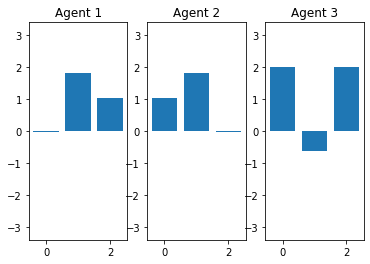

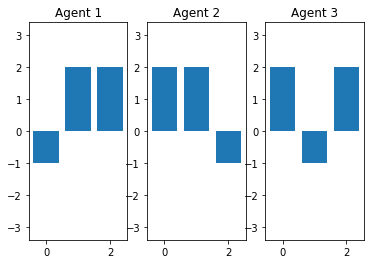

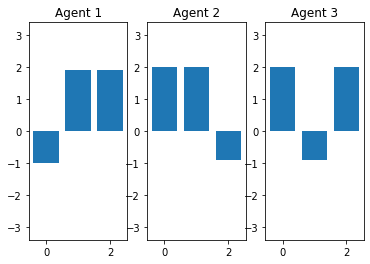

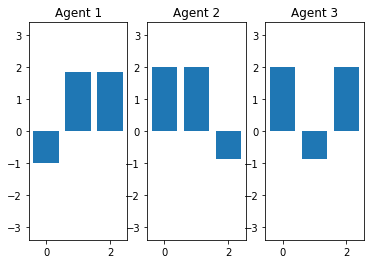

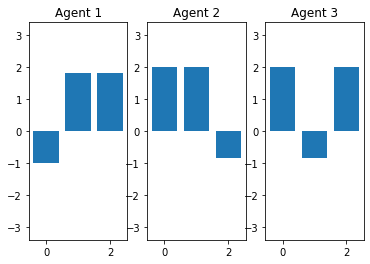

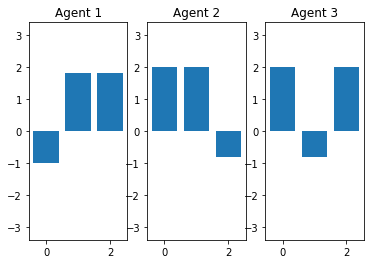

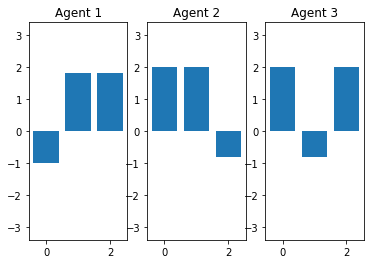

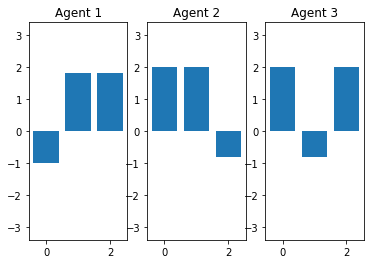

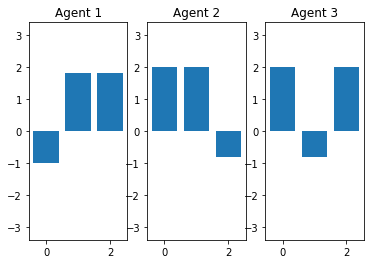

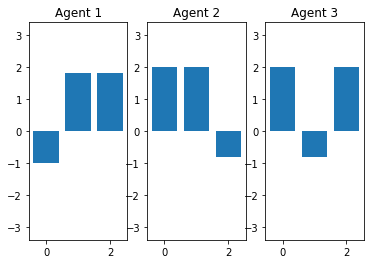

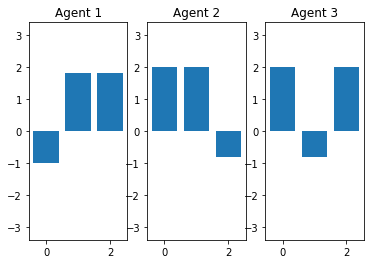

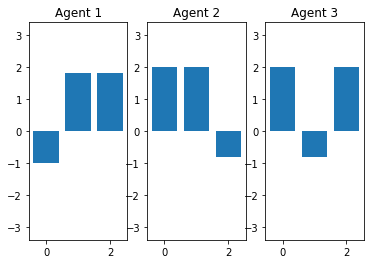

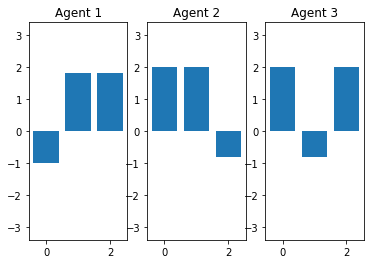

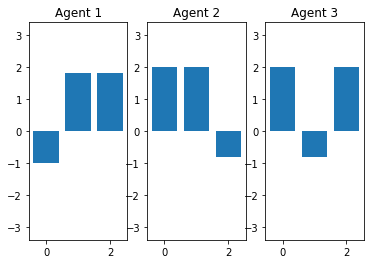

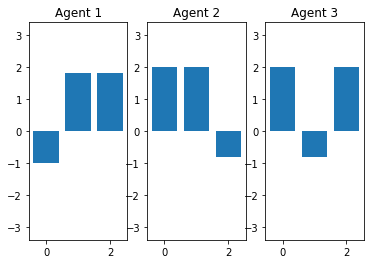

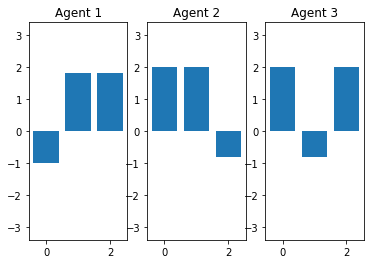

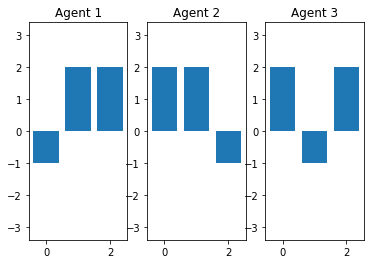

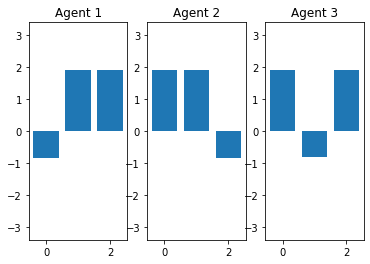

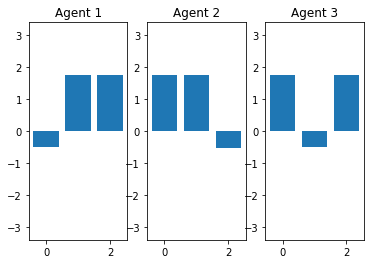

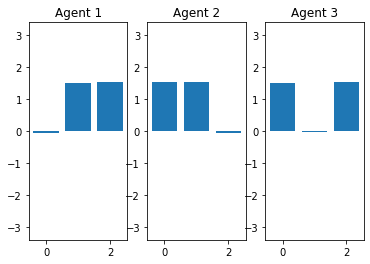

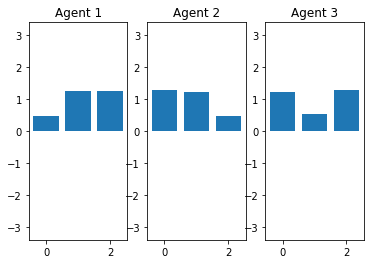

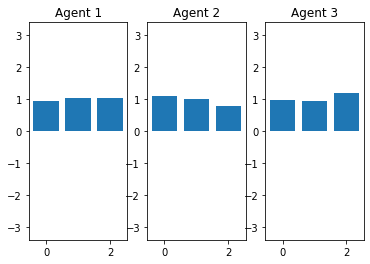

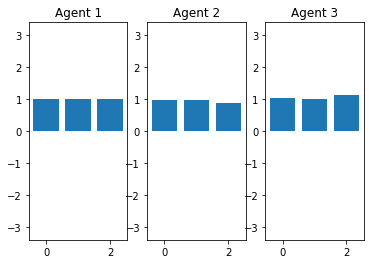

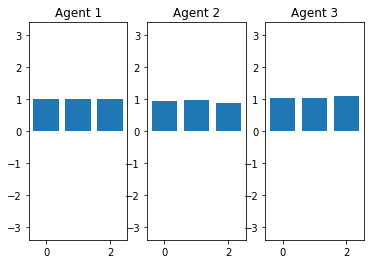

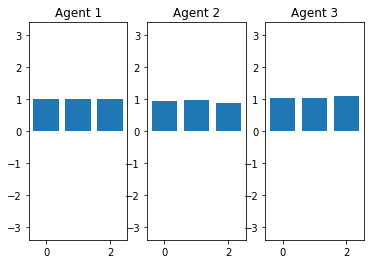

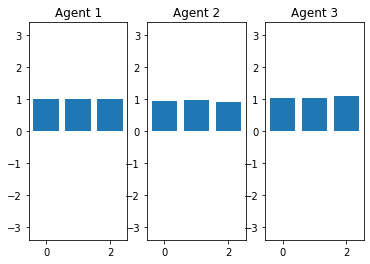

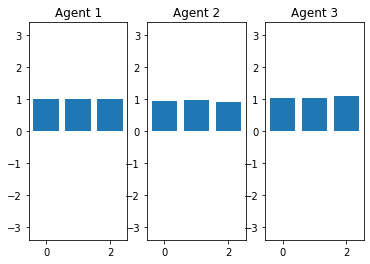

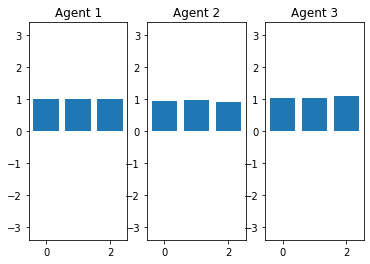

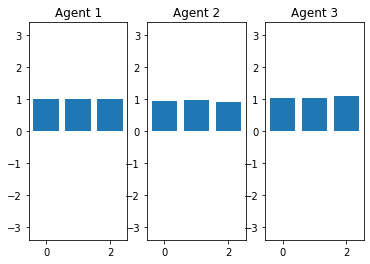

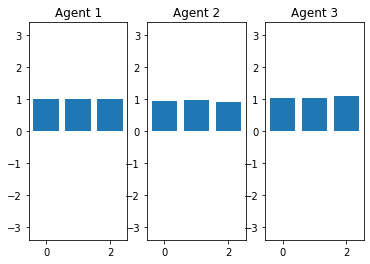

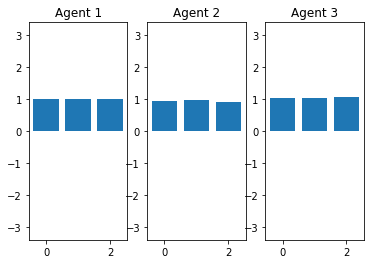

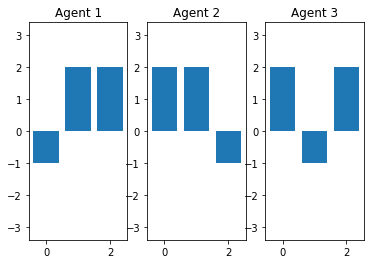

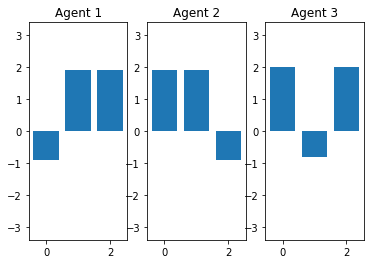

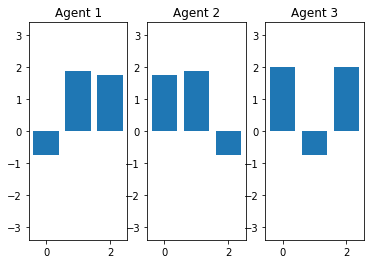

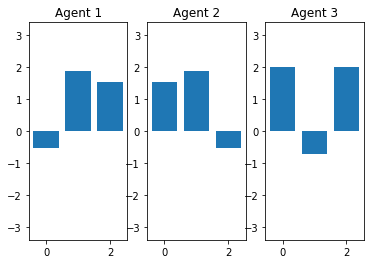

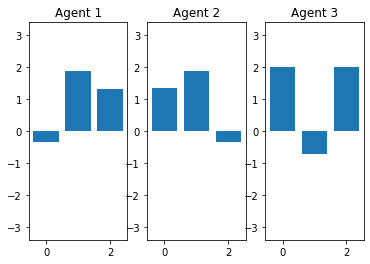

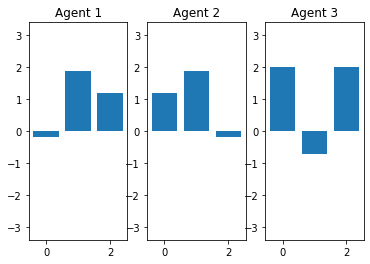

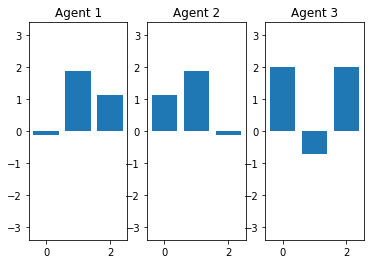

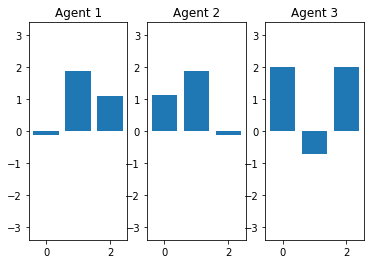

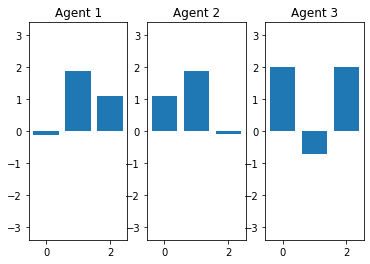

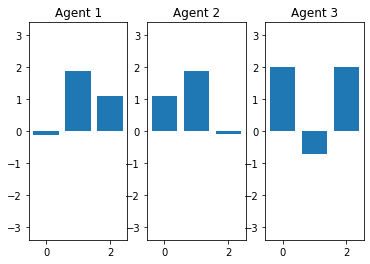

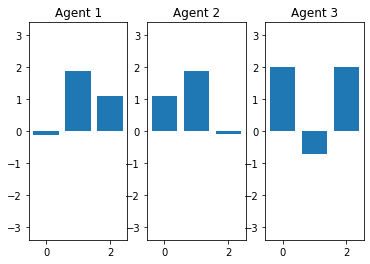

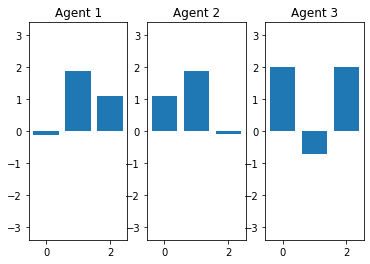

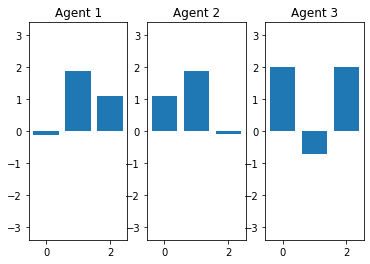

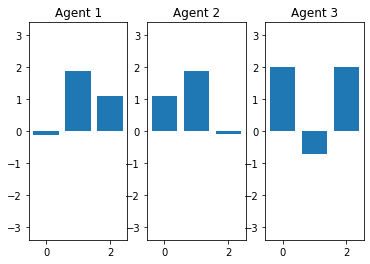

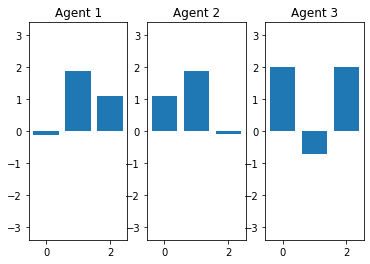

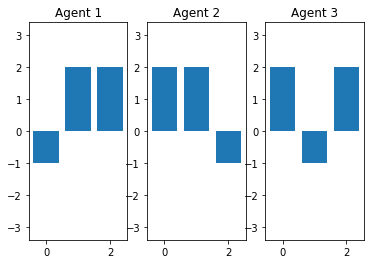

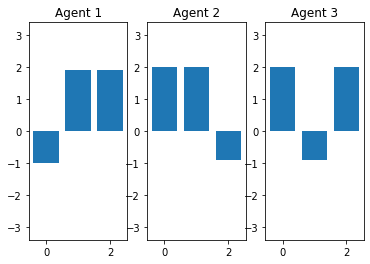

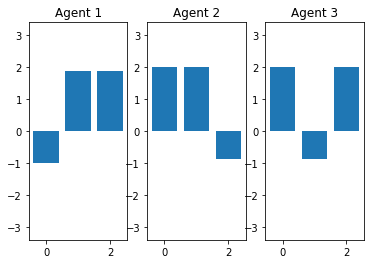

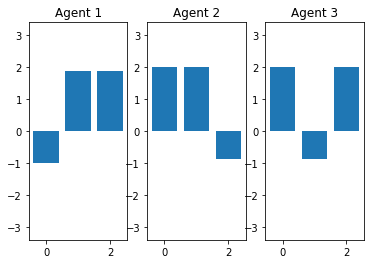

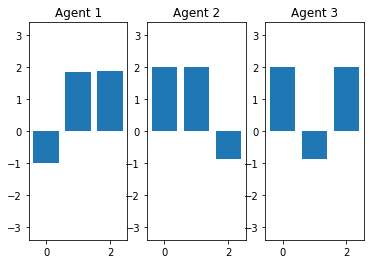

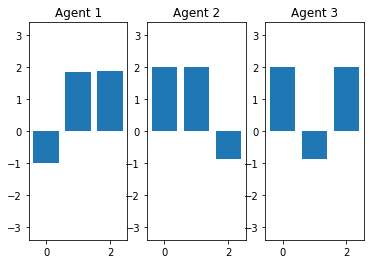

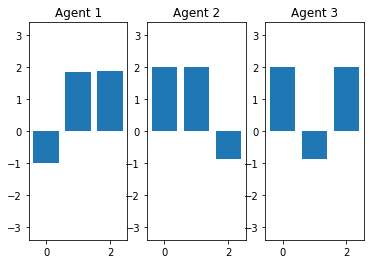

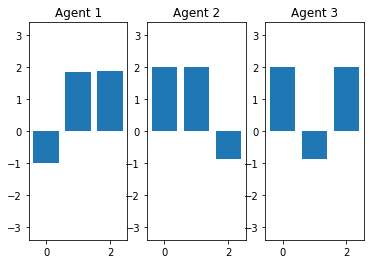

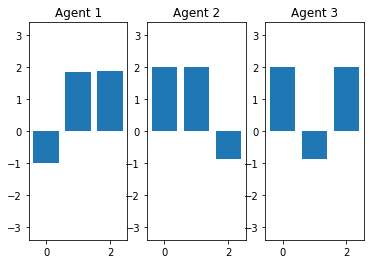

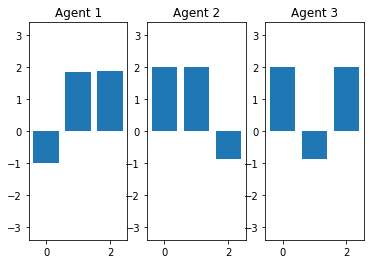

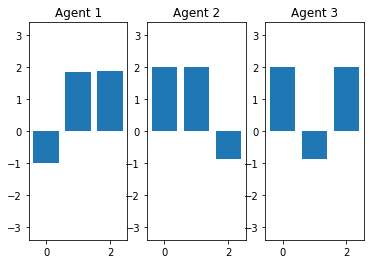

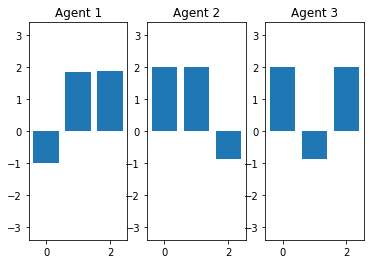

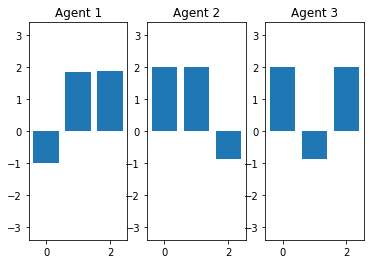

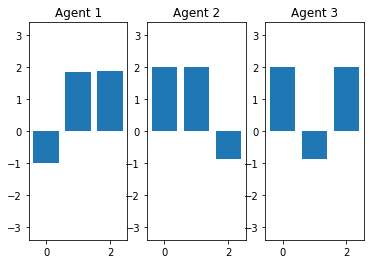

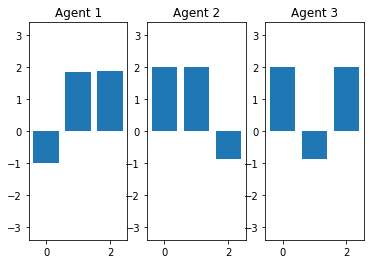

In [2093]:
output = all_expe(liste_exp)

In [2095]:
for x in output:
    param,_,e,sp,utN,ut1E,ut2E,ut3E = x
    print(param, e, sp, ut1E, ut2E)

[0.1, 0.05, 0] 1 0.5966740870003903 3.5018177293379735 2.4438181212763253
[0.1, 0.02, 0] 1 0.40545717692546057 3.170438110259546 2.6405378620391504
[0.3, 0.1, 0] 1 0.6582568454008264 3.779908404653247 2.1481754882125212
[0.5, 0.1, 0] 1 0.6037979007421005 3.764624267284482 2.1725953886902136
[0.7, 0.1, 0] 1 0.501048573315529 3.726796856030935 2.2331945217871745
[0.1, 0.1, 0.3] 1 0.6980522951031165 3.2270651786708093 2.614031249201788
[0.1, 0.1, 0.5] 1 0.6987062313540837 3.086388749266743 2.6758740228681432
[0.1, 0.1, 0.7] 1 0.7014187000117031 3.0115369162938066 2.7037092705812302


In [2096]:
liste_exp2 = [(0.1,0.1,0.05),(0.1,0.1,0.1),(0.1,0.1,0.2)]

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

[[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09977753 0.09874573]
coop deg negociated  [0.09495    0.18021589 0.17933874]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09099737 0.         0.09902713]
coop

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 1. 1.]
coop deg negociated  [0.05449264 0.91958741 0.91451279]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.34977094 0.         0.        ]
coop deg negociated  [0.38349385 0.05449264 0.0704132 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [1.         0.39054194 0.        ]
coop deg negociated  [0.91112955 0.40952657 0.05449264]

[[0.05449264 0.91958741 0.91451279]
 [0.38349385 0.05449264 0.0704132 ]
 [0.91112955 0.40952657 0.05449264]]
Env A, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09894021 0.01803042]
coop deg negociated  [0.05175188 0.24904612 0.17557263]

Stopping search: Swarm best objective change less 

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:206: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.37856508 0.        ]
coop deg negociated  [0.07820221 0.43978258 0.07820221]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.37924882 0.         0.        ]
coop deg negociated  [0.44124706 0.07820221 0.07820221]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.08502353 0.08603577 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.07820221 0.43978258 0.07820221]
 [0.44124706 0.07820221 0.07820221]
 [0.         0.         0.        ]]
Env B, episode  6
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.2802369 0.       ]
coop deg negociated  [0.07426908 0.35633542 0.07426908]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.29322564 0.         0. 

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09117225 0.09117225 0.09117225]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.0998258 0.        0.       ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.09933892 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.09117225 0.09117225 0.09117225]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Env C, episode  3
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.08669172 0.08669172 0.08669172]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09593752 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best ob

Stopping search: Swarm best objective change less than 1e-08
Env A, episode  0
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

[[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.09 0.09 0.09]]
Env A, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09843541 0.09761456]
coop deg negociated  [0.0909     0.17941714 0.1786862 ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09952134 0.         0.09653189]
coop

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.00094106 0.00411474]
coop deg negociated  [0.02852366 0.06093386 0.04648551]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.         0.         0.02098434]
coop deg negociated  [0.15131885 0.02852366 0.17112329]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.         0.00052994 0.        ]
coop deg negociated  [0.06283092 0.06274953 0.02852366]

[[0.02852366 0.06093386 0.04648551]
 [0.15131885 0.02852366 0.17112329]
 [0.06283092 0.06274953 0.02852366]]
Env A, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.00746614 0.        ]
coop deg negociated  [0.02563513 0.04962067 0.03864812]

Stopping search: Swarm bes

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.04034872 0.        ]
coop deg negociated  [0.03929293 0.08302568 0.03929293]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.03494704 0.         0.        ]
coop deg negociated  [0.07871646 0.03929293 0.03929293]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0439034 0.0431695 0.       ]
coop deg negociated  [0. 0. 0.]

[[0.03929293 0.08302568 0.03929293]
 [0.07871646 0.03929293 0.03929293]
 [0.         0.         0.        ]]
Env B, episode  10
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.0287368 0.       ]
coop deg negociated  [0.03531382 0.06560977 0.03531382]

Stopping search: Swarm best objective change less than 1

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.06434693 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.06257781 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.05412817 0.05412817 0.05412817]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Env C, episode  7
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.04864675 0.04864675 0.04864675]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.05617766 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.05410203 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.04864675 0.04864675 0.0

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.39290256 0.39662635 0.        ]
coop deg negociated  [0.45440123 0.45712615 0.05352192]

[[0.05352192 0.48505517 0.49530394]
 [0.45408645 0.05352192 0.43261481]
 [0.45440123 0.45712615 0.05352192]]
Env A, episode  4
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.88612891 0.89843487]
coop deg negociated  [0.04252257 0.86825418 0.87820706]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.91513336 0.         0.88002866]
coop deg negociated  [0.8859779  0.04252257 0.85843659]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.85327773 0.78022878 0.        ]
coop deg negociated  [0.84105703 0.78649365 0.04252257]

[[0.04252257 0.86825418 0.87820706]
 [0.8859779  0.04252257 0.85843659]
 [0.84105703 0.7

Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.09 0.09 0.09]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0. 0. 0.]
coop deg negociated  [0. 0. 0.]

[[0.09 0.09 0.09]
 [0.09 0.09 0.09]
 [0.   0.   0.  ]]
Env B, episode  1
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.09762833 0.        ]
coop deg negociated  [0.0828     0.17931799 0.0828    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.09723036 0.         0.        ]
coop deg negociated  [0.17893151 0.0828     0.0828    ]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.         0.00080038 0.        ]
coop deg negociated  [0.00672226 0.00096426 0.00672226]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.00070432 0.         0.        ]
coop deg negociated  [0.00088377 0.00672226 0.00672226]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.00837073 0.00879907 0.        ]
coop deg negociated  [0. 0. 0.]

[[0.00672226 0.00096426 0.00672226]
 [0.00088377 0.00672226 0.00672226]
 [0.         0.         0.        ]]
Env B, episode  13
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0.        0.0002112 0.       ]
coop deg negociated  [0.00533792 0.0002865  0.00533792]

Stopping search: Swarm best objective change less tha

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.0171675 0.        0.       ]
coop deg negociated  [0. 0. 0.]

[[0.01342597 0.01342597 0.01342597]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Env C, episode  10
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Agent  0
coop deg detected  [0. 0. 0.]
coop deg negociated  [0.0106611 0.0106611 0.0106611]

Stopping search: Swarm best objective change less than 1e-08
Agent  1
coop deg detected  [0.01369763 0.         0.        ]
coop deg negociated  [0. 0. 0.]

Stopping search: Swarm best objective change less than 1e-08
Agent  2
coop deg detected  [0.01384338 0.         0.        ]
coop deg negociated  [0. 0. 0.]

[[0.0106611 0.0106611 0.0106611]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
Env C, episode  11
Stopping search: Swarm best objective change less than 1e-08
Stopping 

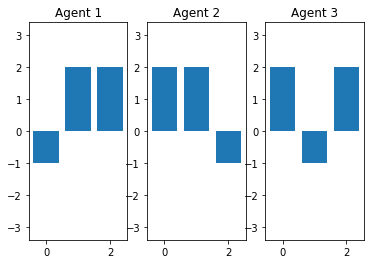

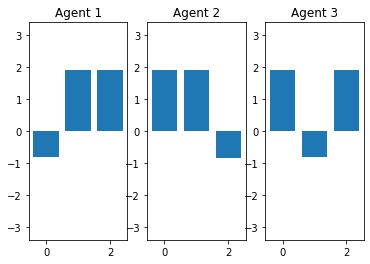

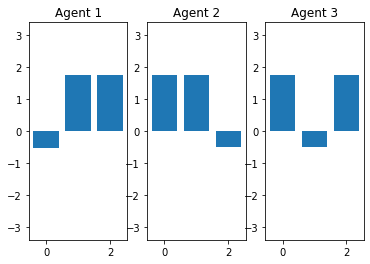

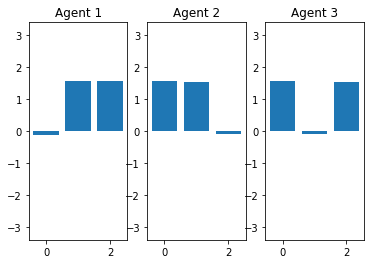

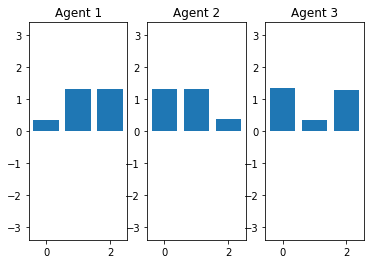

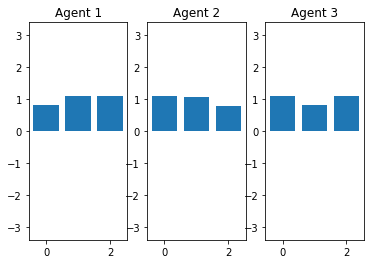

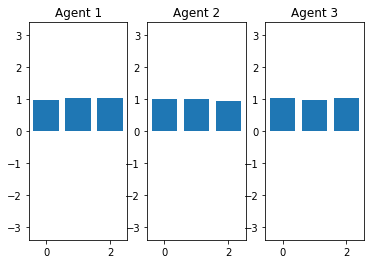

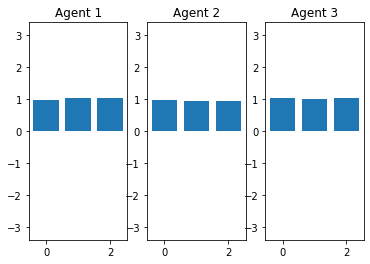

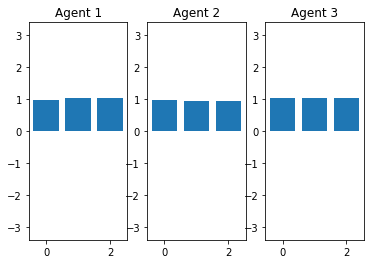

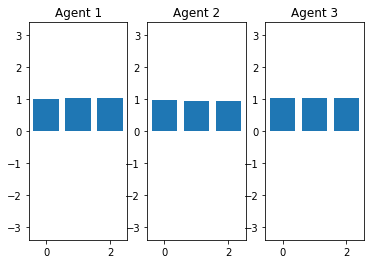

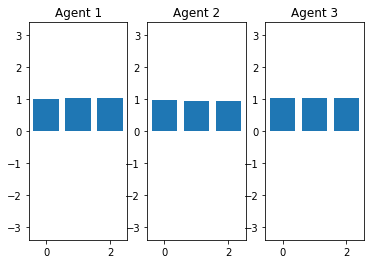

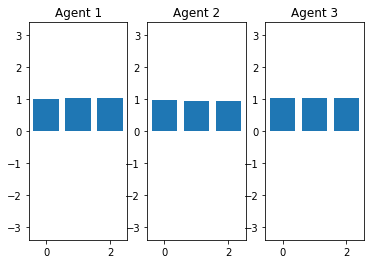

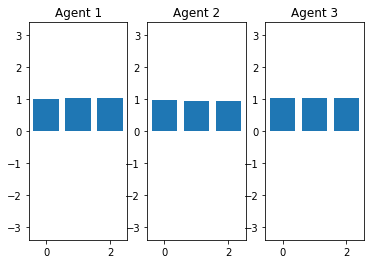

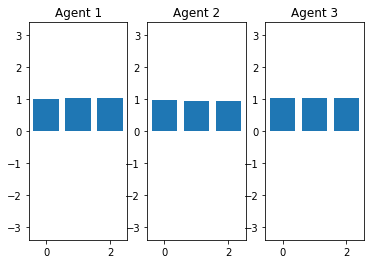

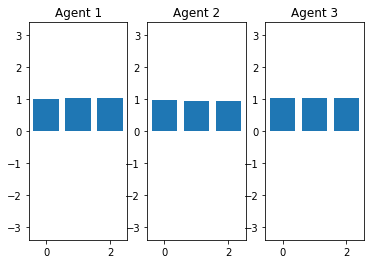

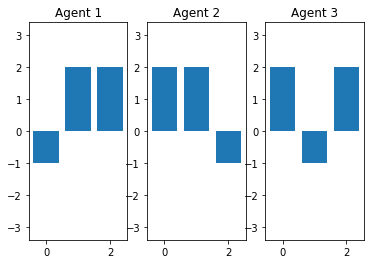

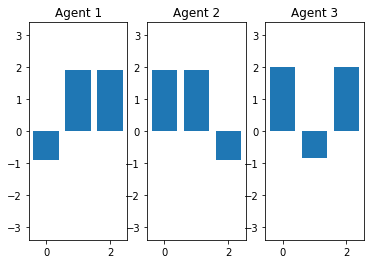

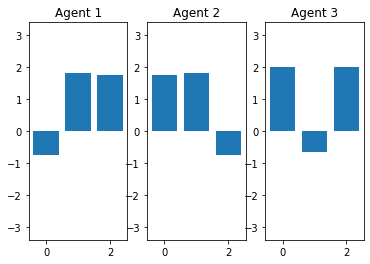

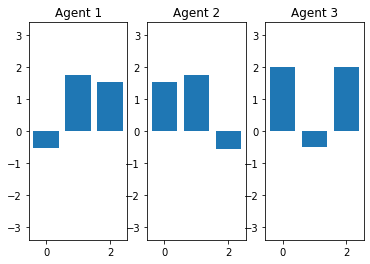

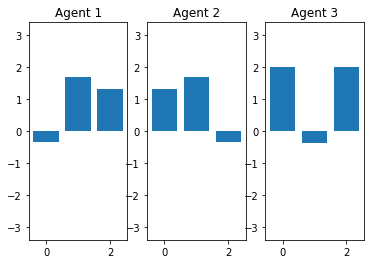

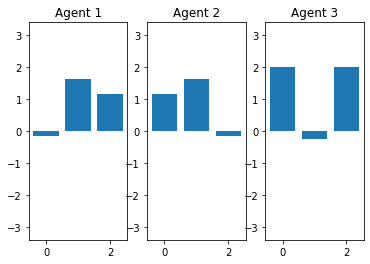

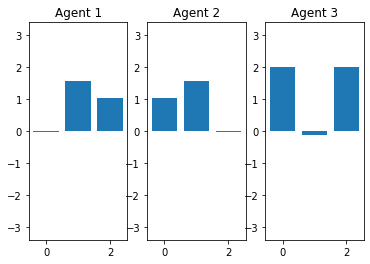

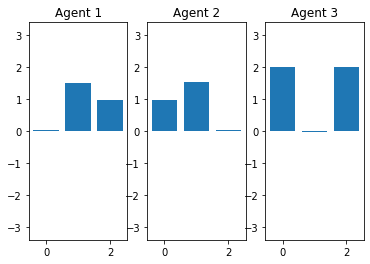

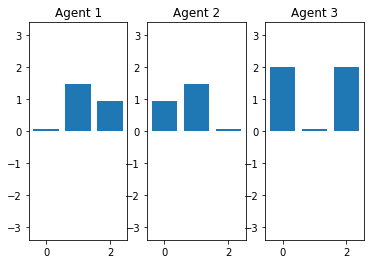

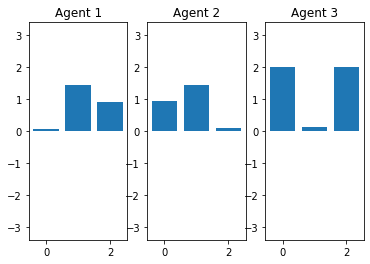

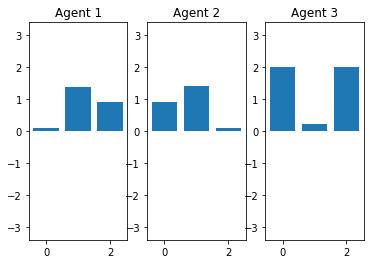

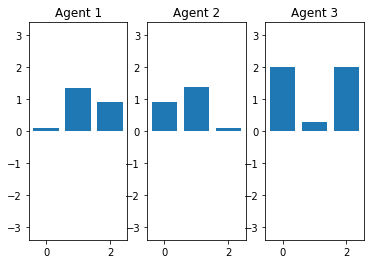

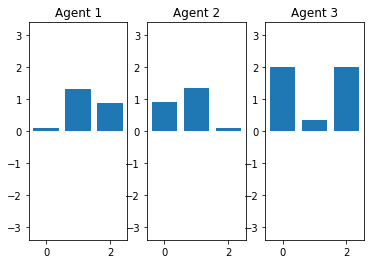

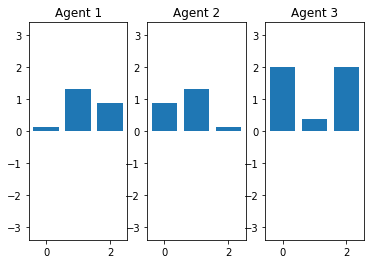

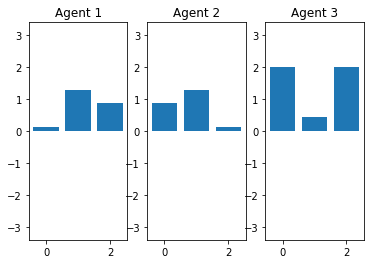

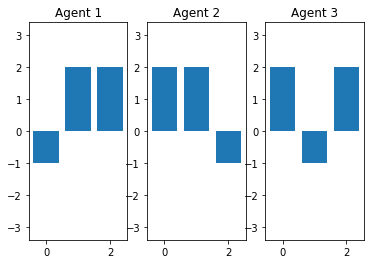

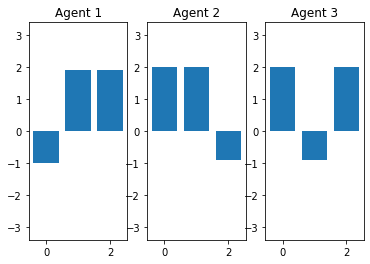

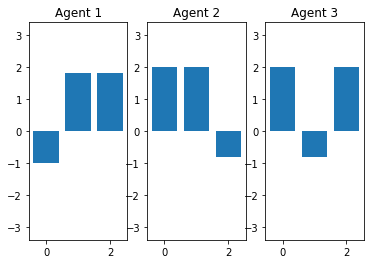

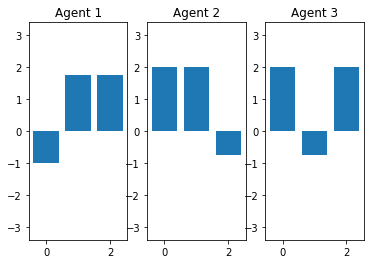

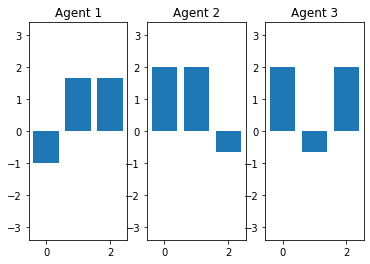

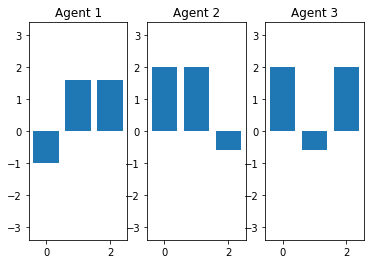

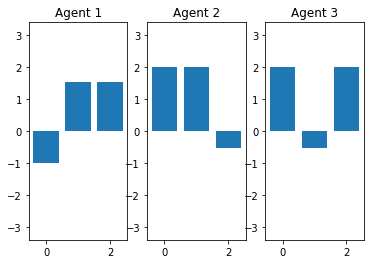

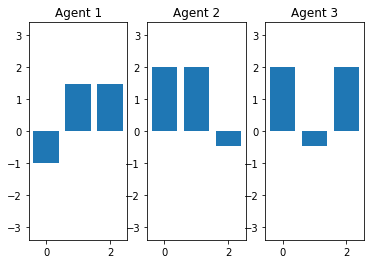

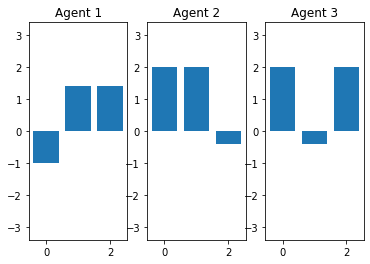

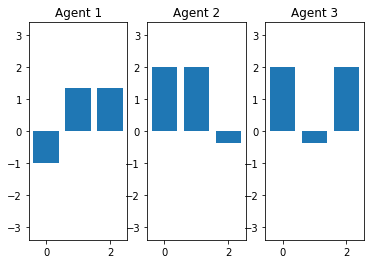

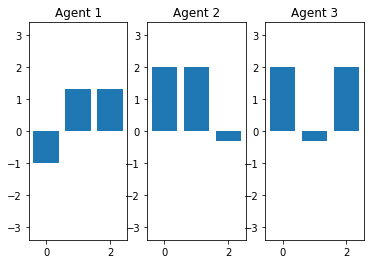

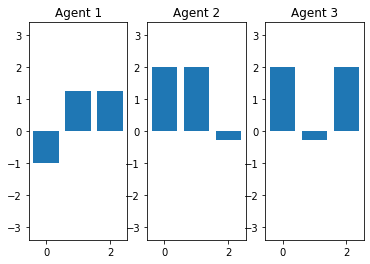

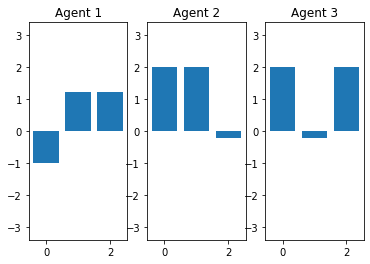

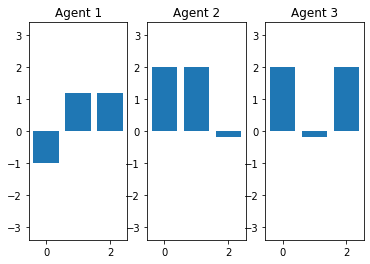

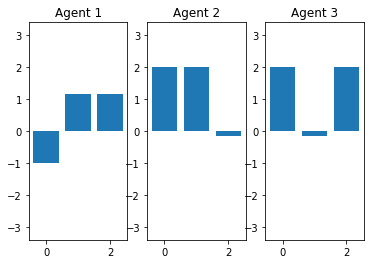

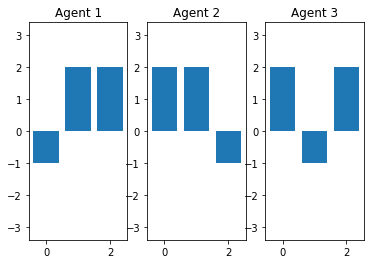

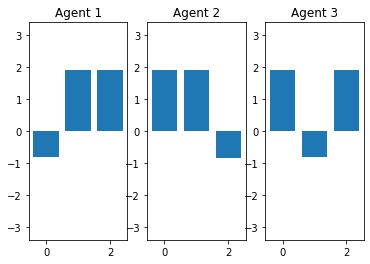

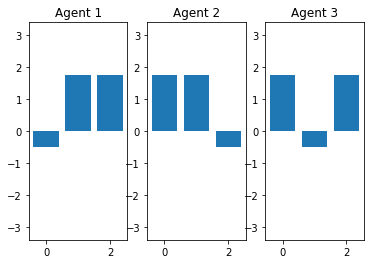

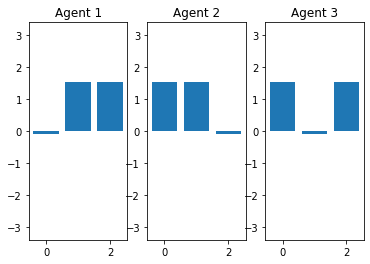

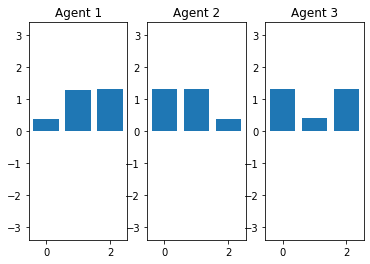

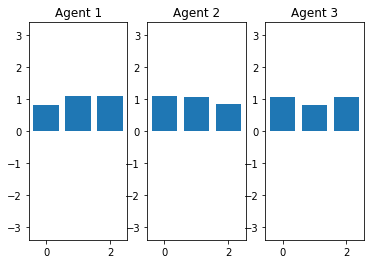

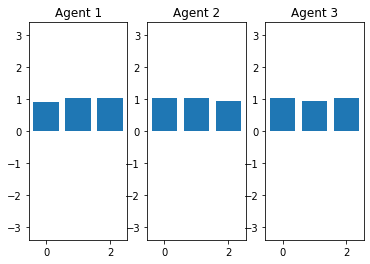

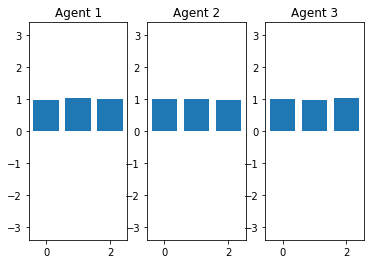

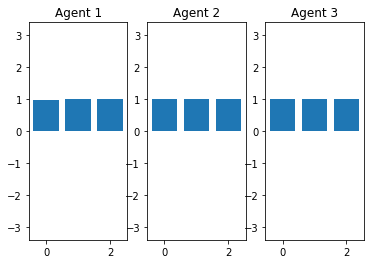

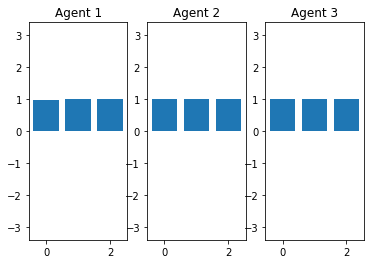

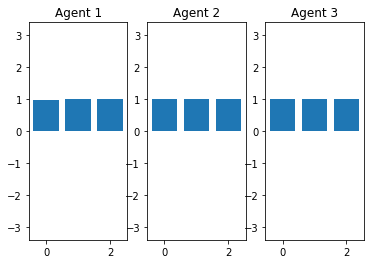

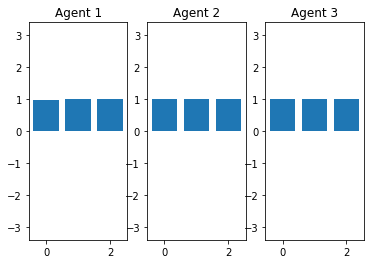

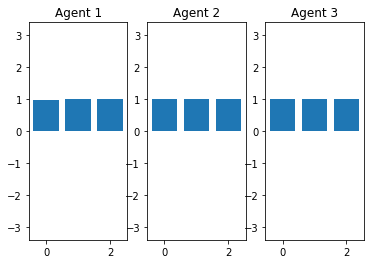

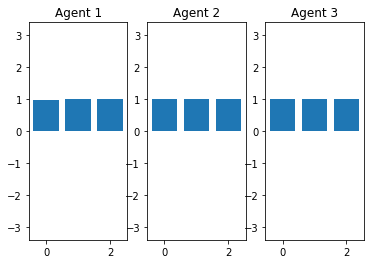

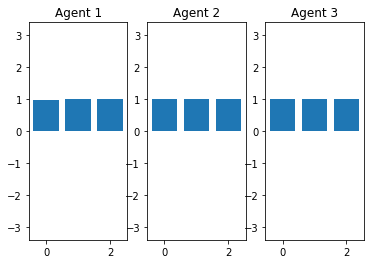

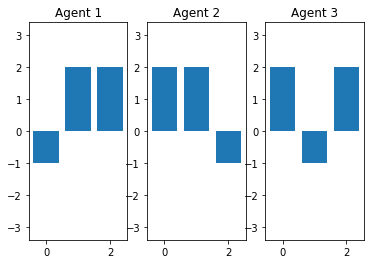

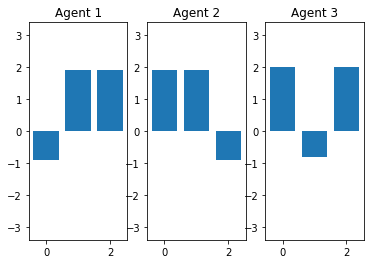

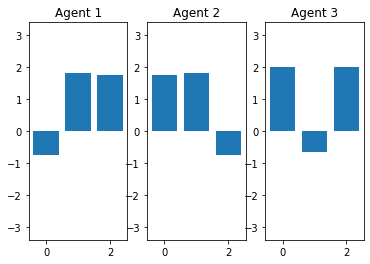

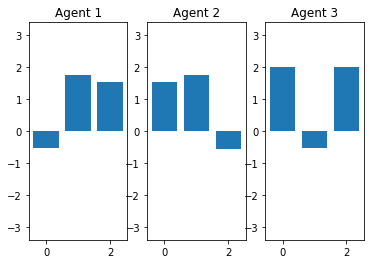

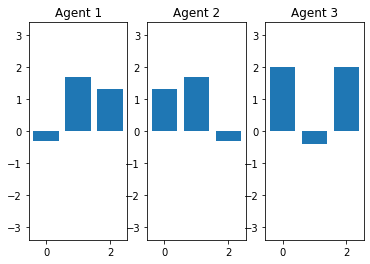

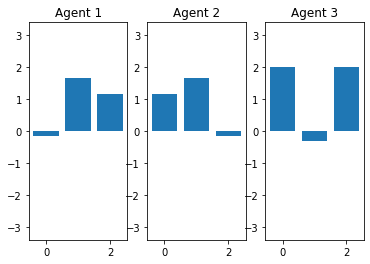

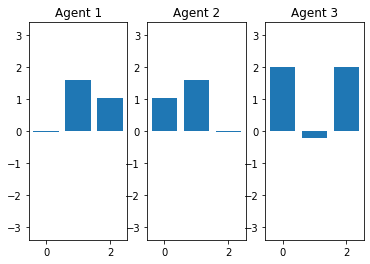

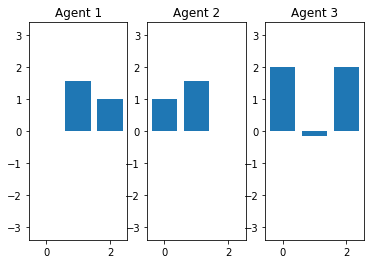

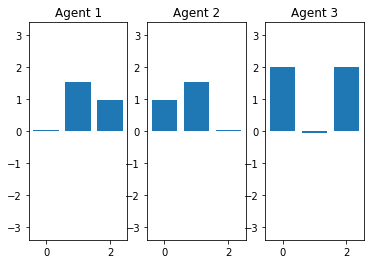

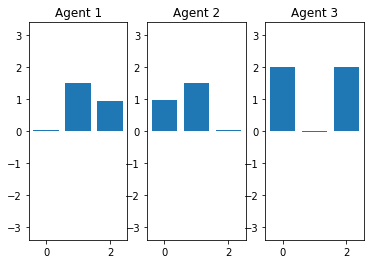

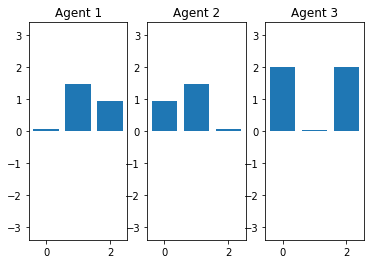

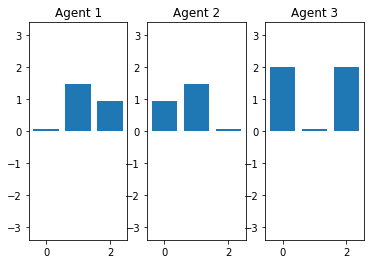

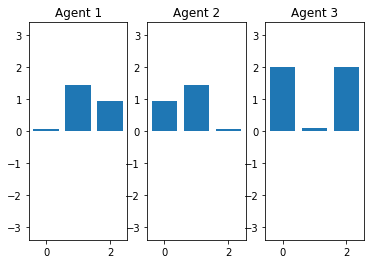

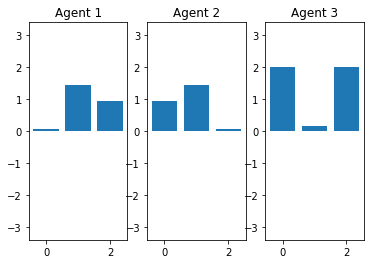

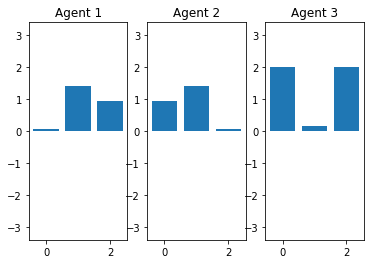

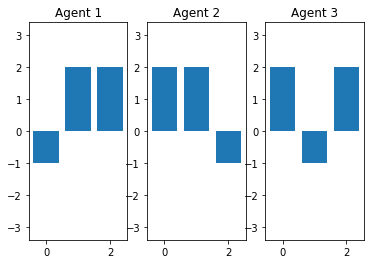

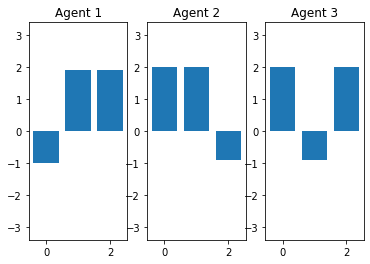

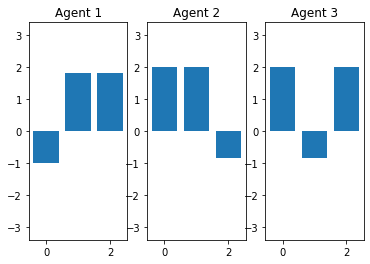

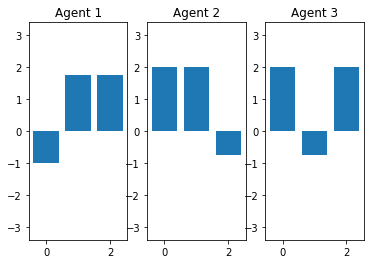

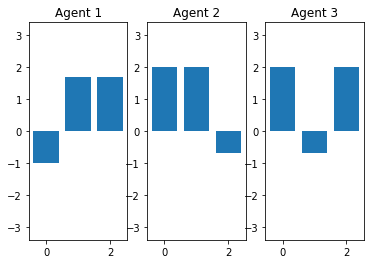

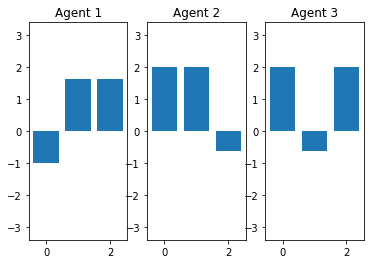

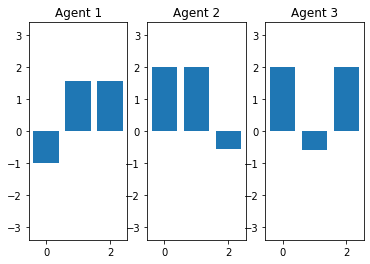

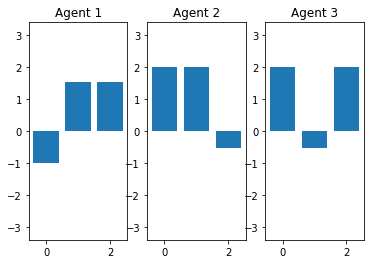

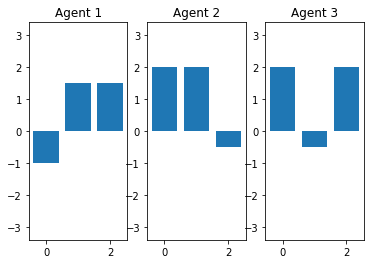

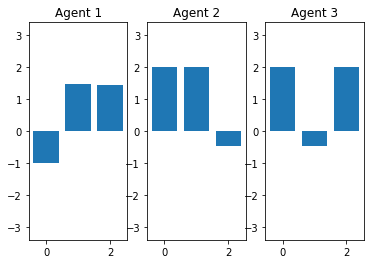

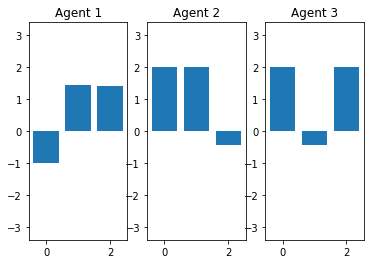

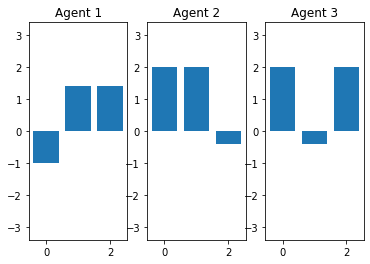

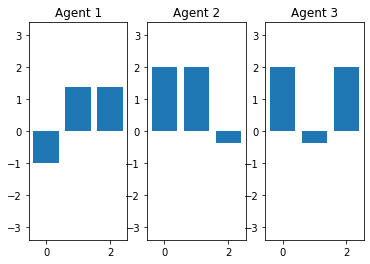

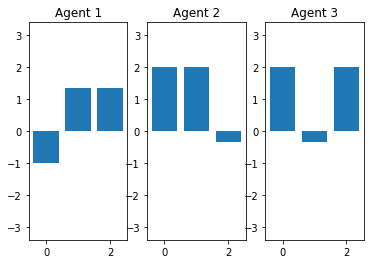

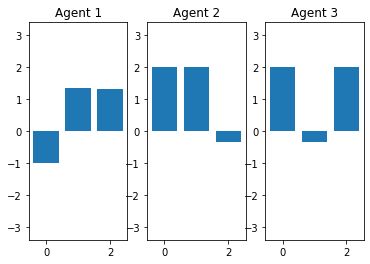

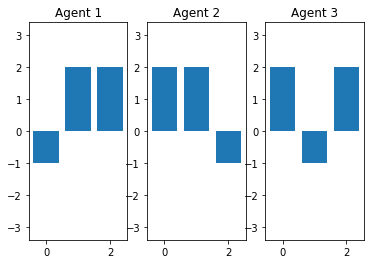

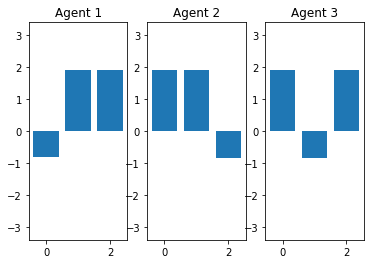

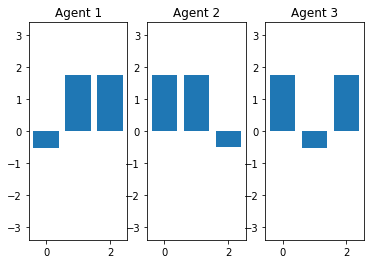

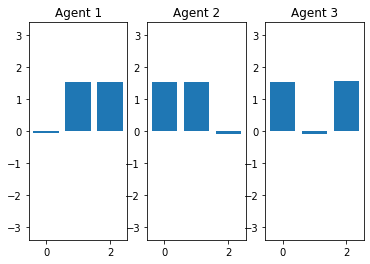

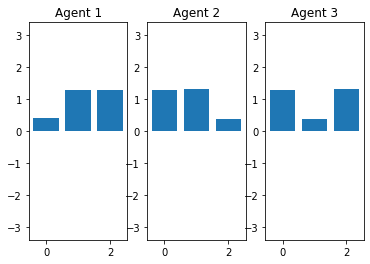

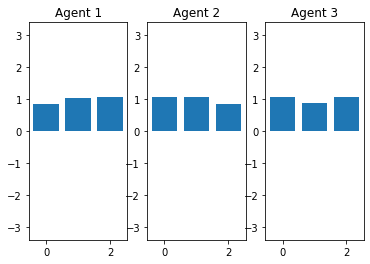

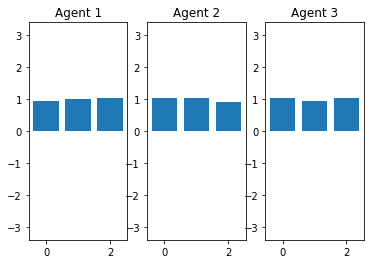

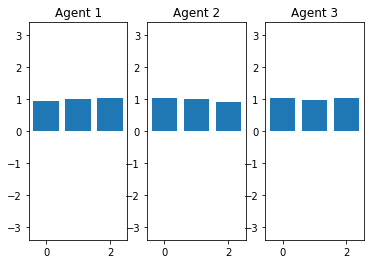

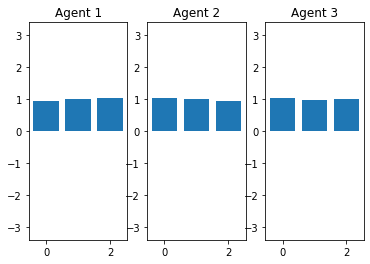

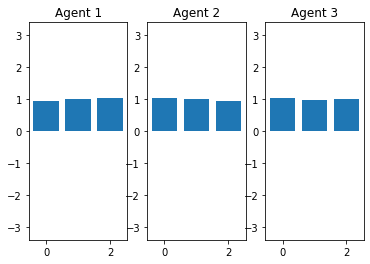

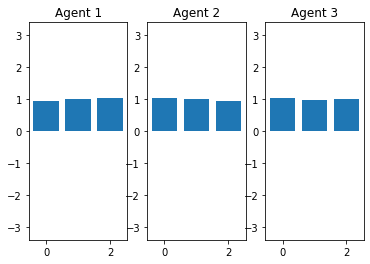

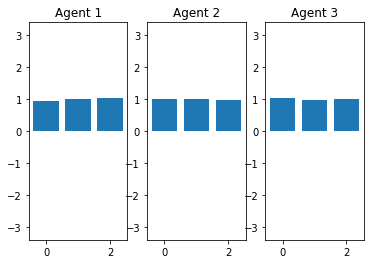

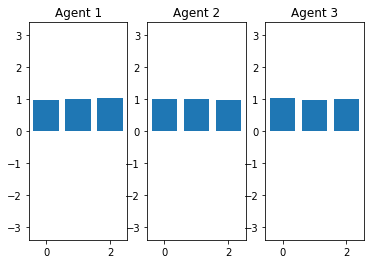

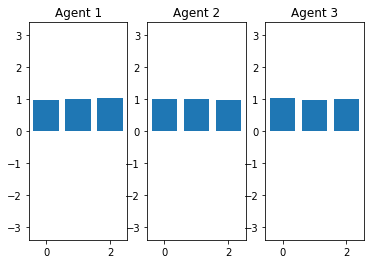

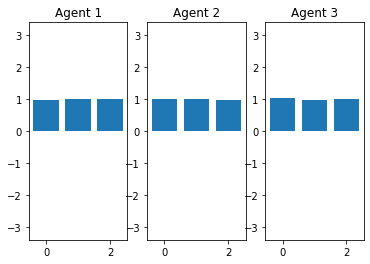

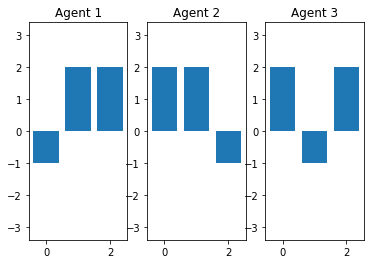

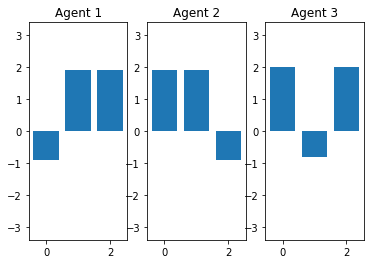

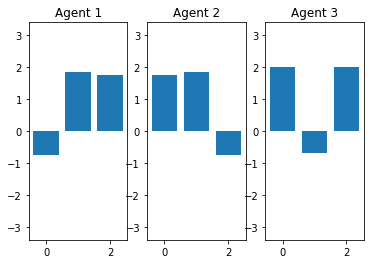

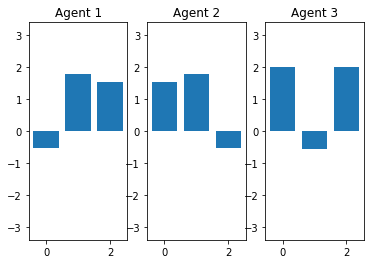

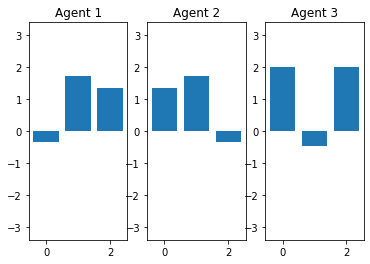

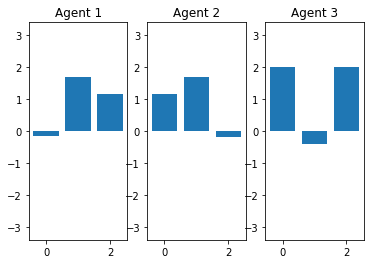

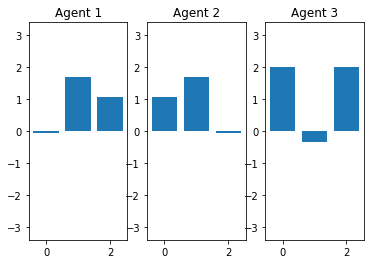

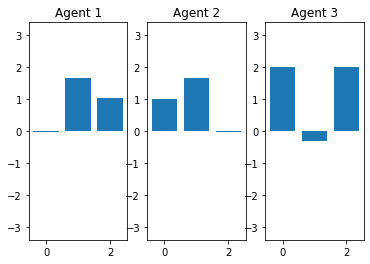

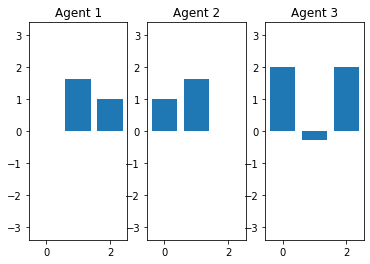

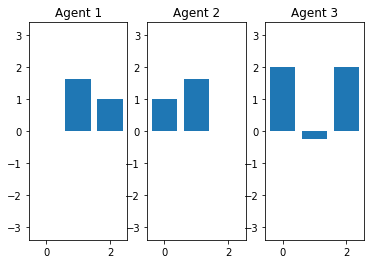

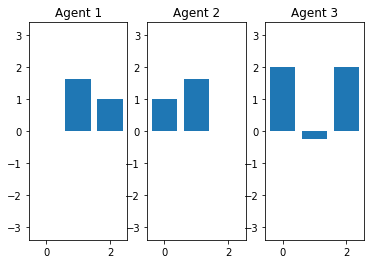

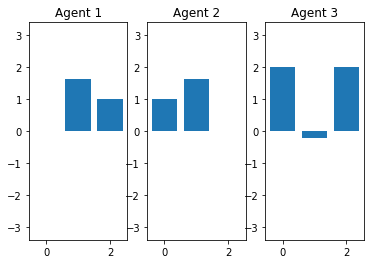

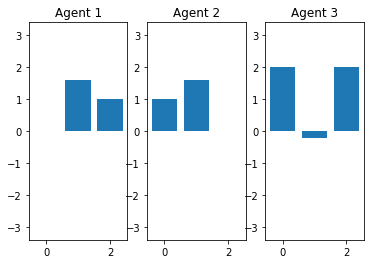

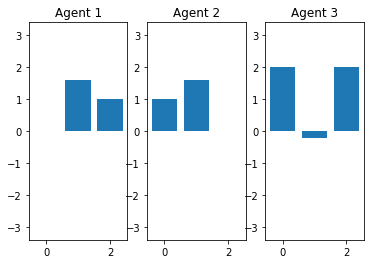

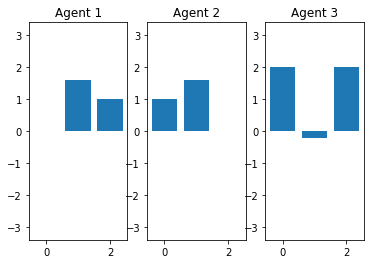

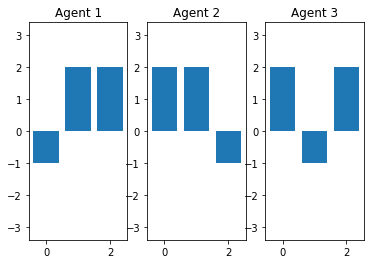

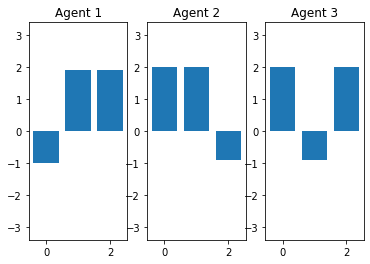

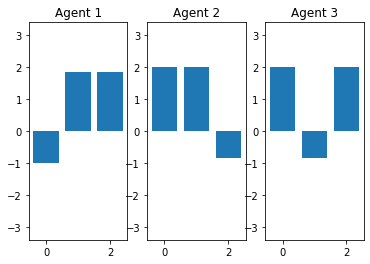

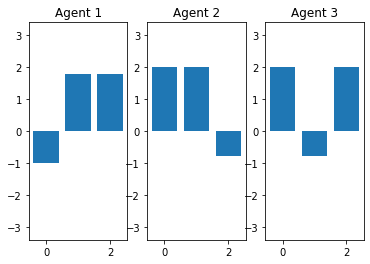

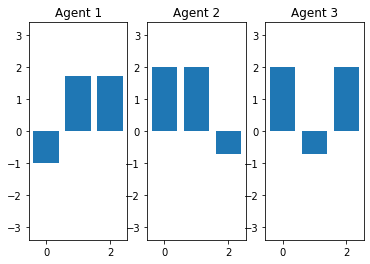

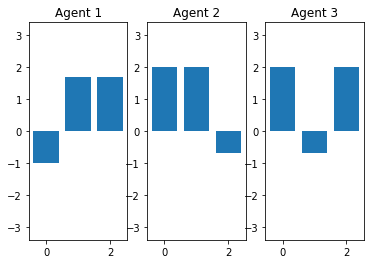

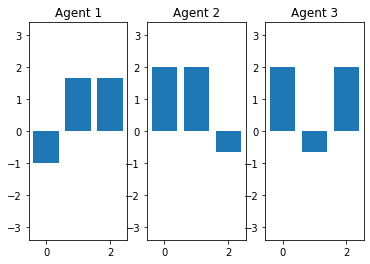

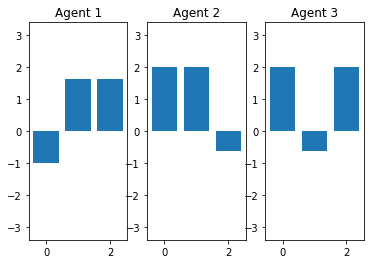

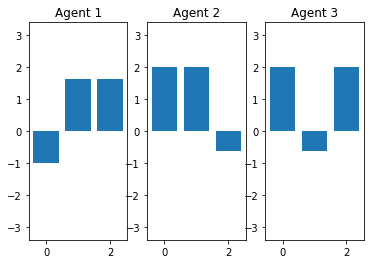

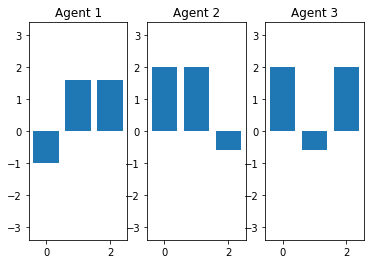

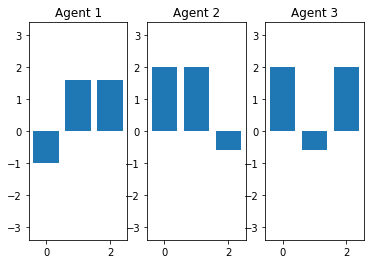

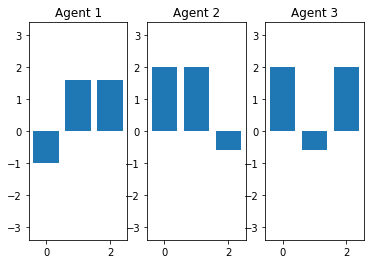

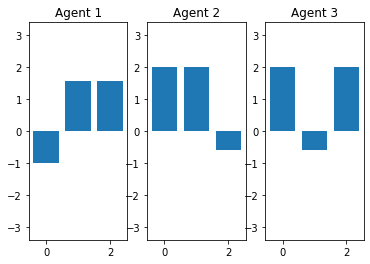

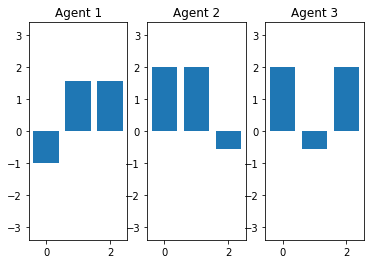

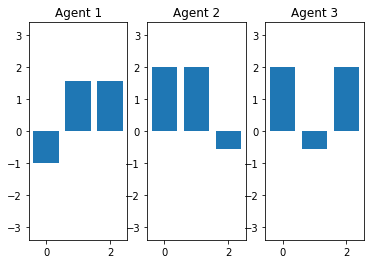

In [2097]:
output2 = all_expe(liste_exp2)

In [2099]:
for x in output2:
    param,_,e,sp,utN,ut1E,ut2E,ut3E = x
    print(param, e, sp, ut1E, ut2E)

[0.1, 0.1, 0.05] 1 0.6960118661144085 3.663752310789029 2.293583279239266
[0.1, 0.1, 0.1] 1 0.6972966561167951 3.5487166379189414 2.408210285656878
[0.1, 0.1, 0.2] 1 0.6972946907479814 3.3597534025627036 2.5436923721584437
